## Introduction

### Contexte

L'agence Santé publique France souhaite améliorer sa base de données Open Food Facts et fait appel aux services de votre entreprise. Cette base de données open source est mise à la disposition de particuliers et d’organisations afin de leur permettre de connaître la qualité nutritionnelle de produits. 
 
Aujourd’hui, pour ajouter un produit à la base de données d'Open Food Facts, il est nécessaire de remplir de nombreux champs textuels et numériques, ce qui peut conduire à des erreurs de saisie et à des valeurs manquantes dans la base. 

L’agence Santé publique France confie à votre entreprise la création d’un système de suggestion ou d’auto-complétion pour aider les usagers à remplir plus efficacement la base de données. Dans un premier temps, vous devez vous concentrer sur la prise en main des données, et d’abord les nettoyer et les explorer. 

### Problématique

__Est-il possible de suggérer des valeurs pour certains champs lors de l'ajout d'un nouveau produit afin de réduire les erreurs de saisie et les valeurs manquantes dans la base de données Open Food Facts ?__

### Objectifs

- Identifier les variables cibles pour lesquelles il serait pertinent de suggérer des valeurs (plus de 50% de valeurs manquantes).
- Identifier les variables nécessaires pour lesquelles il est important d'avoir des données.
- Filtrer 
- Mettre en évidence les valeurs manquantes
- Identifier 3 méthodes adaptées (métiers) pour traiter ces valeurs manquantes.
- Automatiser les traitements pour éviter de répéter les opérations.


- Se servir de ces variables nécessaires pour tenter de faire des suggestions sur les variables avec des valeurs manquantes.

- Etablir la faisabilité de suggérer les valeurs manquantes pour une variable dont plus de 50% des valeurs sont manquantes.

### About RGPD

- Expliquer que la RGPD ne s'applique que dans le cadre de la manipulation de données personnelles.
- Détailler les grands principes des RGPD et en quoi ce projet reste tout de même cohérent avec ces principes.
- Expliquer ce qu'et une donnée personnelle et conclure que dans ce projet n'a pas de lien avec les RGPD.

## Imports and setup

In [103]:
%pip install pandas
%pip install matplotlib
%pip install seaborn
%pip install missingno
%pip install googletrans==4.0.0-rc1
%pip install geopy
%pip install tqdm
%pip install -U scikit-learn
%pip install scipy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [104]:
import unicodedata
from difflib import SequenceMatcher
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.spatial.distance import euclidean, cdist, pdist, squareform
from itertools import combinations
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import matplotlib.dates as mdates
import seaborn as sns
from typing import Optional, Callable, Literal
import missingno as msno
import re
import math
from googletrans import Translator
from tqdm import tqdm
from functools import partial
from geopy.geocoders import Nominatim
from httpx import Timeout
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.utils._param_validation import StrOptions
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import pairwise_distances
from scipy.stats.contingency import association


from joblib import Parallel, delayed

import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from fuzzywuzzy import fuzz
from collections import Counter

import cProfile
import pickle
tqdm.pandas()

In [105]:
# Set the seaborn theme for plots
sns.set_theme(palette="dark")

In [106]:
# Data collection

# Using low_memory = False to remove the DTypeWarning resulted in "code" column being modified.
# For example :
# low_memory = True : 11778, 11778
# low_memory = False : 0011778, 00011778
# All duplicates seem to be removed like this with low_memory = False

# Collect data and store it in a DataFrame
products = pd.read_csv('fr.openfoodfacts.org.products.csv', sep="\t", low_memory=True)

C:\Users\HCYF5290\AppData\Local\Temp\1\ipykernel_22448\3640485078.py:10: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,35,36,37,38,39,48) have mixed types. Specify dtype option on import or set low_memory=False.
  products = pd.read_csv('fr.openfoodfacts.org.products.csv', sep="\t", low_memory=True)


In [107]:
products.loc[(products["pnns_groups_2"] == "Tripe dishes"), ["product_name", "pnns_groups_1", "pnns_groups_2"]]

product_name pnns_groups_1 pnns_groups_2
112591             Tripes cuisinées tomate           NaN  Tripe dishes
113100   gras double de bœuf tripe cuites            NaN  Tripe dishes
179600            Tripes à la mode de Caen           NaN  Tripe dishes
184557            Tripes à la mode de Caen           NaN  Tripe dishes
185294         Boudins Noirs, Aux Oignons            NaN  Tripe dishes
...                                    ...           ...           ...
273470              6 Black Pudding Slices           NaN  Tripe dishes
274431  4 traditional Black Pudding slices           NaN  Tripe dishes
274432      Traditional Bury Black Pudding           NaN  Tripe dishes
311590           Tripes à la mode de Caen            NaN  Tripe dishes
320204                       Black Pudding           NaN  Tripe dishes

[69 rows x 3 columns]

## General and basic data exploration

<Axes: >

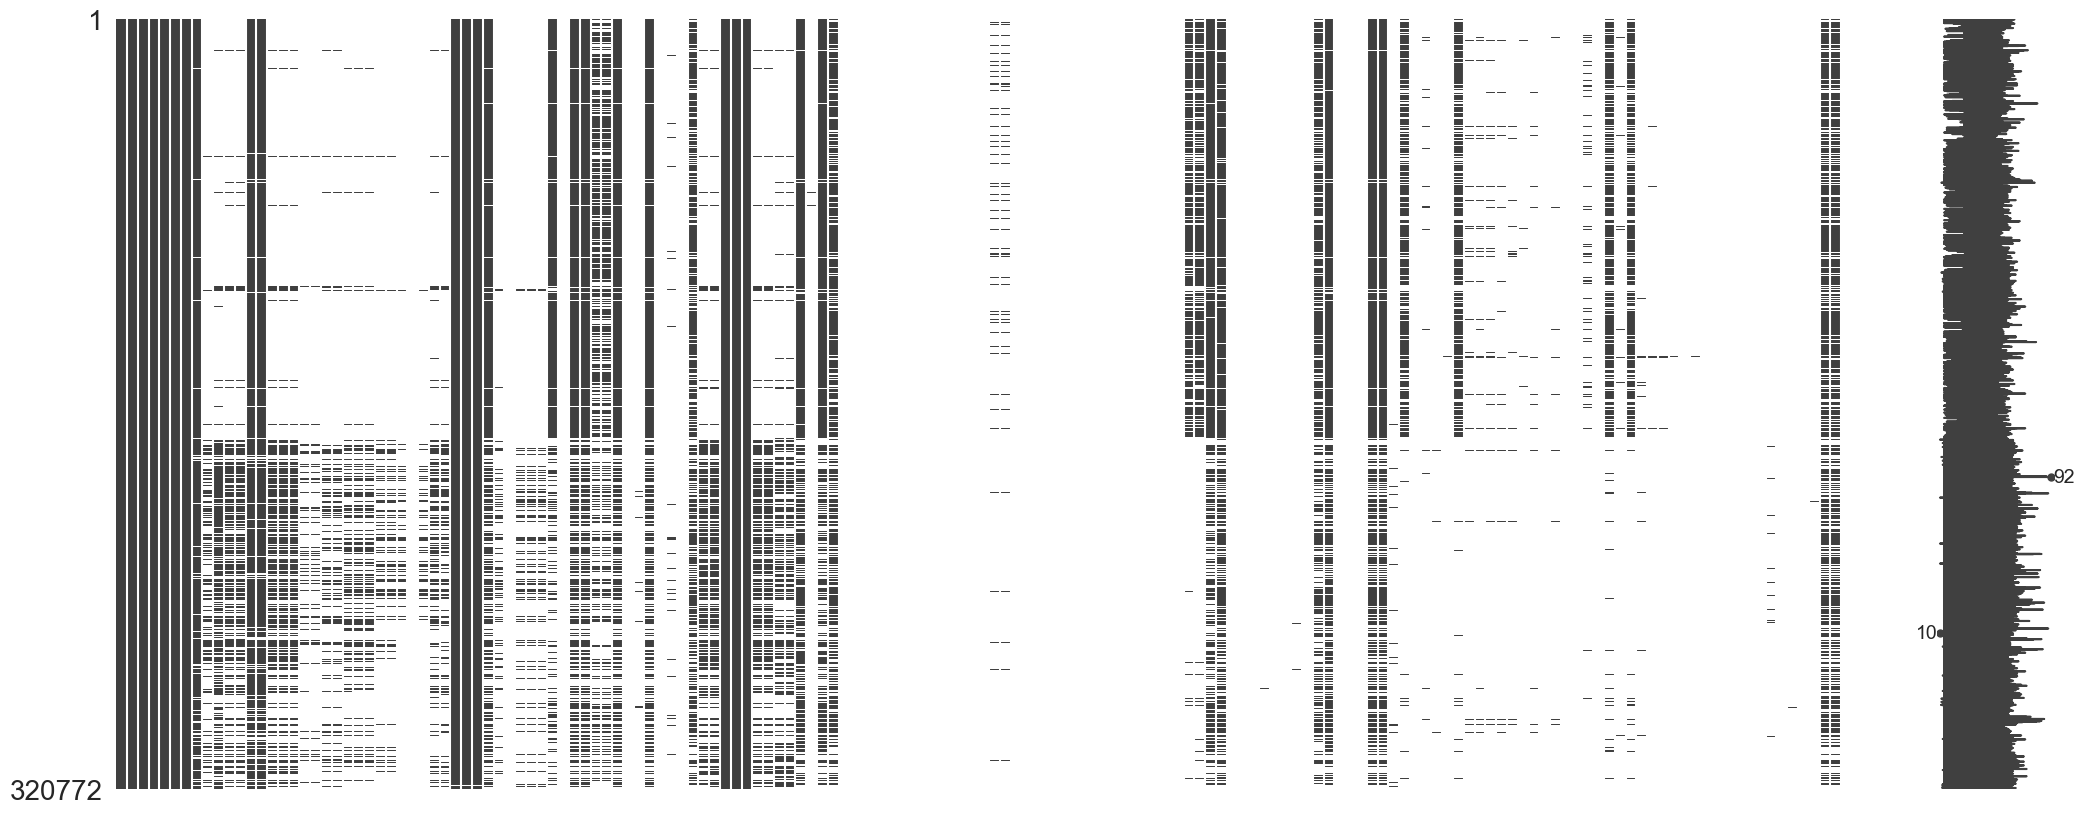

In [108]:
# Visualize missing values
msno.matrix(products)

There are a lot of missing values.  
We can distinguish some patterns here but this will be investigated later.

In [109]:
def display_unique_values(s:pd.Series, df:pd.DataFrame):
    n_unique_values = df.loc[s.name, "nbr_unique_values"]
    if n_unique_values == 0:
        return "no value"
    if n_unique_values < 6:
        return ", ".join(f"{s.value_counts().index[i]} ({v} occurrences)" for i, v in enumerate(s.value_counts()))
    
    return "too many to display"


def add_additional_comment(s:pd.Series, df:pd.DataFrame, sensitivity:float):   
    value_counts = s.value_counts()

    if len(value_counts) > 0:
        # Calculate top common values based on sensitivity
        n_top_common_values = int(len(value_counts) * sensitivity)
        top_common_values = value_counts.values[:n_top_common_values]
        
        # Check if the top common values represent a significant proportion of the data
        if value_counts.quantile(1 - sensitivity) / value_counts.max() < 0.25 and n_top_common_values <= 10:
            sum_top_common_values = top_common_values.sum()
            top_common_values_prop = round(sum_top_common_values / df.loc[s.name, "nbr_non_null_values"], 2)
            top_common_values_info = [f"{value_counts.index[i]} ({value})" for i, value in enumerate(top_common_values)]
            
            # Print additional comments on common values
            return f"""First {n_top_common_values} unique values represent {top_common_values_prop * 100}% of total values : {', '.join(top_common_values_info)}"""
        
        return
    
    else:
        return "This column only contains null values."


def compute_modes(s:pd.Series):
    value_counts = s.value_counts()
    modes = s.mode()
    n_modes = len(modes)

    if n_modes > 0:
        return ", ".join(str(v) if i < 3 else f"... ({n_modes} elements)" for i, v in enumerate(modes[:min(n_modes, 4)])) + f" ({value_counts.values[0]} occurrence(s))"
    
    return


def get_df_variables_info(df:pd.DataFrame) -> pd.DataFrame:

    (n_rows, n_columns) = df.shape
    print(f"This DataFrame has {n_rows} rows and {n_columns} columns.")
    
    top_common_values_sensitivity = 0.15

    n_unique_values = df.nunique()
    n_values = df.count()

    df_info = pd.DataFrame({
        'column_type':df.dtypes,
        'missing_value_percentage': (df.isnull().mean()*100).round(3),
        'nbr_unique_values': n_unique_values,
        'nbr_null_values': df.isnull().sum(),
        'nbr_non_null_values': n_values,
        'duplicates_percentage':round(100-n_unique_values/(n_values.where(n_values != 0, np.nan))*100, 2),
        'mode': df.apply(compute_modes),
        'min': df.min(numeric_only=True),
        'max': df.max(numeric_only=True),
        'mean': df.mean(numeric_only=True),
        'median': df.median(numeric_only=True),
        'std': df.std(numeric_only=True)
        })

    df_info["unique_values"] = df.apply(display_unique_values, df=df_info)
    df_info["additional_comment"] = df.apply(add_additional_comment, df=df_info, sensitivity=top_common_values_sensitivity)

    return df_info


In [110]:
products_info = get_df_variables_info(products)

This DataFrame has 320772 rows and 162 columns.


## Dtypes fixes

### Incorrect datetime formats

Columns "last_modified_datetime" and "created_datetime" should be of dtype "datetime64[ns]". Let's try to convert them.

In [111]:
# products["last_modified_datetime"] = pd.to_datetime(products["last_modified_datetime"])

The previous commented line gives an error: 'time data "en:belgium,en:france" doesn't match format "%Y-%m-%dT%H:%M:%S%z"'.
Some datetime values are not formatted correctly. Let's identify the products that have this issue.

In [112]:
# Convert to datetime, and highlight errors with NaT.
products["last_modified_datetime"] = pd.to_datetime(products["last_modified_datetime"], errors='coerce')
products["created_datetime"] = pd.to_datetime(products["created_datetime"], errors='coerce')

annoying_products = products.loc[products["last_modified_datetime"].isna() | products["created_datetime"].isna()]

print(f"Here are the {len(annoying_products)} products with incorrect datetime format:")
annoying_products[["code", "product_name", "created_datetime", "last_modified_datetime"]]

Here are the 24 products with incorrect datetime format:


code                product_name created_datetime  \
187478  3017760038409  Lulu la barquette (Fraise)              NaT   
189068            NaN             Belgique,France              NaT   
189103            NaN                      France              NaT   
189109            NaN      Belgique,France,Suisse              NaT   
189119            NaN                      France              NaT   
189152            NaN                      France              NaT   
189160            NaN                      France              NaT   
189162            NaN                      France              NaT   
189168            NaN                      France              NaT   
189242            NaN                      France              NaT   
189244            NaN                      France              NaT   
189248            NaN                      France              NaT   
189250            NaN                      France              NaT   
189260            NaN                      France              NaT   
189262            NaN                      France              NaT   
189269            NaN                      France              NaT   
189272            NaN                      France              NaT   
189345            NaN                      France              NaT   
189362            NaN                      France              NaT   
189364            NaN                      France              NaT   
189379            NaN                      France              NaT   
189404            NaN               France,Suisse              NaT   
189406            NaN                      France              NaT   
189417            NaN                      France              NaT   

          last_modified_datetime  
187478 2017-03-08 16:54:15+00:00  
189068                       NaT  
189103                       NaT  
189109                       NaT  
189119                       NaT  
189152                       NaT  
189160                       NaT  
189162                       NaT  
189168                       NaT  
189242                       NaT  
189244                       NaT  
189248                       NaT  
189250                       NaT  
189260                       NaT  
189262                       NaT  
189269                       NaT  
189272                       NaT  
189345                       NaT  
189362                       NaT  
189364                       NaT  
189379                       NaT  
189404                       NaT  
189406                       NaT  
189417                       NaT

Columns seem to have been mixed for most of those products. Reorganizing values in their correct column is quite difficult since there is no information on the product "code".
Those lines will just be dropped because it doesn't represent much data.  
Only index "187478" will be kept because it is a special case : all columns are correctly assigned, only the created_datetime and created_t are weird.  


In [113]:
# Remove index 187478 from annoying products
annoying_products = annoying_products.drop(index=187478)

# Remove annoying products from products
products = products.drop(index=annoying_products.index).reset_index(drop=True)

# Replace missing created_datetime with corresponding last_modified_datetime
# Ideally, we could impute created_datetime value based on created_t column, but created_t is 0 for index 187478.
products.loc[187478, "created_datetime"] = products.loc[187478, "last_modified_datetime"]

### Fixed mixed types

In [114]:
def check_for_mixed_types(df:pd.DataFrame) -> list:
    '''
    Checks a DataFrame for columns with inconsistent types.

    Parameters:
    df (pd.Dataframe): DataFrame to check

    Returns:
    List of column with inconsistent types.
    '''
    cols_mixed_types = []
    for col in df.columns:
        col_dropped_na = df[col].dropna(ignore_index=True)
        if len(col_dropped_na) > 0:
          unique_types = col_dropped_na.apply(type).unique()
          if len(unique_types) > 1:
            cols_mixed_types.append({col:unique_types.tolist()})
    
    print(f"{len(cols_mixed_types)} column(s) have inconsistent types (excluding NaN values).")
    
    return cols_mixed_types

In [115]:
check_for_mixed_types(products)

3 column(s) have inconsistent types (excluding NaN values).


[{'code': [int, str]},
 {'created_t': [int, str]},
 {'last_modified_t': [int, str]}]

In [116]:
# We want to keep NaN values
# Converting to int is not possible due to codes exceeding int size limit. Therefore we convert it to strings
products.loc[products["code"].notna(), "code"] = products.loc[products["code"].notna(), "code"].astype(str)

In [117]:
products.loc[products["created_t"].notna(), "created_t"] = products.loc[products["created_t"].notna(), "created_t"].astype(int)

In [118]:
products.loc[products["last_modified_t"].notna(), "last_modified_t"] = products.loc[products["last_modified_t"].notna(), "last_modified_t"].astype(int)

In [119]:
check_for_mixed_types(products)

0 column(s) have inconsistent types (excluding NaN values).


[]

### Minor notes

Columns "ingredients_from_palm_oil" and "ingredients_that_may_be_from_palm_oil" should be of type "object" instead of "float64", but since there are only null values it doesn't really matter.  
Same thing for column "nutrition_grade_uk".

## Missing data patterns investigation

<Axes: >

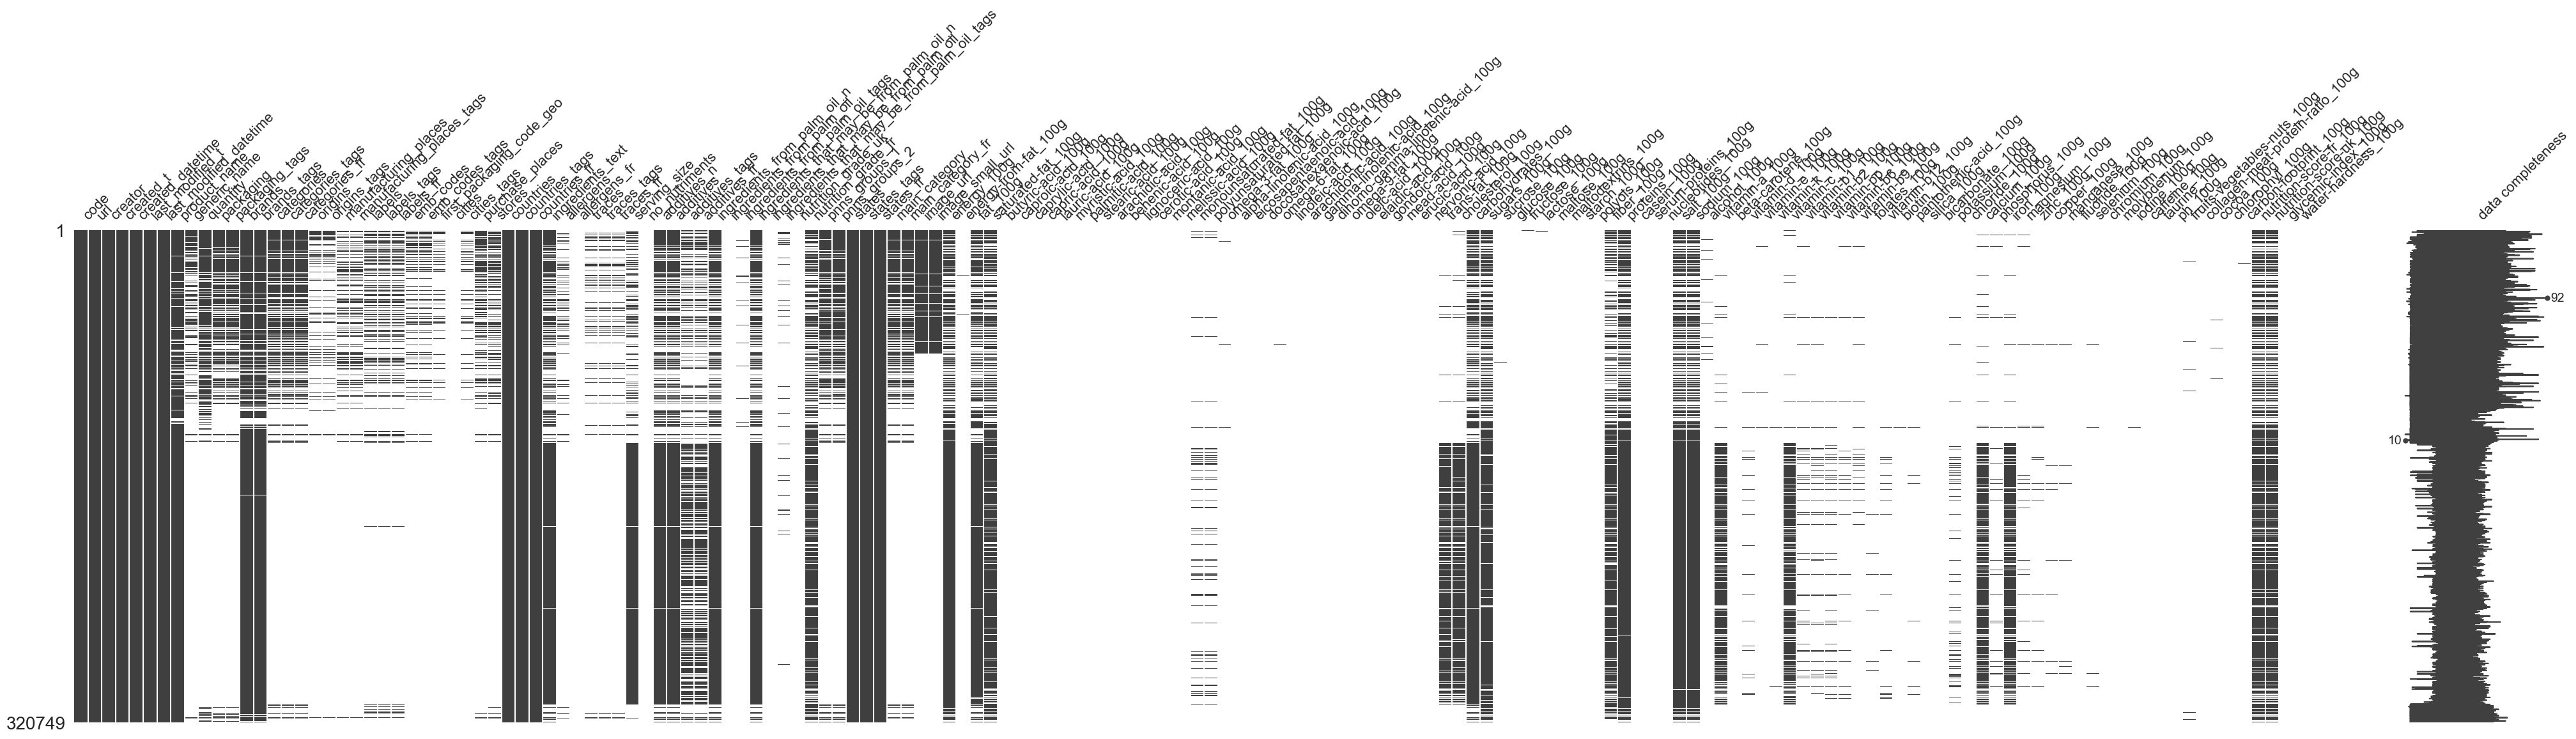

In [120]:
msno.matrix(products.sort_values(by="created_datetime"), labels = True, figsize=(50,10))

After sorting by creation date, it seems pretty clear that there's a correlation between the creation date and the amount of missing data.

In [121]:
def visualize_smth(df:pd.DataFrame, x:str="event_date", y=None, date_format:str='%Y%m%d', x_is_date:bool|Literal["auto"]="auto", suptitle:str="Title", method:Callable=sns.displot, barlabels_params:Optional[dict]={'padding':2, 'fmt':lambda x: int(x) if int(x) > 0 else ''}, subplot_params:dict={}, **plot_params):
    '''
    Handy function to visualizes data from a pandas DataFrame using a specified plotting method.

    Parameters:
    -----------
    df : pd.DataFrame
        The DataFrame containing the data to be visualized.
    
    x : str, default="event_date"
        The column name in the DataFrame to be used for the x-axis.
    
    y : str or None, optional, default=None
        The column name in the DataFrame to be used for the y-axis. If None, no y-axis is used.
    
    date_format : str, optional, default='%Y%m%d'
        The format to be used when converting the x-axis data (if applicable) to datetime.
    
    x_is_date : bool or "auto", default="auto"
        If "auto", the function will attempt to determine whether the x-axis column can be treated as a date.
        If True, the x-axis will be treated as a date. If False, it will not.
    
    suptitle : str, default="Title"
        The title of the plot, displayed at the top of the figure.
    
    method : Callable, default=sns.displot
        The plotting function (e.g., `sns.displot`, `sns.lineplot`, etc.) that will be used for visualization.
    
    barlabels_params : dict, optional, default={'padding': 2, 'fmt': lambda x: int(x) if int(x) > 0 else ''}
        Parameters to control the appearance of bar labels (if applicable). This can be used to customize the appearance of labels on bar charts.
    
    subplot_params : dict, default={}
        Additional parameters to pass to the plotting method.
    
    plot_params : dict, optional
        Additional parameters to customize the plot (such as row-wise facet splitting, etc.).
    
    Returns:
    --------
    None
        Displays the plot and shows it to the user.
    
    Notes:
    ------
    - If `x_is_date` is set to "auto", the function will attempt to parse the `x` column as datetime using the provided `date_format`.
    - The function automatically handles the filtering of data based on row facets if provided in `plot_params["row"]`.
    - The `wrapper` function ensures proper date formatting and handling of bar labels for various plot methods.
    - The `method` argument can be any seaborn plotting function (such as `sns.displot`, `sns.lineplot`, etc.).
    - The function can handle faceted visualizations if the chosen method supports it.
    
    Example usage:
    ---------------
    visualize_smth(df, x="event_date", y="sales", date_format="%Y-%m-%d", method=sns.lineplot, suptitle="Sales Over Time")
    '''
    
    data = df.copy()

    if "row" in plot_params:
        # Define the maximum number of rows
        max_rows = 10
        # Create a subset of the data based on the maximum number of rows
        unique_rows = df[plot_params["row"]].unique()[:max_rows]
        # Filter the dataset
        data = df[df[plot_params["row"]].isin(unique_rows)]

    if x_is_date: # "auto" or True
        try:
            # Convert event_date from string to datetime
            data[x] = pd.to_datetime(data[x], format=date_format, errors='raise')
            x_is_date = True

        except Exception:
            x_is_date = False
            print("Data on X axis will not be considered as a date.")
    
    data = data.sort_values(by=x)
    data = data.reset_index(drop=True)

    locator = mdates.AutoDateLocator(minticks=70)

    def wrapper(locator, barlabels_params, **params):
        ax = plt.gca()
        # method(x=x_date, y=y, ax=ax, **subplot_params)
        ax.tick_params(axis='x', labelrotation=90, labelbottom=True)
        if barlabels_params:
          for i in range(len(ax.containers)):
              ax.bar_label(ax.containers[i], **barlabels_params)
        if x_is_date:
            ax.xaxis.set_major_locator(locator)

    method_type = type(method())
    plt.close()
    
    if method_type == sns.axisgrid.FacetGrid:
        g = method(data=data, x=x, y=y, **plot_params, **subplot_params)
    else:
        g = sns.FacetGrid(data=data, **plot_params)
        g.map_dataframe(func=method, x=x, y=y, **subplot_params)
    
    g.map_dataframe(func=wrapper, locator=locator, barlabels_params=barlabels_params)
    g.figure.suptitle(suptitle, y=1)
    #g.ax.legend(loc=2)
    #g.add_legend()
    g.tight_layout()
    plt.show()

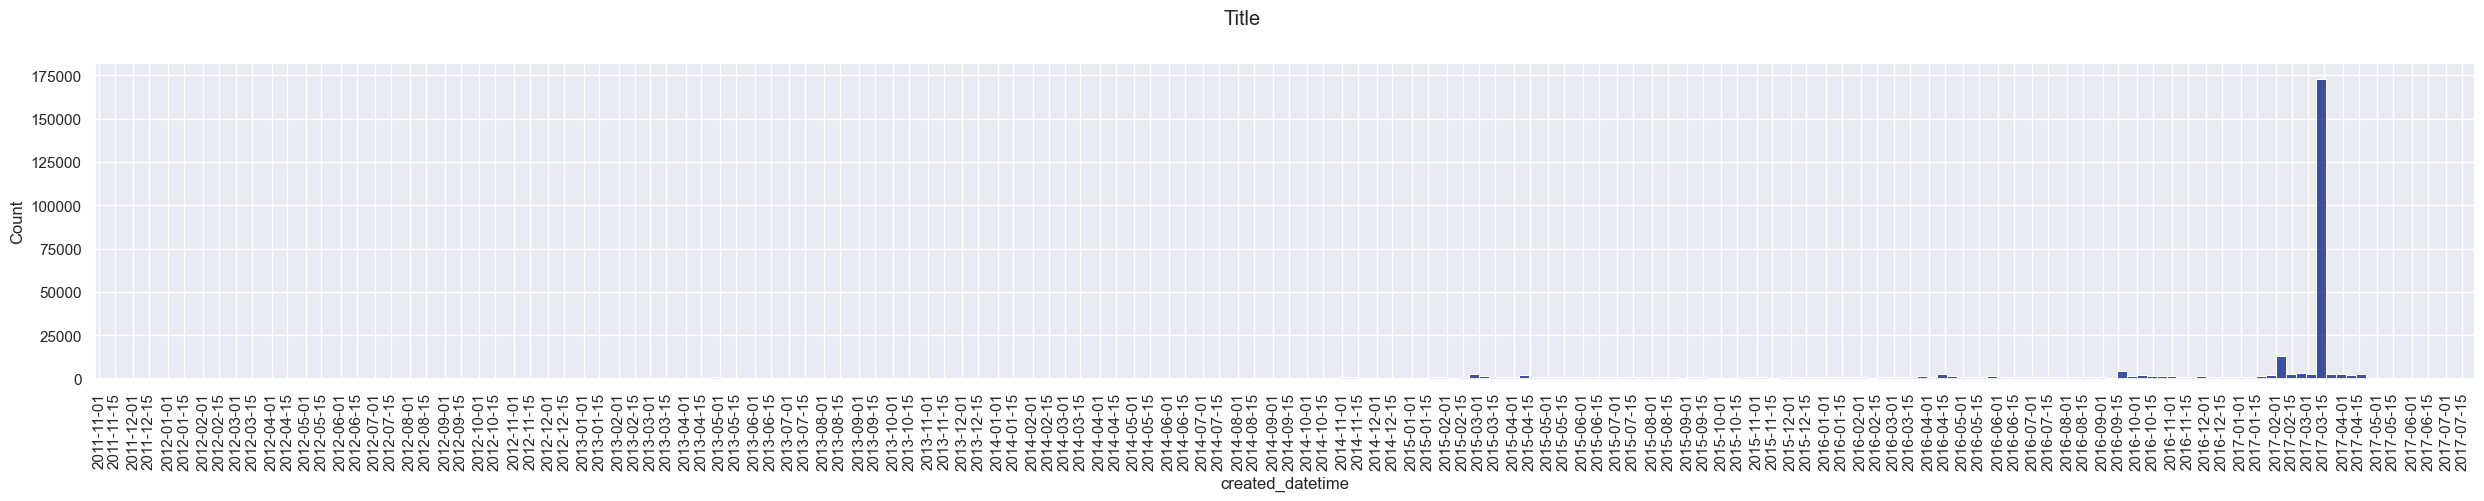

In [122]:
visualize_smth(df=products, x="created_datetime", barlabels_params=None, aspect=5)

In [123]:
# Only keep products from the big spike to analyze it
spike_added_products = products.loc[(products["created_datetime"].dt.date >= pd.to_datetime("20170309", format="%Y%m%d").date()) & (products["created_datetime"].dt.date <= pd.to_datetime("20170310", format="%Y%m%d").date())]

c:\Git-OpenClassrooms\DS_3\.venv\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  self._figure.tight_layout(*args, **kwargs)
c:\Git-OpenClassrooms\DS_3\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  fig.canvas.print_figure(bytes_io, **kw)


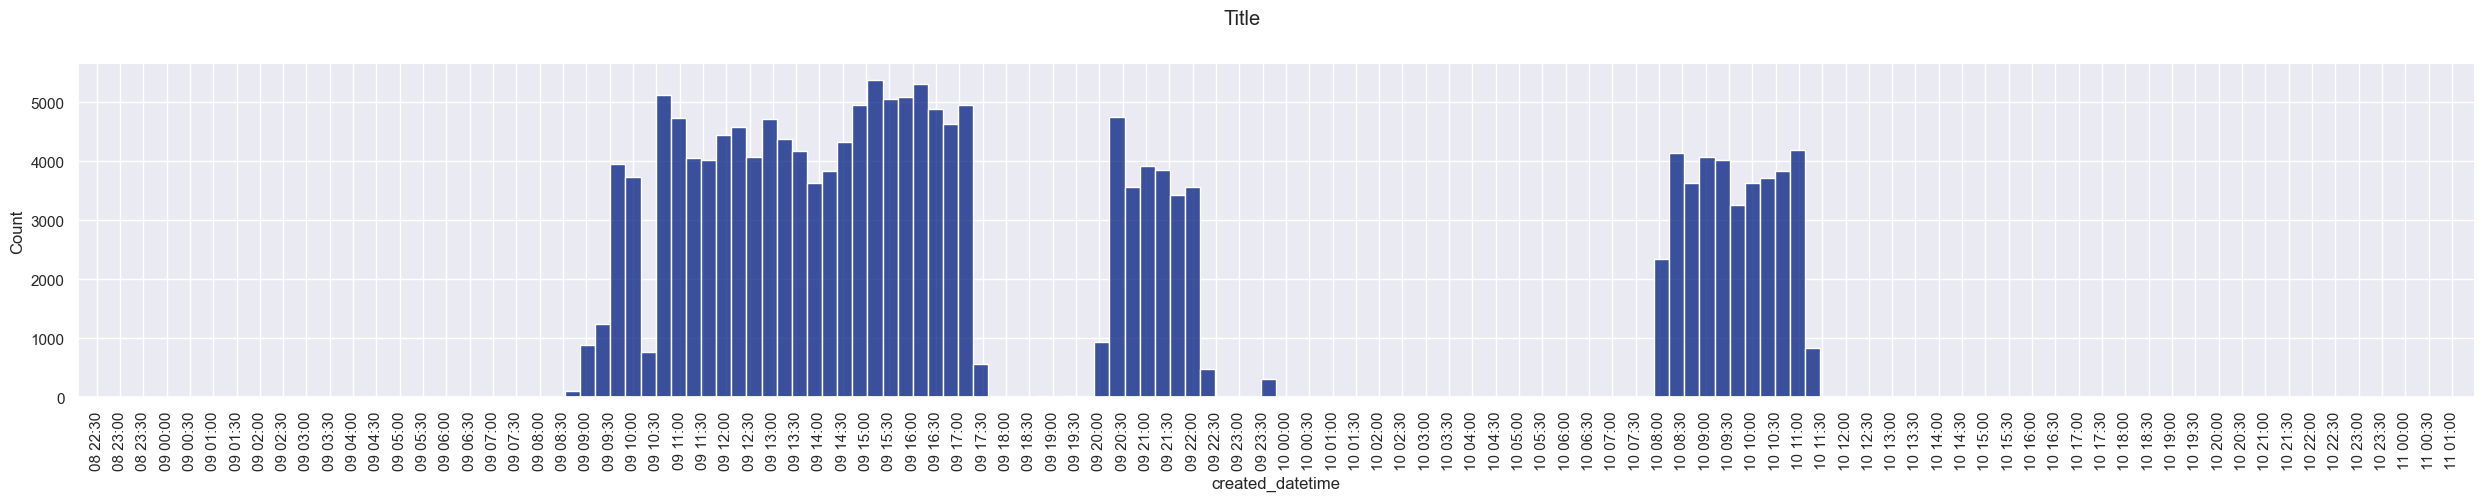

In [124]:
visualize_smth(df=spike_added_products, x="created_datetime", barlabels_params=None, aspect=5)

Data on X axis will not be considered as a date.


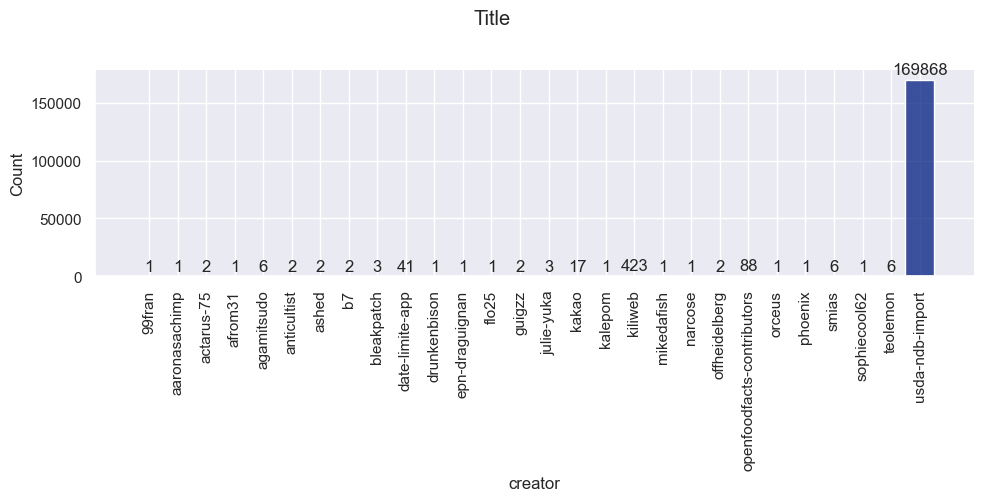

In [125]:
# Who is responsible for those products ?
visualize_smth(df=spike_added_products, x="creator", aspect=2)

In [126]:
# Only keep usda-ndb imported products
usda_ndb_imported_products = products.loc[products["creator"] == "usda-ndb-import"]

<Axes: >

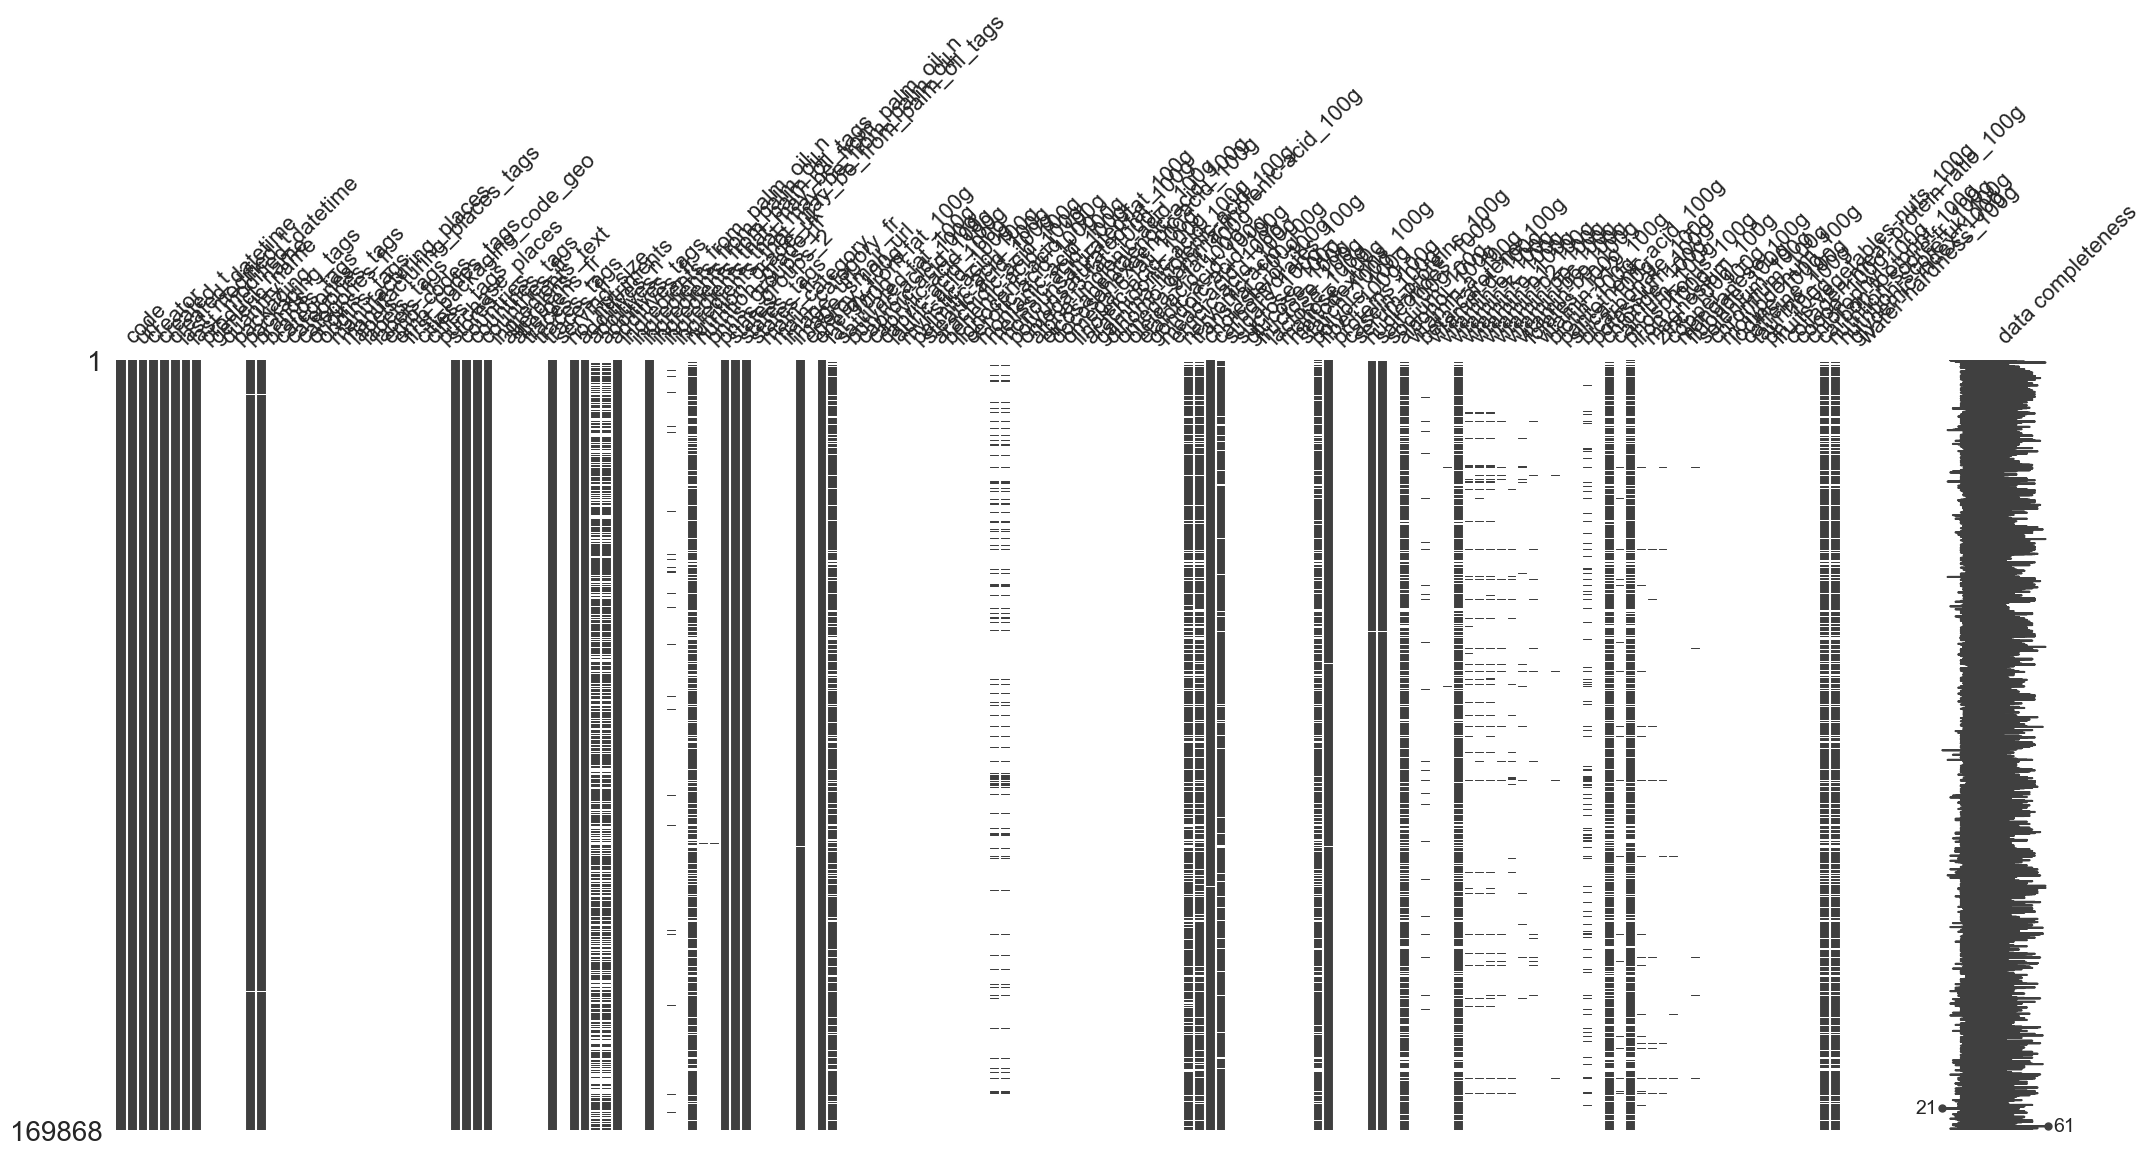

In [127]:
msno.matrix(usda_ndb_imported_products, labels=True)

They all follow similar missing data patterns.

In [128]:
# Update products_info
products_info = get_df_variables_info(products)

This DataFrame has 320749 rows and 162 columns.


## Data cleaning and filtering

### Finding hidden missing values

It seems some values should actually be considered as missing values.  
Let's identify as many of those hidden missing values as possible in the columns of type "object".

In [129]:
def standardize_str(s:str, escape_chars:list=[]):
    ''' 
    Removes non words characters (even whitespaces) and set to lower case.
    Used to detect hidden missing values ('N/A', 'UNKNOWN', ...)
    '''
    if pd.isnull(s):
        return s
    escape_pattern = ''.join(re.escape(char) for char in escape_chars)
    pattern = r'[^\w' + escape_pattern + r']|_'
    return re.sub(pattern, '', str(s), flags=re.UNICODE).lower()

In [130]:
def find_hidden_missing_values(df:pd.DataFrame, standardize:bool=True, print_result:bool = True, impute_nan:bool=False, additional_hidden_null_values:list[str] = ["unknown", "null", "nan", "na", "0", "inconnu", "unavailable", "not stated"]):   
    df_copy = df.copy()

    for col in df_copy:
        if standardize:
            data = df_copy[col].map(standardize_str)
        else:
            data = df_copy[col]
        contains_alphanumeric = data.str.contains(pat=r'\w', na=True, regex=True)
        hidden_null_values_condition = ~contains_alphanumeric | data.isin(additional_hidden_null_values)
        
        if hidden_null_values_condition.any():
            if print_result:
                hidden_null_values = df_copy.loc[hidden_null_values_condition, col]
                print(f"{col}:\n{hidden_null_values}\n{'*'*30}\n")
            if impute_nan:
                df_copy.loc[hidden_null_values_condition, col] = np.nan
    
    if impute_nan:
        return df_copy

In [131]:
# Identify columns with type "object", which can contain hidden null values.
products_object_columns = products.select_dtypes(include=object)
# Remove columns with only null values
products_object_columns = products_object_columns.dropna(axis='columns', how='all')

In [132]:
# find_hidden_missing_values(df=products_object_columns, standardize=True, print_result=True, impute_nan=False)

In [133]:
# Fix some product names after checking their page using the provided url
products.loc[268391, "product_name"] = "5 stars"
products.loc[268392, "product_name"] = "3 stars"
products.loc[315650, "product_name"] = "Dors Tequila"

In [134]:
# Update products_objects_columns to take last changes into account
products_object_columns = products.select_dtypes(include=object)
products_object_columns = products_object_columns.dropna(axis='columns', how='all')

products_object_columns = find_hidden_missing_values(df=products_object_columns, standardize=True, print_result=False, impute_nan=True)

In [135]:
# Replace object columns with the new object columns (with hiddent null values imputed as NaN)
products[products_object_columns.columns] = products_object_columns

### Removing irrelevant columns

It seem "additives" column contains information on all ingredients, and not only on additives as it is illustrated in the next cell.  
It shows that additives can be detected even if their code is not written. Example : alcohol -> e1510.
All detected additives are listed in the column "additives_tags".
Column "additives" does not bring additional information and will be removed for the rest of the analysis.

In [136]:
# Illustrate that "additives" column seems to have been created from values in "ingredients_text" column
with pd.option_context('display.max_colwidth', None):
    display(products.loc[products["additives"].notna(), ["product_name", "ingredients_text", "additives"]])

product_name  \
1                                          Banana Chips Sweetened (Whole)   
2                                                                 Peanuts   
3                                                  Organic Salted Nut Mix   
4                                                         Organic Polenta   
5                                       Breadshop Honey Gone Nuts Granola   
...                                                                   ...   
320735                                                   Miel de Camargue   
320740                                                 Thé vert Earl grey   
320742                                                     Rillette d'oie   
320745  Mint Melange Tea A Blend Of Peppermint, Lemon Grass And Spearmint   
320748                                    Sugar Free Drink Mix, Peach Tea   

                                                                                                                                                                                               ingredients_text  \
1                                                                                                                  Bananas, vegetable oil (coconut oil, corn oil and/or palm oil) sugar, natural banana flavor.   
2                                        Peanuts, wheat flour, sugar, rice flour, tapioca starch, salt, leavening (ammonium bicarbonate, baking soda), soy sauce (water, soybeans, wheat, salt), potato starch.   
3                                                                                                                 Organic hazelnuts, organic cashews, organic walnuts almonds, organic sunflower oil, sea salt.   
4                                                                                                                                                                                               Organic polenta   
5                                                            Rolled oats, grape concentrate, expeller pressed canola oil, sunflower seeds, almonds, walnuts oat bran, sesame seeds, cashews, natural vitamin e.   
...                                                                                                                                                                                                         ...   
320735                                                                                                                                                                                                     Miel   
320740                                                                                                                 thé vert, arôme naturel bergamote avec autres arômes naturels, écorces d'orange douce 3%   
320742                                                                                                                                                    viande d'oie, graisse de canard, épices, sel, poivre.   
320745                                                                                                                                              Organic peppermint, organic lemon grass, organic spearmint.   
320748  Citric acid, maltodextrin, instant tea, aspartame**, caramel color, natural and artificial flavors, contains less than 2% of: magnesium oxide acesulfame potassium, calcium silicate, yellow 5, red 40.   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [137]:
products.drop(columns="additives", inplace=True)

Let's also remove empty columns.

In [138]:
columns_before = set(products.columns)
products.dropna(axis=1, how="all", inplace=True)
removed_columns = columns_before.difference(set(products.columns))
print(f"""{len(removed_columns)} columns were removed:\n{"\n".join(removed_columns)}""")

21 columns were removed:
erucic-acid_100g
cities
no_nutriments
chlorophyl_100g
allergens_fr
gondoic-acid_100g
nutrition_grade_uk
melissic-acid_100g
nervonic-acid_100g
lignoceric-acid_100g
caproic-acid_100g
butyric-acid_100g
ingredients_from_palm_oil
ingredients_that_may_be_from_palm_oil
water-hardness_100g
behenic-acid_100g
dihomo-gamma-linolenic-acid_100g
cerotic-acid_100g
elaidic-acid_100g
glycemic-index_100g
mead-acid_100g


### Removing duplicated columns

#### Highlighting some columns similarities  

In [139]:
# Check that columns "image_small_url" and "image_url" are almost identical. Only the 7th character from the end changes. 
# All urls in image_small_url end with "200.jpg" when all urls in image_url end with "400.jpg"
products.loc[(products["image_small_url"] != (products["image_url"].str[:-7] + "2" + products["image_url"].str[-6:])) & (products["image_url"].notna()), ["image_small_url", "image_url"]]

Empty DataFrame
Columns: [image_small_url, image_url]
Index: []

In [140]:
# Only difference between "state" and "states_tags" columns is that :
# - values are separated by ", " in "states" column (with whitespace)
# - values are separated by "," in "states_tags" column (without whitespace)
products.loc[(products["states"].str.split(', ') != products["states_tags"].str.split(',')) & (products["states"].notna()), ["states", "states_tags"]]

Empty DataFrame
Columns: [states, states_tags]
Index: []

#### Highlighting relation between 2 categorical variables

In [141]:
def get_crosstab_pair_features(df:pd.DataFrame, col1:str, col2:str):
    dropped_df = df.dropna(subset=[col1, col2])
    if (len(dropped_df[col1].unique()) > 1000) or (len(dropped_df[col2].unique()) > 1000):
      raise Exception("Too many unique values to compute crosstab_result.")

    crosstab_result = pd.crosstab(index=dropped_df[col1], columns=dropped_df[col2])
    association_metric = association(crosstab_result)
    print("The association variable between",crosstab_result.index.name,"and",crosstab_result.columns.name,"is:",association_metric)

    return crosstab_result


In [142]:
get_crosstab_pair_features(df=products, col1="pnns_groups_1", col2="pnns_groups_2")

The association variable between pnns_groups_1 and pnns_groups_2 is: 1.0


pnns_groups_2            Appetizers  Artificially sweetened beverages  \
pnns_groups_1                                                           
Beverages                         0                               261   
Cereals and potatoes              0                                 0   
Composite foods                   0                                 0   
Fat and sauces                    0                                 0   
Fish Meat Eggs                    0                                 0   
Fruits and vegetables             0                                 0   
Milk and dairy products           0                                 0   
Salty snacks                   2101                                 0   
Sugary snacks                     0                                 0   
cereals-and-potatoes              0                                 0   
fruits-and-vegetables             0                                 0   
salty-snacks                      0                                 0   
sugary-snacks                     0                                 0   

pnns_groups_2            Biscuits and cakes  Bread  Breakfast cereals  \
pnns_groups_1                                                           
Beverages                                 0      0                  0   
Cereals and potatoes                      0   1838               1408   
Composite foods                           0      0                  0   
Fat and sauces                            0      0                  0   
Fish Meat Eggs                            0      0                  0   
Fruits and vegetables                     0      0                  0   
Milk and dairy products                   0      0                  0   
Salty snacks                              0      0                  0   
Sugary snacks                          4561      0                  0   
cereals-and-potatoes                      0      0                  0   
fruits-and-vegetables                     0      0                  0   
salty-snacks                              0      0                  0   
sugary-snacks                             0      0                  0   

pnns_groups_2            Cereals  Cheese  Chocolate products  Dairy desserts  \
pnns_groups_1                                                                  
Beverages                      0       0                   0               0   
Cereals and potatoes        4106       0                   0               0   
Composite foods                0       0                   0               0   
Fat and sauces                 0       0                   0               0   
Fish Meat Eggs                 0       0                   0               0   
Fruits and vegetables          0       0                   0               0   
Milk and dairy products        0    4024                   0             783   
Salty snacks                   0       0                   0               0   
Sugary snacks                  0       0                3109               0   
cereals-and-potatoes           0       0                   0               0   
fruits-and-vegetables          0       0                   0               0   
salty-snacks                   0       0                   0               0   
sugary-snacks                  0       0                   0               0   

pnns_groups_2            Dressings and sauces  ...  Soups  \
pnns_groups_1                                  ...          
Beverages                                   0  ...      0   
Cereals and potatoes                        0  ...      0   
Composite foods                             0  ...      0   
Fat and sauces                           3602  ...      0   
Fish Meat Eggs                              0  ...      0   
Fruits and vegetables                       0  ...    503   
Milk and dairy products                     0  ...      0   
Salty snacks                                0  ...      0 

Displaying crosstab table and calculating association of pnns_groups_1 and pnns_groups_2 allows us to clearly see that pnns_groups_2 contains subcategories of pnns_groups_1. Therefore, only pnns_groups_2 will be kept for the rest of this analysis.

#### Highlighting relation between a categorical variable and a numerical variable

In [179]:
def remove_outliers(s: pd.Series) -> pd.Series:
    '''
    Removes outliers from a Series based on the IQR method.

    Parameters:
    s (pd.Series): Series from which to remove outliers.

    Returns:
    pd.Series: Series with outliers replaced by NaN.
    '''
    s_copy = s.copy()
    
    q1 = s_copy.quantile(0.25)
    q3 = s_copy.quantile(0.75)
    iqr = q3 - q1

    # Define the bounds for outliers
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    # Remove rows with outliers
    s_copy.loc[(s_copy < lower_bound) | (s_copy > upper_bound)] = np.nan

    return s_copy

In [180]:
# Apply a list of functions to transform the data
def transform_data(df:pd.DataFrame, funcs:list[Callable]) -> pd.DataFrame:
    '''
    Applies a list of functions to transform the DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame to transform.
    funcs (list[Callable]): List of functions to apply to the DataFrame.

    Returns:
    pd.DataFrame: Transformed DataFrame.
    '''
    df_copy = df.copy()
    if funcs is not None and len(funcs) > 0:
        for f in funcs:
            try:
                # Iterate over numeric columns
                for col in df_copy.select_dtypes(include=[np.number]).columns:
                    df_copy[col] = f(df_copy[col])
            except AttributeError:
                df_copy = f(df_copy)

    return df_copy

In [181]:
def eta_squared(x:pd.Series, y:pd.Series):
    '''
    Calculates the eta-squared statistic, a measure of effect size for categorical variables.

    Parameters:
    x (array-like): Categorical variable.
    y (array-like): Continuous variable.

    Returns:
    float: Eta-squared value representing the proportion of variance in y explained by x.
    '''
    y = y.dropna()
    moyenne_y = y.mean()
    classes = []
    x.fillna(value="", inplace=True)
    for classe in x.unique():
        yi_classe = y[x==classe]
        if len(yi_classe) > 0:
            classes.append({'ni': len(yi_classe),
                            'moyenne_classe': yi_classe.mean()})
    
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])

    return SCE/SCT

In [182]:
def ANOVA(df, x:str, y:str, plot_function:Callable=sns.violinplot, transforms:Optional[list[Callable]]=None, **plot_params):
    '''
    Performs ANOVA analysis and visualizes the results using a specified plotting function.

    Parameters:
    df (pd.DataFrame): DataFrame containing the data.
    x (str): Categorical variable for grouping.
    y (str): Continuous variable for analysis.
    countries: List of countries to filter.
    inds: List of indicators to include.
    year: Year for filtering data.
    plot_function (Callable): Function for plotting results. Defaults to sns.violinplot.
    **plot_params: Additional parameters for the plotting function.

    Returns:
    None: Displays the plot with eta-squared value annotated.
    '''
    transformed_df = transform_data(df, funcs=transforms)

    eta = round(eta_squared(transformed_df[y],transformed_df[x]), 2)

    fig, ax = plt.subplots(figsize=(10, 10))
    plot_function(transformed_df, ax=ax, x=x, y=y, **plot_params)
    corr_test = AnchoredText(f"η² = {eta}", loc="upper left")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.add_artist(corr_test)
    counts_by_x = df.loc[df[x].notna()].value_counts(y)
    for group in counts_by_x.index:
        ax.text(x=105, y=group, s=counts_by_x[group], fontsize=5)
    plt.plot()

C:\Users\HCYF5290\AppData\Local\Temp\1\ipykernel_22448\2621965678.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


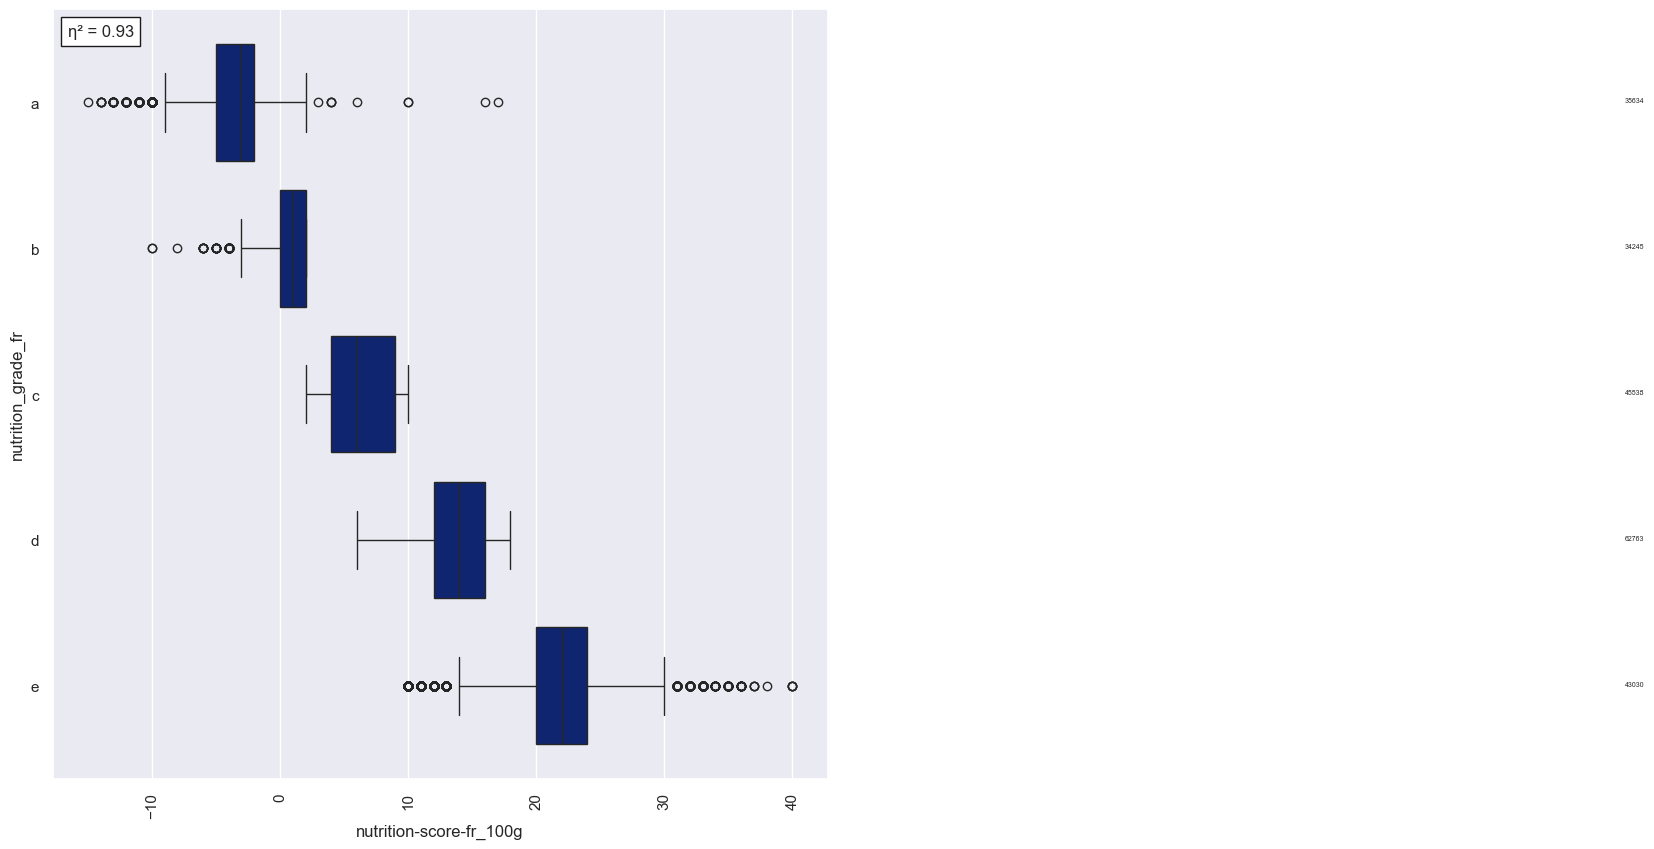

In [183]:
ANOVA(products, y="nutrition_grade_fr", x="nutrition-score-fr_100g", plot_function=sns.boxplot, order=products["nutrition-score-fr_100g"].groupby(products["nutrition_grade_fr"]).mean().sort_values().index, legend=None)

These boxplots clearly highlights the correlation between those 2 variables. For the rest of the analysis, only the numeric variable "nutrition-score-fr_100g" will be kept.

According to description of fields from the provided documentation :  

> "fields that end with _tags are comma separated list of tags (e.g. categories_tags is the set of normalized tags computed from the categories field)"

Therefore, when several columns contain the same data ("countries", "countries_tags" and "countries_fr" for example), the column wth suffix "_tags" will be preferred because it is normalized.

In [143]:
# Remove duplicated columns
columns_to_drop = [
    "image_small_url", # duplicate of image_url
    "additives_fr", # french duplicate of additives_tags
    "brands", # unstandardized duplicate of brands_tags
    "categories", # unstandardized duplicate of categories_tags
    "categories_fr", # french duplicate of categories_tags
    "countries", # unstandardized duplicate of countries_tags
    "countries_fr", # french duplicate of countries_tags
    "emb_codes", # unstandardized duplicate of emb_code_tags
    "labels", # unstandardized duplicate of labels_tags
    "labels_fr", # french duplicate of labels_tags
    "main_category_fr", # french duplicate of main_category
    "manufacturing_places", # unstandardized duplicate of manufacturing_places_tags
    "nutrition_grade_fr", # contains similar information as nutrition-score-fr_100g
    "origins", # unstandardized duplicate of origins_tags
    "packaging", # unstandardized duplicate of packaging_tags
    "pnns_groups_1", # contains same information as pnns_groups_2
    "states", # duplicate of states_tags
    "states_fr", # french duplicate of state_tags
    "traces", # unstandardized duplicate of traces_tags
    "traces_fr" # french duplicate of traces_tags
]

products.drop(columns=columns_to_drop, inplace=True)

_Note : Before droping those columns, verifications were made to be sure not to lose valuable information._

In [144]:
# Update products_info
products_info = get_df_variables_info(products)

This DataFrame has 320749 rows and 121 columns.


### Choosing the target

At first, we'll start by establishing the feasibility of suggesting missing values for one variable.  

Suggestions will be made using Machine Learning, and therefore it needs to be trained on a complete dataset.
Here are the steps to follow in order to prepare the training dataset.

1. Only keep products where the target is not missing. (Filter rows)
2. Drop duplicates.* (Filter rows)
3. Only keep relevant features to predict the target. (Filter columns)
4. Identify and handle extreme values properly.
5. Impute missing values.

The goal for the moment is simply to evaluate the feasibility of the project. Therefore, a variable with more than 50% values missing will be chosen.

\* About dropping duplicated products:
Here a product is considered duplicated if there is another product with 
- Same "product_name", "brands_tags", and "countries_tags"  
OR
- Same "code"

The duplicates with the least information (the most missing values) will be withdrawn.

In [145]:
# Visualize catetgory variables with at least 50% of missing values
products_info.loc[(products_info["column_type"] == "object") & (products_info["missing_value_percentage"] > 50)].dropna(axis=1, how='all').sort_values(by="missing_value_percentage", ascending=False)

column_type  \
ingredients_from_palm_oil_tags                  object   
ingredients_that_may_be_from_palm_oil_tags      object   
first_packaging_code_geo                        object   
cities_tags                                     object   
origins_tags                                    object   
traces_tags                                     object   
allergens                                       object   
emb_codes_tags                                  object   
manufacturing_places_tags                       object   
labels_tags                                     object   
stores                                          object   
generic_name                                    object   
purchase_places                                 object   
pnns_groups_2                                   object   
image_url                                       object   
packaging_tags                                  object   
main_category                                   object   
categories_tags                                 object   
quantity                                        object   
additives_tags                                  object   

                                            missing_value_percentage  \
ingredients_from_palm_oil_tags                                98.493   
ingredients_that_may_be_from_palm_oil_tags                    96.354   
first_packaging_code_geo                                      94.138   
cities_tags                                                   93.672   
origins_tags                                                  93.102   
traces_tags                                                   92.415   
allergens                                                     91.170   
emb_codes_tags                                                90.866   
manufacturing_places_tags                                     88.630   
labels_tags                                                   85.458   
stores                                                        83.882   
generic_name                                                  83.548   
purchase_places                                               81.865   
pnns_groups_2                                                 77.594   
image_url                                                     76.357   
packaging_tags                                                75.385   
main_category                                                 73.697   
categories_tags                                               73.690   
quantity                                                      67.342   
additives_tags                                                51.775   

                                            nbr_unique_values  \
ingredients_from_palm_oil_tags                             14   
ingredients_that_may_be_from_palm_oil_tags                160   
first_packaging_code_geo                                 1602   
cities_tags                                              2570   
origins_tags                                             4350   
traces_tags                                              3578   
allergens                                               12919   
emb_codes_tags                                           8156   
manufacturing_places_tags                                6734   
labels_tags                                             13653   
stores                                                   3252   
generic_name                                            38561   
purchase_places                                          5117   
pnns_groups_2                                              41   
image_url                                               75836   
packaging_tags                                          12059   
main_category                                            3543   
categories_tags                                         21142   
quantity                                                13807   
additives_t

The chosen target is "pnns_groups_2". It has 77.59% missing values and only 41 unique values.

### Filtering according to the target

- Only keep products for which we have data for the target.
- Only keep features with sufficient data
- Drop duplicates
- Remove redundant features

In [154]:
def filter_to_keep_relevant_features(df: pd.DataFrame, target:str, visualize:bool=False) -> pd.DataFrame:
    assert target != "code"

    # Remove products where there is no value for target variable
    filtered_products = df.dropna(subset=target)
    print(f"Only keeping products with non-null target ({target}) : {df.shape[0] - filtered_products.shape[0]} products removed.")

    # Remove the target from the dataset
    target_data = filtered_products[target]
    features_data = filtered_products.drop(columns=target)
    print(f"Separating target data from the rest of the data : column '{target}' removed.")

    # Define columns that will be irrelevant no matter what target is choosen.
    always_irrelevant_columns = [
       "last_modified_datetime", # No useful information for prediction
       "creator", # No useful information for prediction
       "url", # No useful information for prediction
       "last_modified_t", # No useful information for prediction
       "created_datetime",  # No useful information for prediction
       "created_t", # No useful information for prediction
       "image_url", # No useful information for prediction
       "states_tags", # No useful information for prediction
    ]
    features_data.drop(columns=always_irrelevant_columns, inplace=True)
    print(f"Removing {len(always_irrelevant_columns)} columns that won't be useful to predict any target : '{"', '".join(always_irrelevant_columns)}'.")

    # Only keep columns with sufficient data (over 50%)
    insufficient_data_columns = features_data.columns[features_data.notna().mean() < 0.5]
    features_data.drop(columns=insufficient_data_columns, inplace=True)
    print(f"Removing {len(insufficient_data_columns)} columns with insufficient data (less than 50%) : '{"', '".join(insufficient_data_columns)}'.")

    # Drop duplicates
    columns_used_drop_dups = ["product_name", "brands_tags", "countries_tags"]
    features_data["missing_count"] = features_data.isna().sum(axis=1) # Calculate number of missing values for each product
    features_data.sort_values(by="missing_count", ascending=True, inplace=True) # Put products with the least missing values at the top
    features_data_without_dups = features_data.drop_duplicates(subset="code", keep='first') # Remove duplicates but keep the first one (the one with the least missing values)
    features_data_without_dups = features_data_without_dups.drop_duplicates(subset=[c for c in columns_used_drop_dups if c in features_data], keep='first') # Remove duplicates but keep the first one (the one with the least missing values)
    features_data_without_dups = features_data_without_dups.drop(columns=["code", "missing_count"])
    print(f"Removing {features_data.shape[0] - features_data_without_dups.shape[0]} duplicated products.")

    if visualize:
      msno.bar(features_data, sort="ascending")

    return target_data, features_data_without_dups

Only keeping products with non-null target (pnns_groups_2) : 248882 products removed.
Separating target data from the rest of the data : column 'pnns_groups_2' removed.
Removing 8 columns that won't be useful to predict any target : 'last_modified_datetime', 'creator', 'url', 'last_modified_t', 'created_datetime', 'created_t', 'image_url', 'states_tags'.
Removing 85 columns with insufficient data (less than 50%) : 'origins_tags', 'manufacturing_places_tags', 'emb_codes_tags', 'first_packaging_code_geo', 'cities_tags', 'allergens', 'traces_tags', 'serving_size', 'additives_tags', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_tags', 'energy-from-fat_100g', 'caprylic-acid_100g', 'capric-acid_100g', 'lauric-acid_100g', 'myristic-acid_100g', 'palmitic-acid_100g', 'stearic-acid_100g', 'arachidic-acid_100g', 'montanic-acid_100g', 'monounsaturated-fat_100g', 'polyunsaturated-fat_100g', 'omega-3-fat_100g', 'alpha-linolenic-acid_100g', 'eicosapentaenoic-acid_100g', 'do

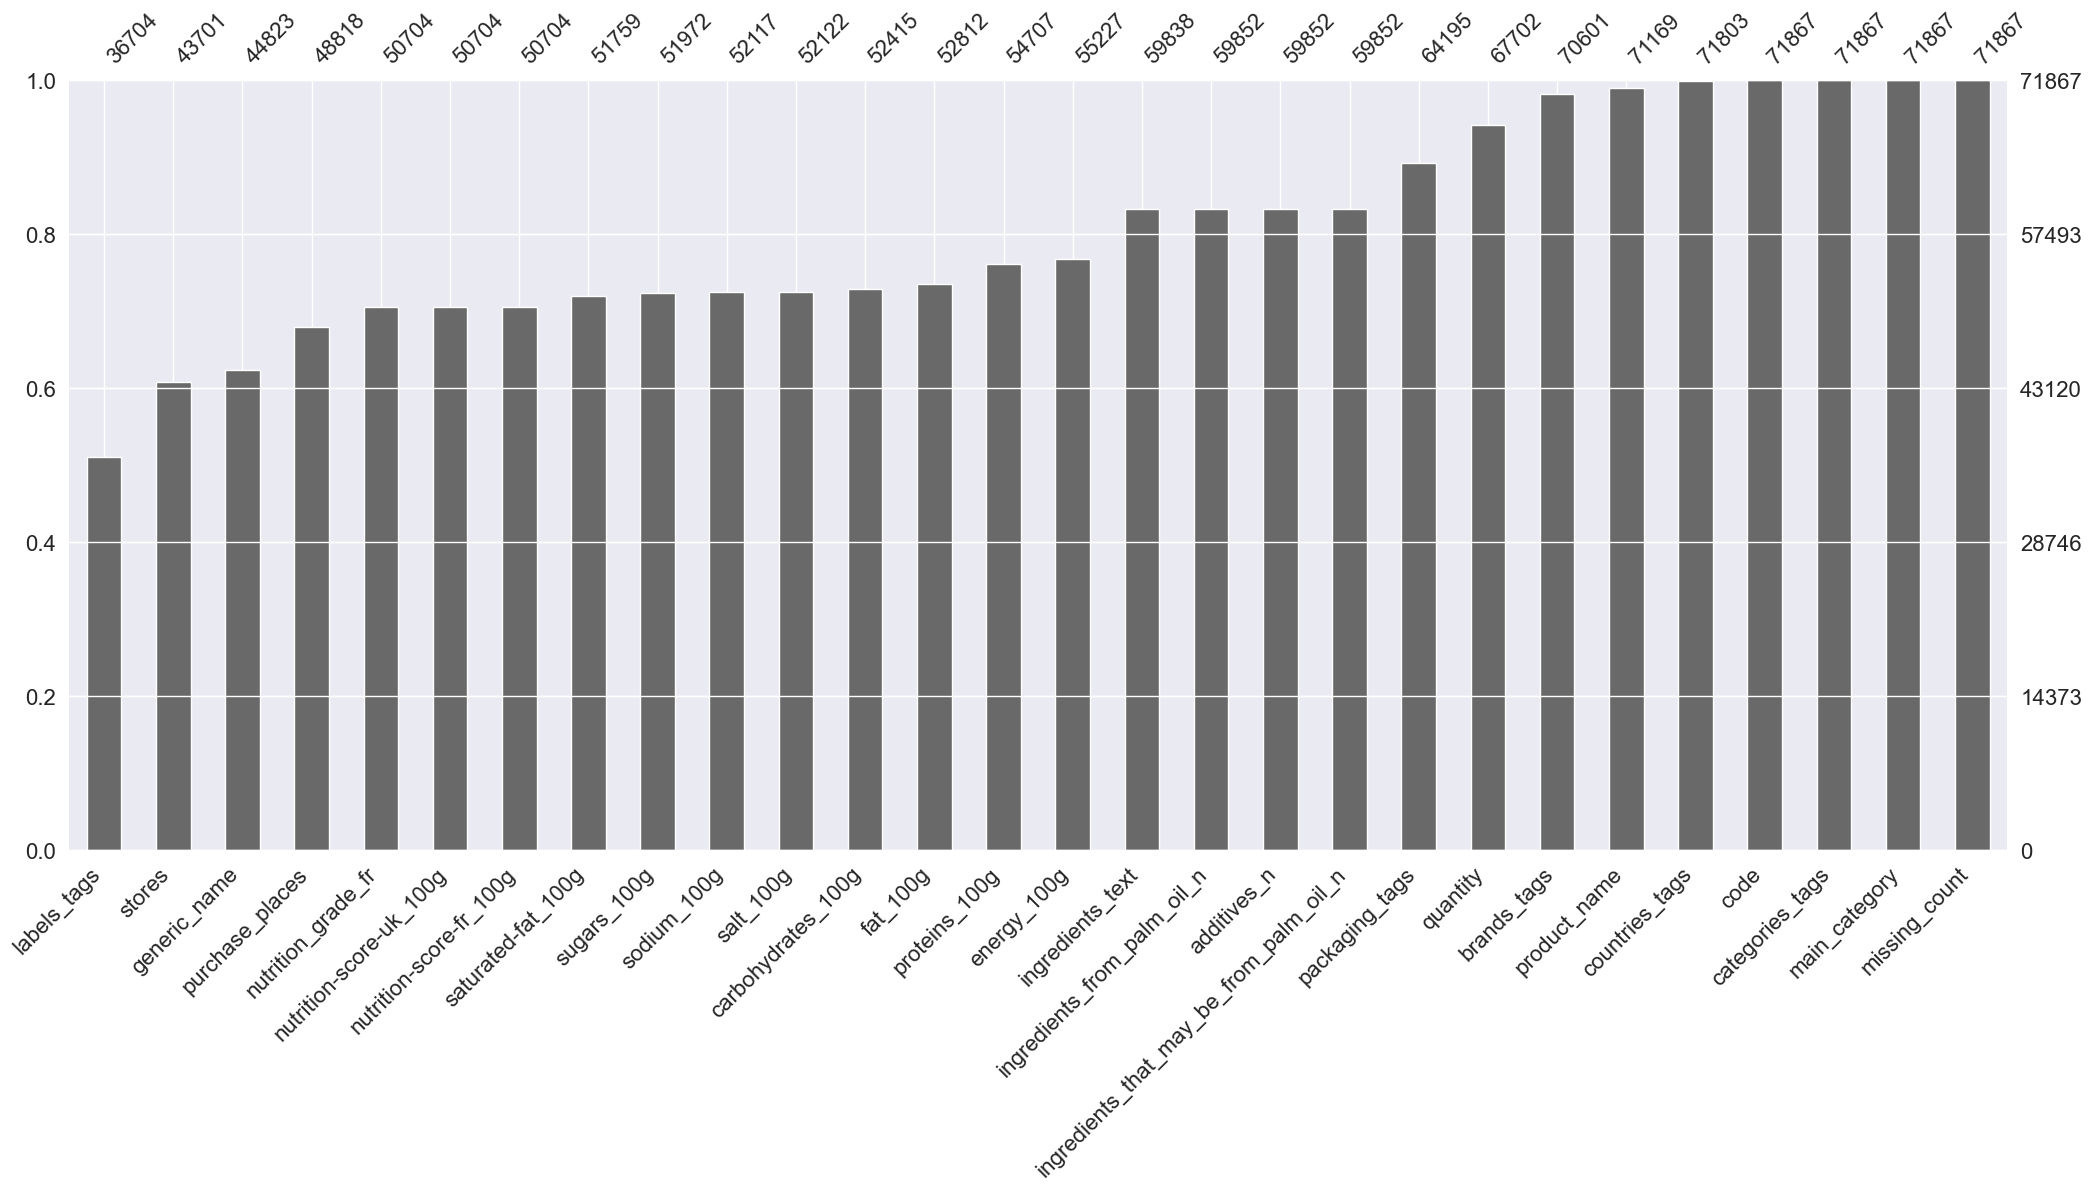

In [155]:
target_data, filtered_data = filter_to_keep_relevant_features(df=products, target="pnns_groups_2", visualize=True)

In [ ]:
manual_drop = ["quantity", "purchase_places", "stores"] # No useful information for prediction and poorly filled
filtered_data.drop(columns=manual_drop, inplace=True)

_Note : There might still be some columns which are strongly correlated with each other. These columns will be used later, after removing outliers, to predict some values if possible._

In [160]:
LISTLIKE_COLS = ["countries_tags", "packaging_tags", "brands_tags", "categories_tags", "labels_tags", "stores", "ingredients_text"]
NUTRIENTS_COLS =  ['proteins_100g', 'sugars_100g', 'carbohydrates_100g', 'saturated-fat_100g', 'fat_100g', 'sodium_100g']

## Values normalization and mapping

### Mapping CSV creation

Some columns contain different values that should be considered equal.

In [161]:
def remove_diacritics(s):
    ''' 
    Removes accents
    '''
    return ''.join(c for c in unicodedata.normalize('NFKD', s) if not unicodedata.combining(c))

def remove_language_indicator(s):
    # Remove 2-letter language indicator
    match = re.match(r'\w{2}:(.*)', s)
    if match:
        return match.group(1)
    
    return s

def replace_non_words_char_by_space(s):
    # Remove non words characters
    return re.sub(r'[^\w\s]', ' ', s, flags=re.UNICODE)

In [162]:
def normalizeString(s:str):
    s = remove_language_indicator(s)
    s = replace_non_words_char_by_space(s)
    s = s.replace('_', '')
    s = remove_diacritics(s) # Remove accents
    s = ' '.join(s.split()) # replace multiple whitespaces with only 1 whitespace

    return s.lower()

In [163]:
def normalizeIngredients(s:str):
    s = remove_language_indicator(s)

    # if there's a column (':') a string, only keep what's after the first column.
    if ':' in s:
      parts = s.split(':', maxsplit=1)
      s = parts[1]
      if normalizeString(s) == "": # If there's nothing interesting after the ":", keep the part before the ":"
         s = parts[0]

    s = replace_non_words_char_by_space(s)
    s = s.replace('_', '')
    s = remove_diacritics(s) # Remove accents
    s = ' '.join(s.split()) # trim and replace multiple whitespaces with only 1 whitespace
    
    return s.lower()

In [164]:
def preprocess_ingredients(s:str):
  # Remove percentages, making sure that the most cases are covered
  if isinstance(s, str):
    return re.sub(r'(?:\d|l)+(?:[\.,](?:\d|l)+)?(?:[^\w]|\s|_)*%', '', s, flags=re.UNICODE)
  return s

In [165]:
timeout=Timeout(10.0)
translator = Translator(user_agent="DS-3", timeout=timeout)

geolocator = Nominatim(user_agent="DS-3", timeout=5)
geocode = partial(geolocator.geocode, language="en")

In [166]:
def getCountry(string:str, compute_type:Literal["safe","raw"]='safe', geocode:partial=geocode):
    '''
    Parameters:
    string (str) : initial string from which country should be determined
    compute_type (str) : Can be "safe" or "raw". 
        "safe" : First considers that "string" is a country ('US' for example), if no result it considers that "string" is a state or a county ('Great Britain' for example), then it considers
            it as a city ('Marseille' for example)
        "raw" : "string" can be anything (a street, a part of an adress or a building for example). This gives result more often but can be less accurate
    geocode (partial) : partial instance to use as geocode

    Returns :
    '''
    
    granularities = ['country', 'state', 'county', 'city']
    if compute_type == 'raw':
        result = geocode(string)
        if result is not None and len(result) > 0:
            importance = float(result.raw["importance"])
            country = result[0].split(', ')[-1]
            
            return (country, importance)
    
    else:
        for g in granularities:
            result = geocode({g:string})
            if result is not None and len(result) > 0:
                importance = float(result.raw["importance"])
                country = result[0].split(', ')[-1]
                
                return (country, importance)

    return None, 0

In [167]:
def isUnique(s):
    '''
    Parameters:
    s (pd.Series) : Series for which we want to check if all the values are the same

    Returns : The unique value of the series or False if there are different values
    '''
    a = s.to_numpy()
    if (len(a) > 0) and (a[0] == a).all():
        return a[0]
    return False

In [168]:
def normalizeCountry(s:str, translator:Translator=translator):
    '''
    This function definitely lacks efficiency (takes about 9 minutes). It assigns an existing country to most of the unique values in "countries_tags" columns.  
    It uses 'googletrans' library to translate and 'geopy' to determine the corresponding country.

    It reduces the amount of uninque values (from 267 to 145)
    In the future, the best would be to limit users who add new products in the database by only allowing them to choose among a list of given countries / options. 
    '''
    print(s)
    splitted_s = remove_language_indicator(s)
    formatted_s = normalizeString(splitted_s)
    formatted_s = re.sub(r'\d', '', formatted_s).strip()
    translated_s = translator.translate(formatted_s).text
    
    suggestions_df = pd.DataFrame(
        {'raw':getCountry(splitted_s, compute_type='raw'), 
         'formatted':getCountry(formatted_s), 
         'translated':getCountry(translated_s)
        }, 
        index=['suggestion', 'importance']
        ).transpose()

    unique_v = isUnique(suggestions_df["suggestion"])
    if unique_v:
        return unique_v
    
    unique_probable_v = isUnique(suggestions_df.loc[suggestions_df["importance"] > 0.85, "suggestion"])
    if unique_probable_v:
        return unique_probable_v
    
    suggestions_df = suggestions_df.sort_values(by="importance", ascending=False)
    return f'({", ".join(suggestions_df["suggestion"].dropna().unique())})'


In [169]:
def complete_countries_mapping(df:pd.DataFrame):
    df.loc[df["initial"] == "en:soviet-union", 'formatted'] = "Russia"
    df.loc[df["initial"] == "other-العراق", 'formatted'] = "Iraq"
    df.loc[df["initial"] == "en:gulf-countries", 'formatted'] = "United Arab Emirates"
    df.loc[df["initial"] == "en:republique-de-chine", 'formatted'] = "China"
    df.loc[df["initial"] == "other-turquie", 'formatted'] = "Turkey"

    united_kingdom = ["es:nagy-britannia", "fr:nagy-britannia"]
    df.loc[df["initial"].isin(united_kingdom), 'formatted'] = "United Kingdom"

    japan = ["other-japon", "en:other-日本", "other-日本"]
    df.loc[df["initial"].isin(japan), 'formatted'] = "Japan"

    france = ["fr:bourgogne-aube-nogent-sur-seine", "fr:bouches-du-rhone", "fr:77-provins"]
    df.loc[df["initial"].isin(france), 'formatted'] = "France"

    # Add "World" option
    world = ["en:world", "en:worldwide", "de:weltweit", "en:global-market", "en:all-over-the-world"]
    df.loc[df["initial"].isin(world), 'formatted'] = "World"

    # Add "Europe" option
    europe = ["en:european-union"]
    df.loc[df["initial"].isin(europe), 'formatted'] = "Europe"

    # Set remaining NaN values to empty string
    df.loc[df["formatted"].isna(), 'formatted'] = ""

    return df

In [170]:
def complete_labels_mapping(df:pd.DataFrame):
    df.loc[df["initial"] == "en:ⓜ", "formatted"] = "ⓜ"
    df.loc[df["initial"] == "en:℮", "formatted"] = "℮"
    df.loc[df["initial"] == "de:℮", "formatted"] = "℮"
    
    return df

In [171]:
def get_chunks(arr, size:int):
    '''
    Split an array-like object in chunks of given size.

    Parameters:
    arr (Any): Array-like object to split in chunks.
    size (int): Maximum size of the chunks.

    Returns:
    tuple(arr): Tuple containing the chunks.
    '''
    return (arr[pos:pos + size] for pos in range(0, len(arr), size))

In [172]:
# Compute parallel pairwise distance matrix
def compute_parallel_distance_matrix(X, Y, metric:Callable, **kwargs):

  # Split data into chunks
  n_chunks = min(100, len(X))
  chunks = np.array_split(X, n_chunks)

  # Parallel computation
  distance_matrix = Parallel(n_jobs=-1)(
      delayed(pairwise_distances)(chunk, Y, metric=metric, force_all_finite="allow-nan", **kwargs) for chunk in chunks
  )

  return np.vstack(distance_matrix)

In [173]:
def group_similar_values(value_counts: pd.Series, metric:Callable, threshold:int, **kwargs) -> pd.Series:
    """
    Groups similar strings in a Pandas Series by clustering based on fuzzy string matching.

    Parameters:
    - unique_values (pd.Series): Column with string unique values to clean.
    - threshold (int): Similarity threshold for grouping (0-100). Higher values mean stricter matching.

    Returns:
    - pd.Series: Series with values replaced by their representative group values.
    """   
    unique_values = value_counts.index
    print(f"This Series contains {len(unique_values)} unique values.")
    
    # Compute parallel pairwise distance matrix
    distance_matrix = compute_parallel_distance_matrix(unique_values, unique_values, metric=metric, **kwargs)
    
    # Clustering with DBSCAN
    clustering = DBSCAN(
        eps=threshold,
        min_samples=1,
        metric="precomputed"
    ).fit(distance_matrix)
    
    # Map each cluster to its most frequent string
    labels = clustering.labels_
    
    cluster_map = {}
    for label in set(labels):
        members = [unique_values[i] for i in range(len(labels)) if labels[i] == label]
        
        # Determine the most frequent string in the cluster
        members_value_counts = dict((k,value_counts.get(k, 0)) for k in members)
        most_frequent = max(members_value_counts,  key=members_value_counts.get)
        
        # Map all members of the cluster to the most frequent string
        cluster_map.update({member: most_frequent for member in members})

        if len(members) > 1:
            print(members)

    
    # Replace values in the original series
    return cluster_map

In [174]:
def calculate_distance_between_groups(group1:str, group2:str, feature_name:str="main_category", df:pd.DataFrame=filtered_data.dropna(subset=NUTRIENTS_COLS), cols:list[str]=NUTRIENTS_COLS, max_distance:float=math.sqrt(len(NUTRIENTS_COLS)*100**2)):   
    if group1 == group2:
        return 0
    df_filtered = df[df[feature_name].isin([group1, group2])]
    medians = df_filtered.groupby(feature_name)[cols].median().loc[[group1, group2]]
    medians_difference = medians.loc[group1] - medians.loc[group2]

    return np.linalg.norm(medians_difference)/max_distance*100 # normalize the distance between 0 and 100

In [175]:
class FeatureToNormalizeAndMap():

    def __init__(
            self, 
            name:str, 
            preprocessing: Optional[list[Callable]] = None,
            normalize_method:Callable = normalizeString, 
            cluster_method:Callable = partial(group_similar_values, metric=lambda s1, s2: 100-fuzz.ratio(s1, s2), threshold=10),
            possible_sep:Optional[list[re.Pattern]]=[","],
            after_mapping_adjustements:Optional[list[Callable]] = None
    ):
        self._name = name
        self._preprocessing = preprocessing
        self._normalize_method = normalize_method
        self._cluster_method = cluster_method
        self._possible_sep = None
        if self._name in LISTLIKE_COLS:
            self._possible_sep = possible_sep
        self._after_mapping_adjustements = after_mapping_adjustements

In [176]:
features_to_normalize_and_map = [
    FeatureToNormalizeAndMap(name="countries_tags", normalize_method=normalizeCountry, cluster_method=None, after_mapping_adjustements=[complete_countries_mapping]),
    FeatureToNormalizeAndMap(name="packaging_tags"),
    FeatureToNormalizeAndMap(name="brands_tags"),
    FeatureToNormalizeAndMap(name="categories_tags"),
    FeatureToNormalizeAndMap(name="labels_tags", after_mapping_adjustements=[complete_labels_mapping]),
    FeatureToNormalizeAndMap(name="main_category", normalize_method=None, cluster_method=partial(group_similar_values, threshold=1, metric=calculate_distance_between_groups)),
    FeatureToNormalizeAndMap(name="ingredients_text", preprocessing=[preprocess_ingredients], normalize_method=normalizeIngredients, possible_sep=[",", r"\(", r"\)", r"\[", r"\]", r"\.", ";", r"[^\w]-[^\w]", r"[^\w]·[^\w]", r"[^\w]—[^\w]"])
]

In [309]:
def create_mapping_csv(feature:FeatureToNormalizeAndMap, df:pd.DataFrame):
  MAX_UNIQUE_VALUES = 40000 # From 50 000 distinct values in the Series, there is a risk to reach the maximum memory on the used computer (32 Go)

  print(f"{'*'*30}\n{feature._name}")
  
  # Get initial unique values
  initial = df[feature._name].copy()

  if feature._preprocessing is not None:
    for f in feature._preprocessing:
      initial = initial.apply(f)
      
  if feature._name in LISTLIKE_COLS:
    sep_pattern = '|'.join(sorted(list(set(feature._possible_sep)-set(',')))) # sorting the list to get consistent results
    if sep_pattern != '':
      initial = initial.apply(lambda s: re.sub(sep_pattern, ",", s, flags=re.UNICODE) if isinstance(s, str) else s)
    initial = initial.str.split(',').explode()
  unique_initial = pd.Series(initial.dropna(ignore_index=True).unique())
  mapping_df = pd.DataFrame(data={"initial":unique_initial})
  
  if feature._normalize_method is not None:
    normalized = mapping_df["initial"].apply(feature._normalize_method)
    mapping_df["normalized"] = normalized
  else:
    mapping_df["normalized"] = mapping_df["initial"]
  
  # Get unique normalized values and their count
  intermediate_mapping_dict = dict(zip(mapping_df["initial"], mapping_df["normalized"]))
  # Here mapping is necessary to get the count of total values in "initial" Series, and not only the unique values.
  value_counts = initial.map(intermediate_mapping_dict).value_counts(sort=False) # Do not sort because chunks wouldn't be "randomly" built later.

  # Group similar values together
  if feature._cluster_method is not None:
    clustered = {}
    for chunk in get_chunks(value_counts, size=MAX_UNIQUE_VALUES):
      clustered.update(feature._cluster_method(value_counts=chunk))
    mapping_df["clustered"] = mapping_df["normalized"].map(clustered)
  else:
    mapping_df["clustered"] = mapping_df["normalized"]
  mapping_df.to_csv(f"mapping/{feature._name}.csv")

In [310]:
# for feature in features_to_normalize_and_map:
#     create_mapping_csv(feature=feature, df=filtered_data)

******************************
main_category
This Series contains 134 unique values.
['en:fresh-vegetables', 'en:soups', 'en:mushrooms', 'en:tomatoes', 'en:vegetable-rods', 'en:pickles']
['en:poultries', 'en:hams', 'fr:jambons-de-paris', 'en:products-with-reduced-salt']
['en:teas', 'en:waters', 'en:diet-sodas', 'en:green-teas', 'en:herbal-teas']
['en:sodas', 'en:fruit-sodas', 'en:fruits', 'en:beverages', 'en:fruit-juices', 'en:carbonated-drinks', 'en:grapefruit-juices', 'en:apple-juices', 'en:concentrated-orange-juices', 'en:orange-juices', 'en:squeezed-orange-juices', 'en:fruit-nectars', 'en:concentrated-fruit-juices', 'en:squeezed-juices', 'en:fruit-juices-and-nectars', 'fr:compotes-pour-bebe']
['en:chocolates', 'fr:tablettes-de-chocolat']
['en:canned-foods', 'en:baby-foods', 'fr:purees']
['en:cow-cheeses', 'en:labeled-products', 'en:french-cheeses']
['en:pastas', 'fr:coquillettes']
['en:crustaceans', 'en:fish-and-meat-and-eggs']
['en:sausages', 'fr:charcuteries-diverses']
['en:fruit

### Values mapping

In [210]:
def map_values_list_like_col(series:pd.Series, mapping_filename:str, special_treatment:Optional[list[Callable]]=None):
    df = pd.read_csv(mapping_filename, index_col=0)
    assert ('initial' in df) and ('clustered' in df)
    
    if special_treatment is not None:
      for f in special_treatment:
          df = f(df)

    mapping_dict = df.set_index('initial')['clustered'].to_dict()

    initial_values = [[s for s in set(v.split(',')) if re.match(r'\w', s, flags=re.UNICODE)] if isinstance(v, str) else np.nan for v in series]

    mapped_series = [','.join(set([mapping_dict[v] for v in values if pd.notna(mapping_dict[v])])) if isinstance(values, list) else np.nan for values in initial_values]

    return mapped_series

In [211]:
def map_values(feature:FeatureToNormalizeAndMap, df:pd.DataFrame):
  print(f"{'*'*30}\n{feature._name}")
    
  series = df[feature._name].copy()

  if feature._preprocessing is not None:
    for f in feature._preprocessing:
      series = series.apply(f)
      
  if feature._name in LISTLIKE_COLS:
    sep_pattern = '|'.join(sorted(list(set(feature._possible_sep)-set(','))))
    if sep_pattern != '':
      series = series.apply(lambda s: re.sub(sep_pattern, ",", s, flags=re.UNICODE) if isinstance(s, str) else s)
    return map_values_list_like_col(series, mapping_filename=f"mapping/{feature._name}.csv", special_treatment=feature._after_mapping_adjustements)
  else:
    df = pd.read_csv(f"mapping/{feature._name}.csv", index_col=0)
    mapping_dict = dict(zip(df["initial"], df["clustered"])) 
    return series.map(mapping_dict)

In [311]:
for feature in features_to_normalize_and_map:
    filtered_data[feature._name] = map_values(feature, df=filtered_data)

******************************
main_category


In [312]:
filtered_data_info = get_df_variables_info(filtered_data)

This DataFrame has 69045 rows and 24 columns.


## Outliers detection and handling

### Using logical value domain

Some variables have predetermined domain out of which values cannot be.  
For example all nutrients per 100g should be between 0g and 100g. 

In [505]:
exceptions = ["energy_100g", "nutrition-score-uk_100g"]
features_domain_0_100 = filtered_data.columns[filtered_data.columns.str.endswith("_100g") & ~filtered_data.columns.isin(exceptions)]

outliers_domain = filtered_data.loc[
    (filtered_data[NUTRIENTS_COLS] < 0).any(axis=1) | 
    (filtered_data[NUTRIENTS_COLS] > 100).any(axis=1) | 
    (filtered_data["sodium_100g"] > 40)
    ]

# with pd.option_context('display.max_columns', None):
#     display(outliers_domain)

There are very few of those outliers and it is most likely due to human errors. Let's set the incoherent values to NaN for the moment.

In [ ]:
filtered_data[NUTRIENTS_COLS] = filtered_data[NUTRIENTS_COLS].where((filtered_data[NUTRIENTS_COLS].values > 0) & (filtered_data[NUTRIENTS_COLS].values < 100), np.nan)
filtered_data.loc[filtered_data["sodium_100g"]>40, "sodium_100g"] = np.nan  # There can be only 40g of sodium for 100g of salt so let's set 40 as the maximum amount of sodium

ValueError: operands could not be broadcast together with shapes (69045,6) (69045,) 

### Using other logic

Sum of carbohydrates, proteins and fat content needs to be lower than 100g for 100g of food. Let's up it to 103 in case of rounded values.

In [223]:
macros_nutrients = ["carbohydrates_100g", "proteins_100g", "fat_100g"]
outliers_sum_macros_logic = filtered_data.loc[filtered_data[macros_nutrients].sum(axis=1) > 103] # 103 instead of 100 because it seems nutrients can be rounded up to the next integer
# outliers_sum_macros_logic.head()

In [314]:
filtered_data.loc[filtered_data[macros_nutrients].sum(axis=1) > 103, macros_nutrients] = np.nan

Sugars content needs to be lower than carbohydrates content.

In [221]:
outliers_sugars_carbo_logic = filtered_data.loc[filtered_data["sugars_100g"] > filtered_data["carbohydrates_100g"]]
# with pd.option_context('display.max_columns', None):
#     display(outliers_sugars_carbo_logic)

In [222]:
filtered_data.loc[filtered_data["sugars_100g"] > filtered_data["carbohydrates_100g"], "sugars_100g"] = filtered_data["carbohydrates_100g"]

Saturated fats content needs to be lower than fats content.

In [225]:
outliers_satfat_fat_logic = filtered_data.loc[filtered_data["saturated-fat_100g"] > filtered_data["fat_100g"]]
# outliers_satfat_fat_logic

In [226]:
filtered_data.loc[filtered_data["saturated-fat_100g"] > filtered_data["fat_100g"], "saturated-fat_100g"] = filtered_data["fat_100g"]

### Using IQR rule

In [1]:
def identify_outliers_iqr(df:pd.DataFrame, categorical_col:str, numeric_cols:list[str], factor:float=1.5):

    for col in numeric_cols:
        # sub_df = df.dropna(subset=[col])
        # Calculate Q1, Q3, and IQR
        q1 = df.groupby(categorical_col)[col].quantile(0.25)
        q3 = df.groupby(categorical_col)[col].quantile(0.75)
        iqr = q3 - q1

        # Calculate bounds
        lower_bound = q1 - factor * iqr - 10
        upper_bound = q3 + factor * iqr + 10

        # Map lower and upper bounds to the sub_df
        df['lower_bound'] = df[categorical_col].map(lower_bound)
        df['upper_bound'] = df[categorical_col].map(upper_bound)
        
        # Create a DataFrame to flag outliers
        df['is_outlier'] = (df[col] < df['lower_bound']) | (df[col] > df['upper_bound'])

        # Create the strip plot
        fig, ax = plt.subplots(figsize=(10, 20))
        sns.boxplot(data=df[~df['is_outlier']], y='main_category', x=col, color='blue', ax=ax)
        sns.stripplot(data=df[df['is_outlier']], y='main_category', x=col, color='red', jitter=False, ax=ax)

NameError: name 'pd' is not defined

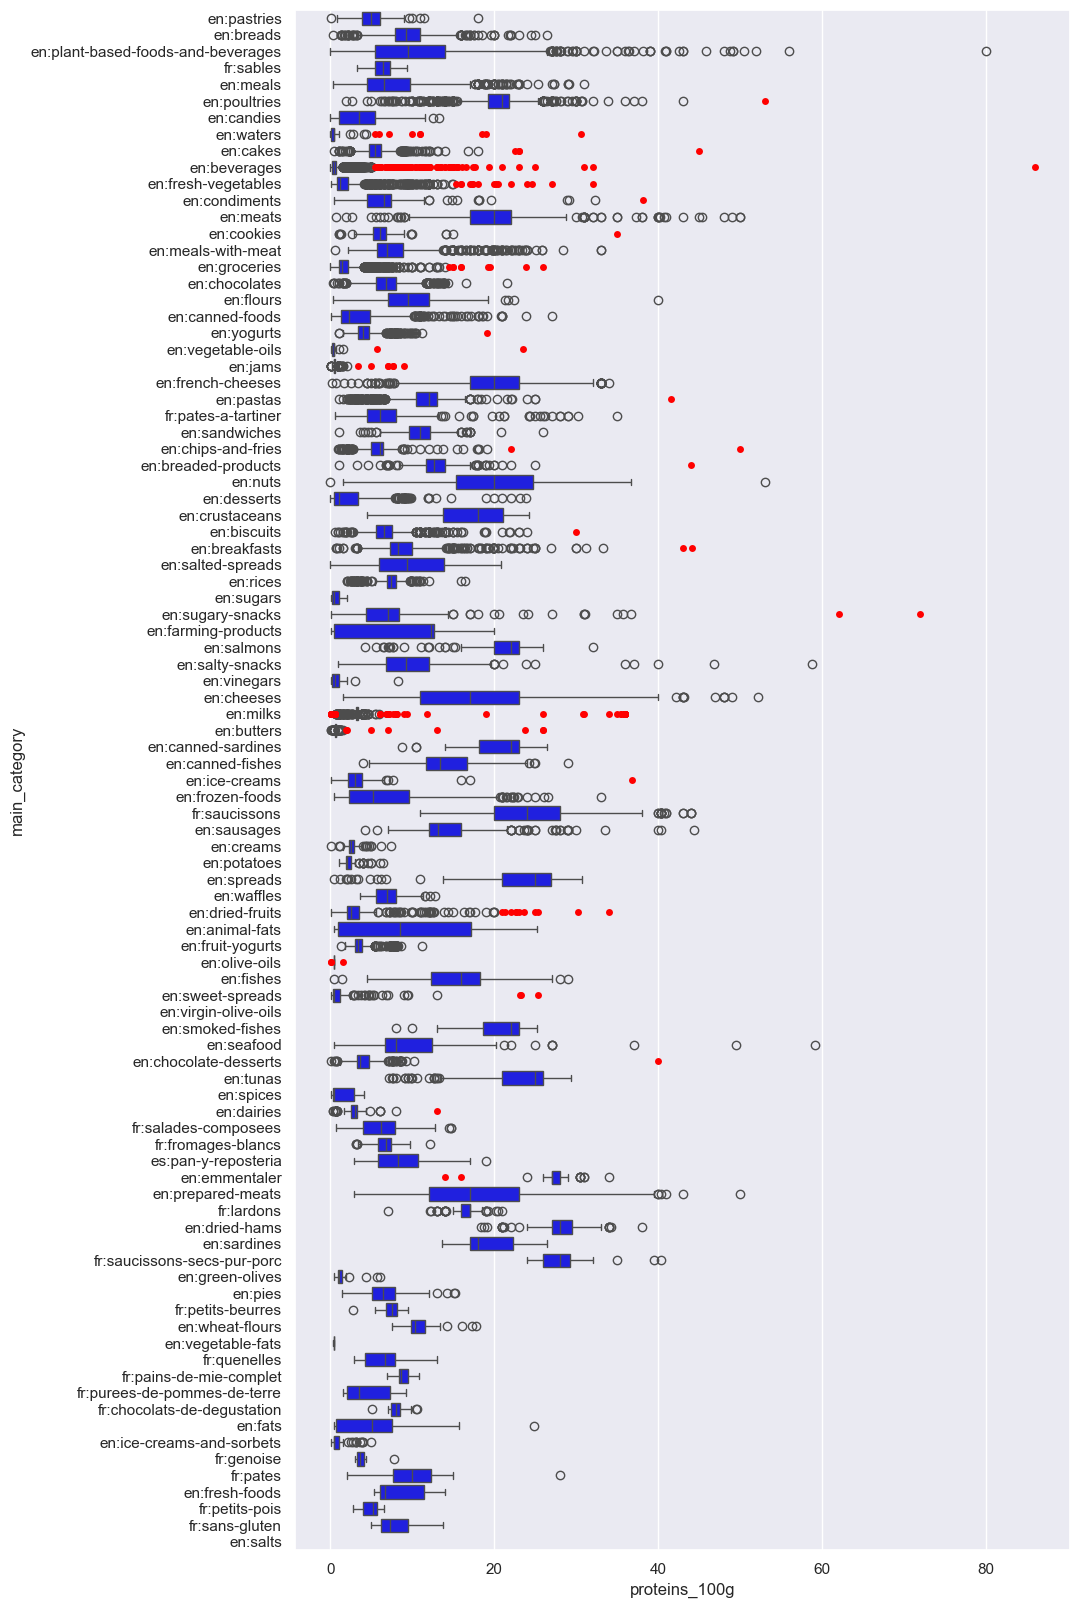

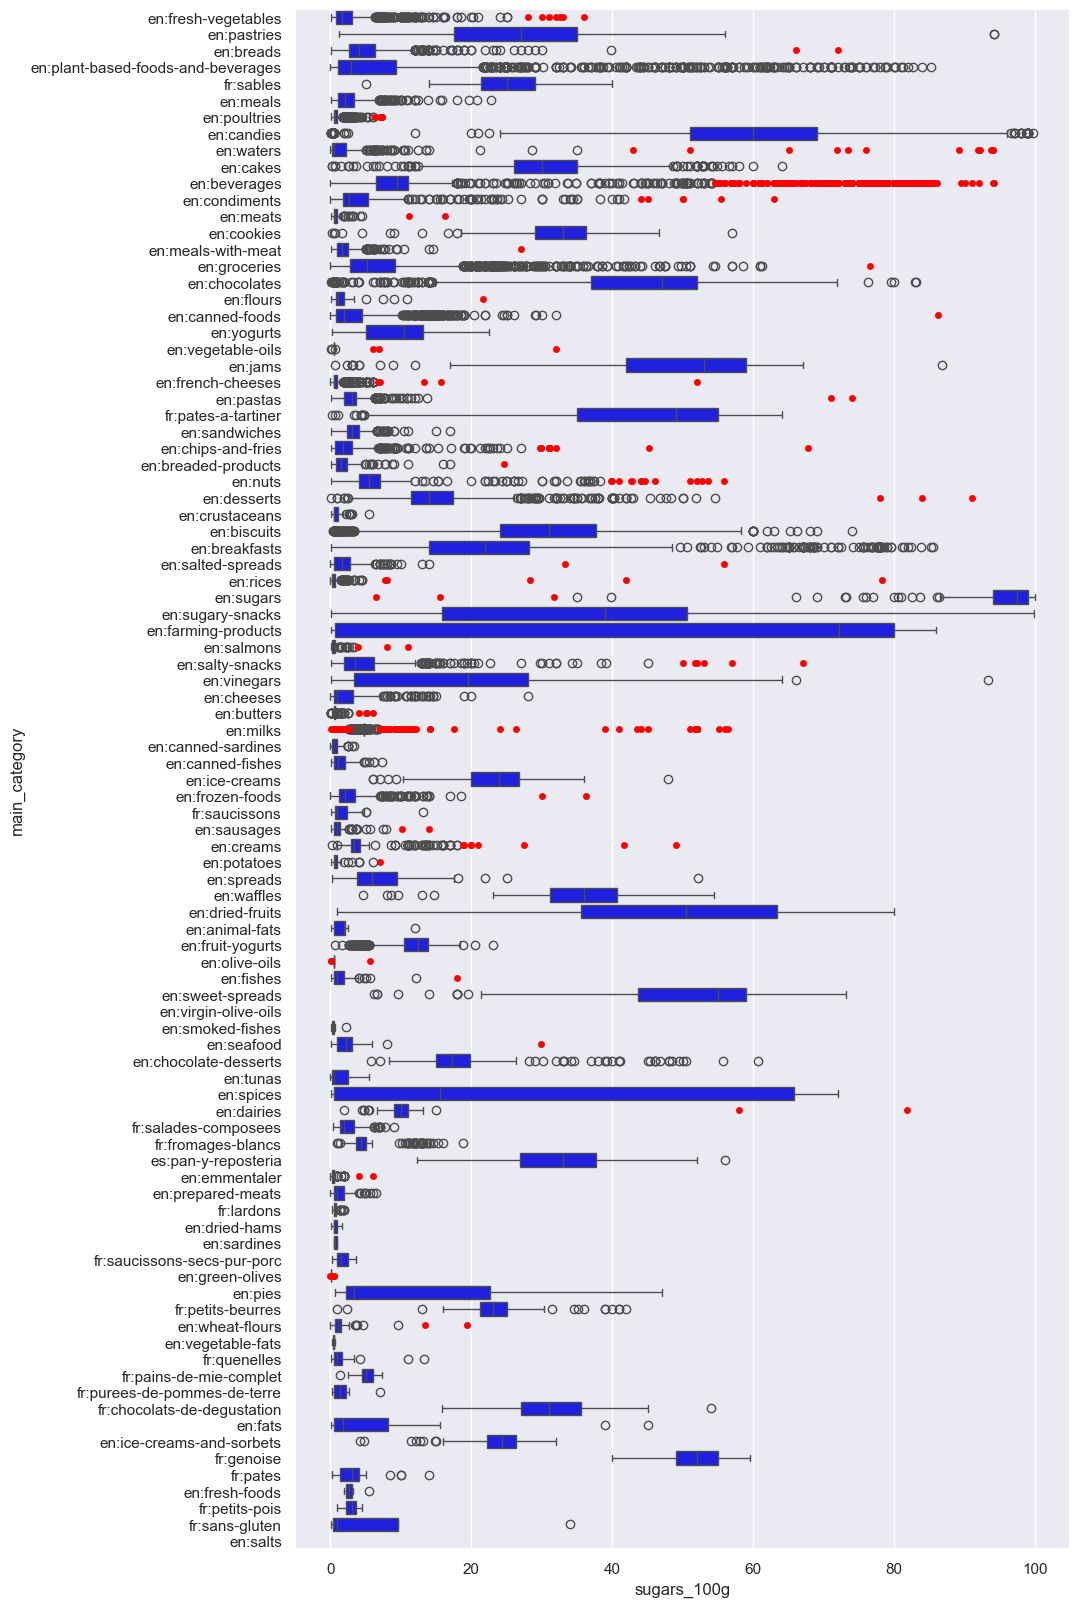

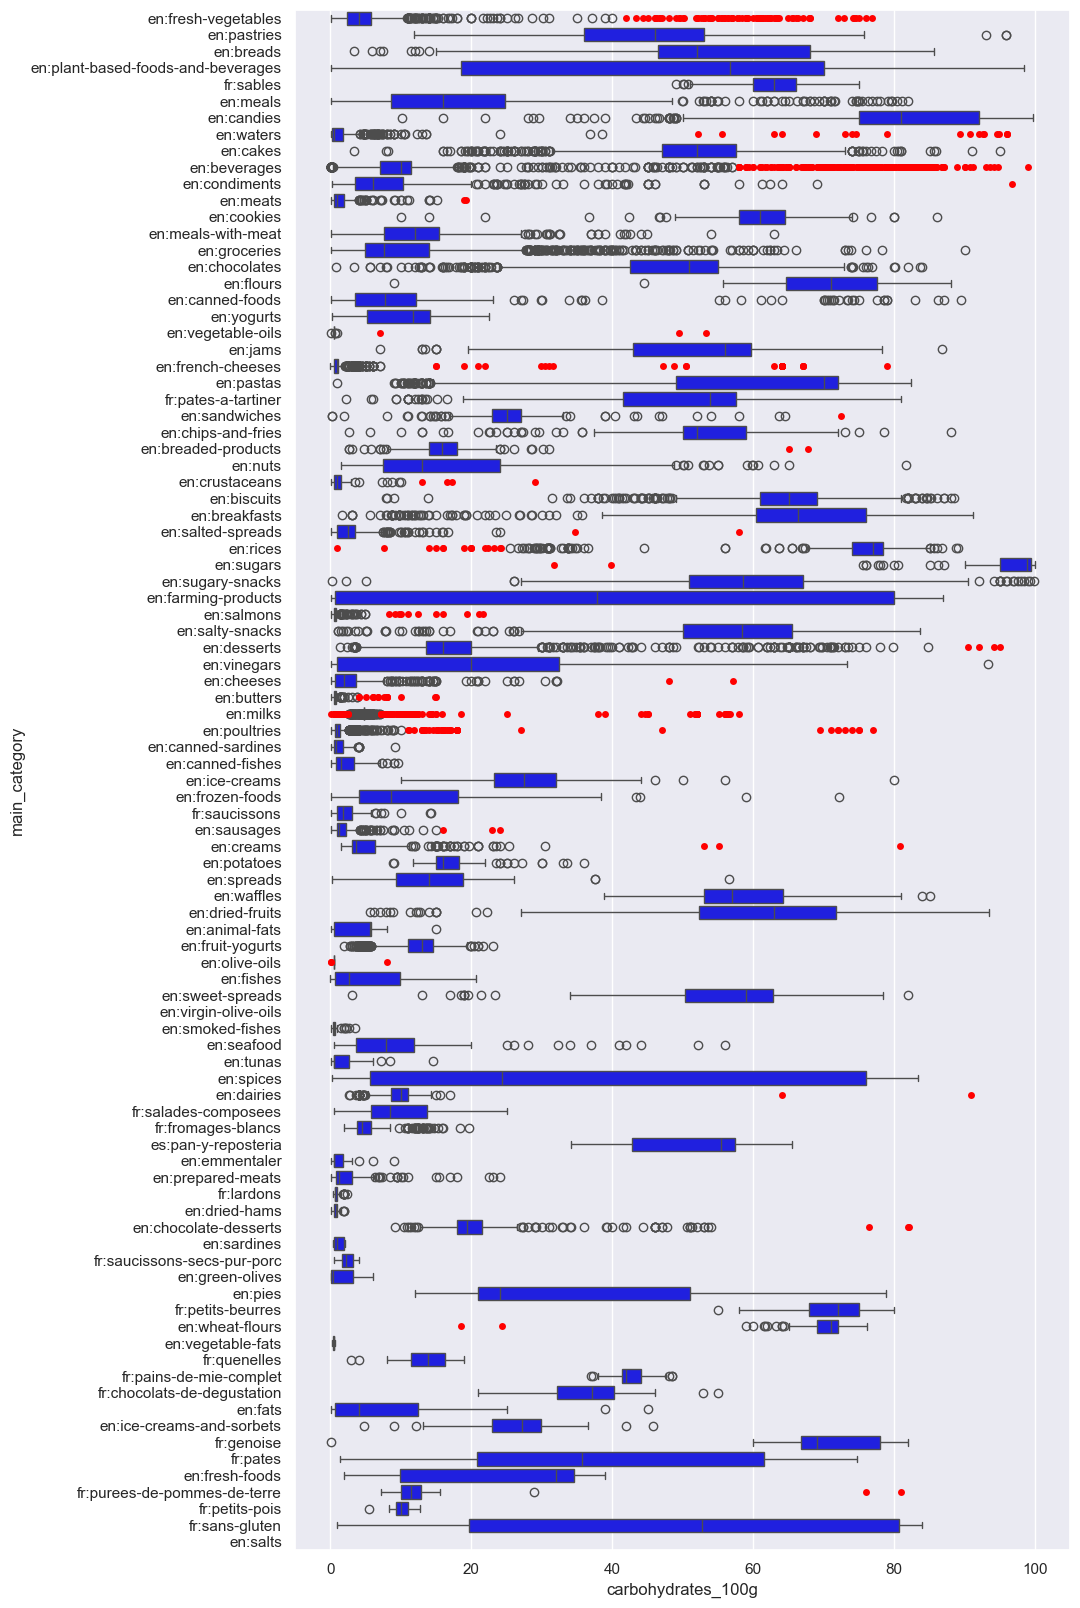

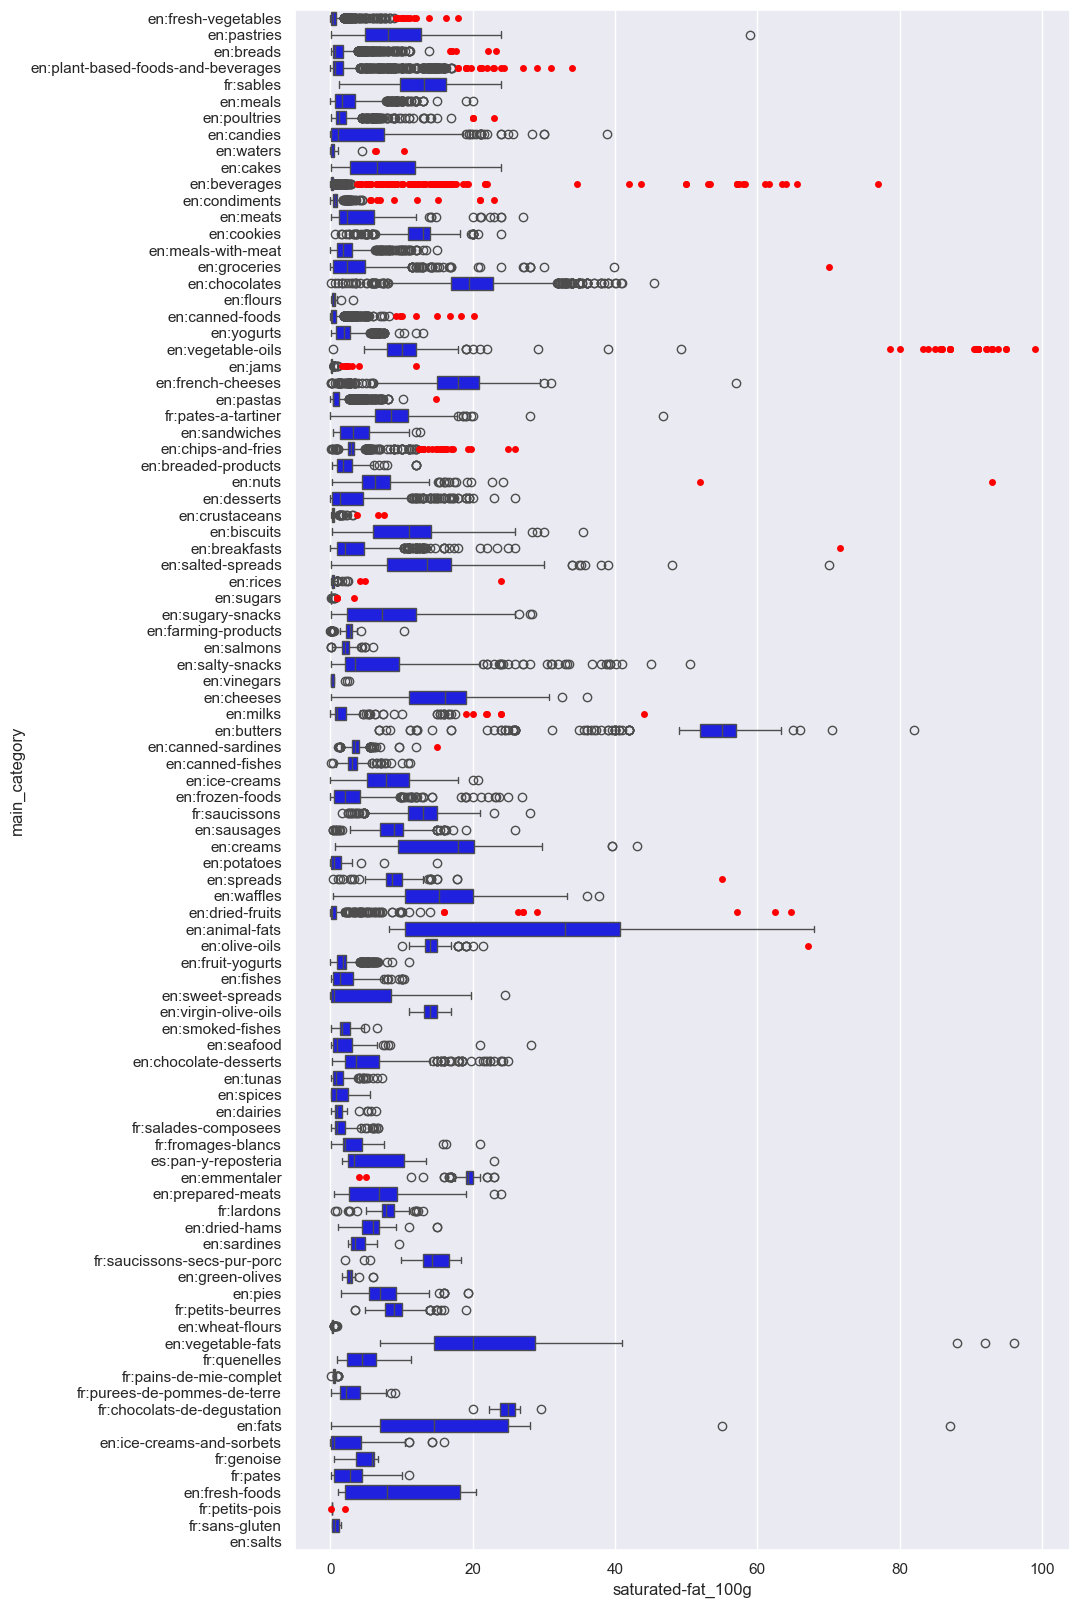

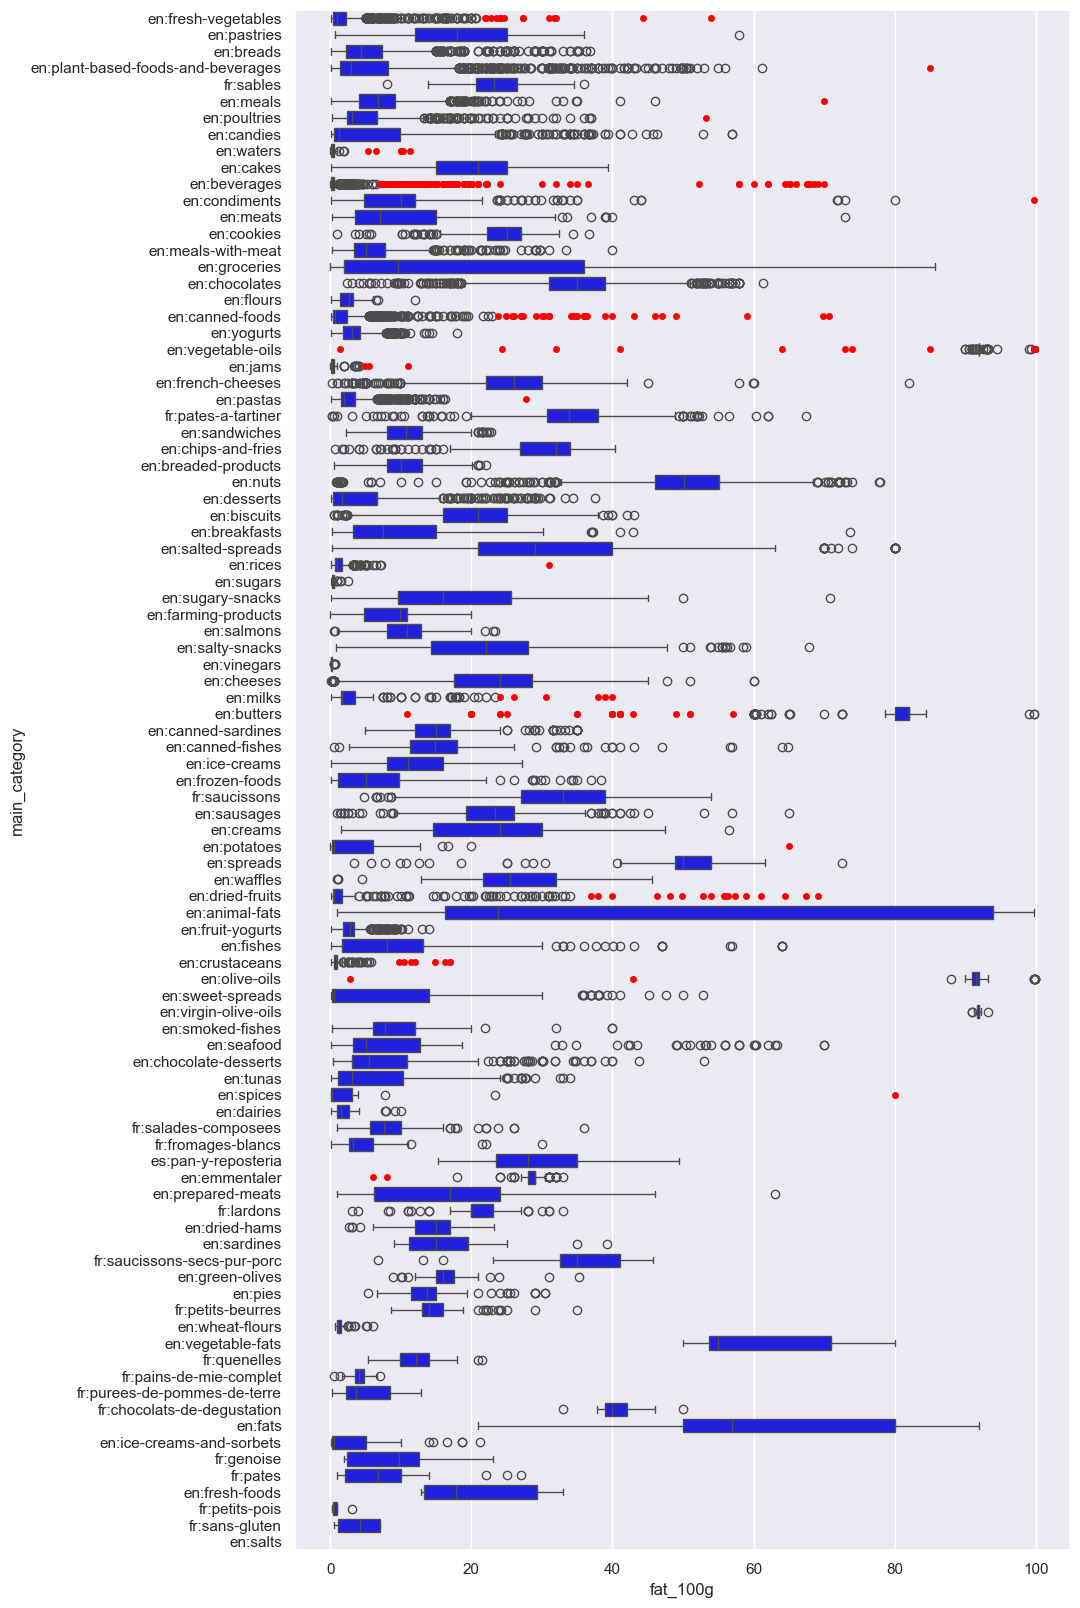

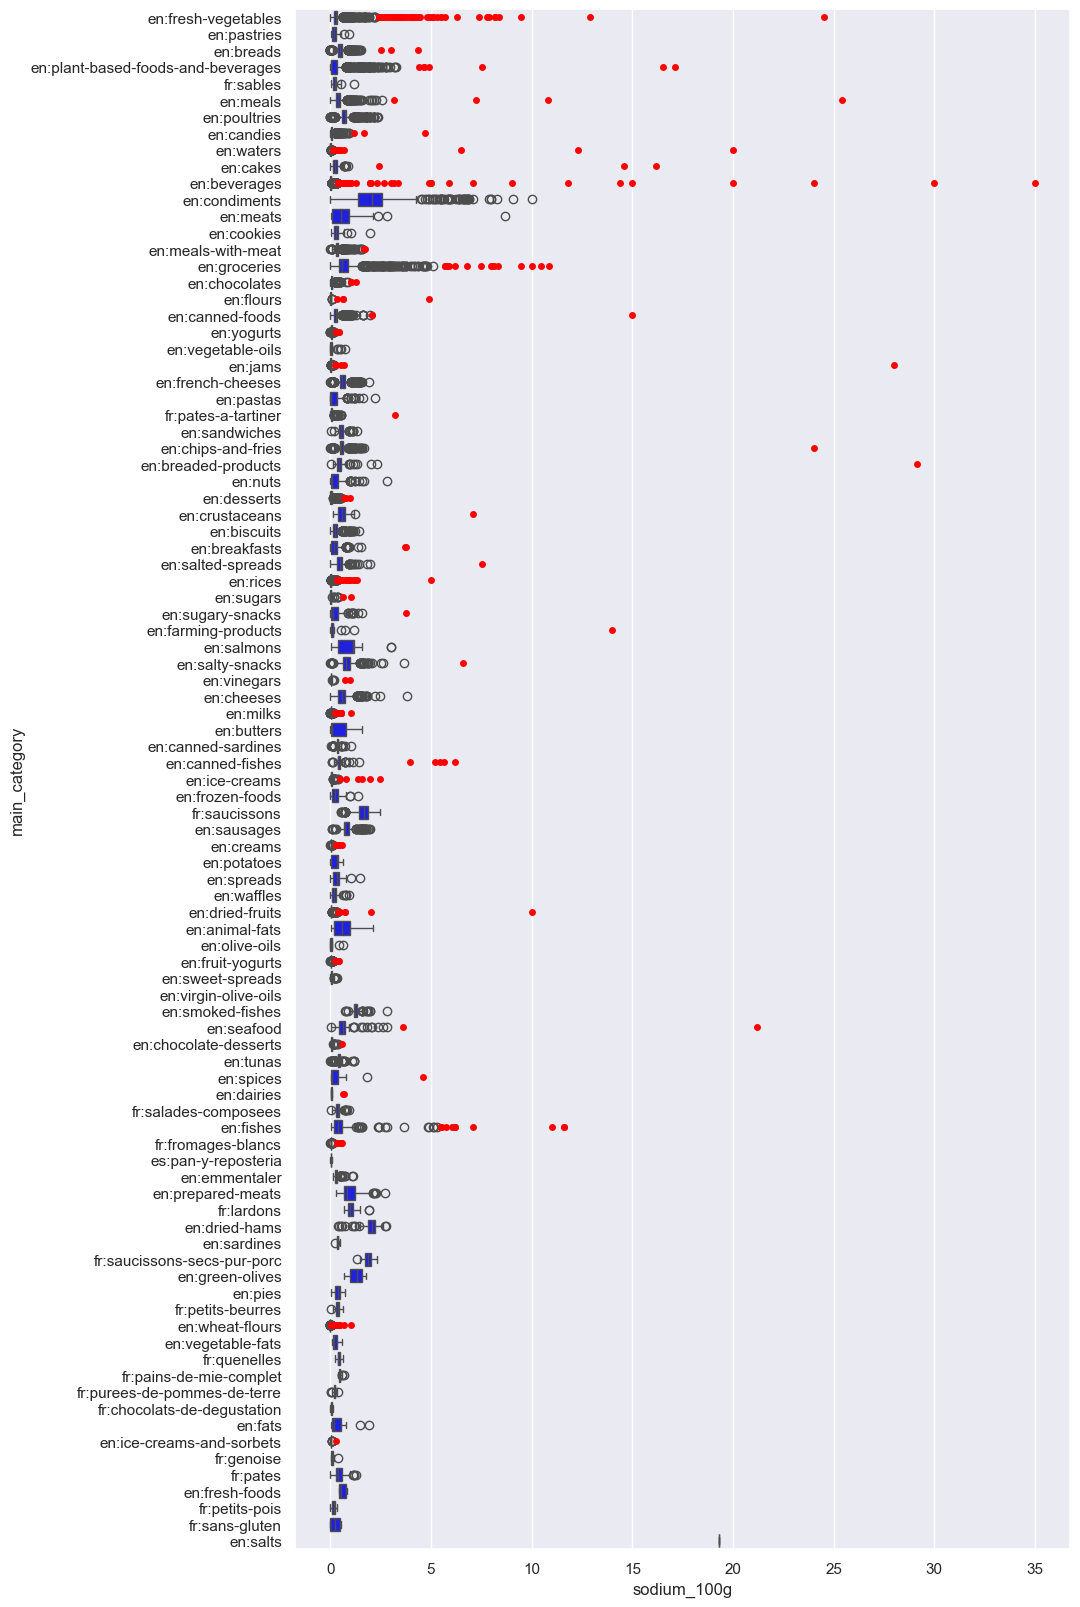

In [507]:
identify_outliers_iqr(df=filtered_data, categorical_col="main_category", numeric_cols=NUTRIENTS_COLS, factor=10)

Even with a factor of 10, outlier detection with IQR rule seems too strict and could have a significant impact on some distributions.  
It is very likely that there would be a lot of false positives. Therefore, this method will not be applied.  
Some outliers may remain. It is assumed that their impact iwill not be significant for the rest of the analysis.

## Missing data handling

### Using median imputation

C:\Users\HCYF5290\AppData\Local\Temp\1\ipykernel_12932\3904783755.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


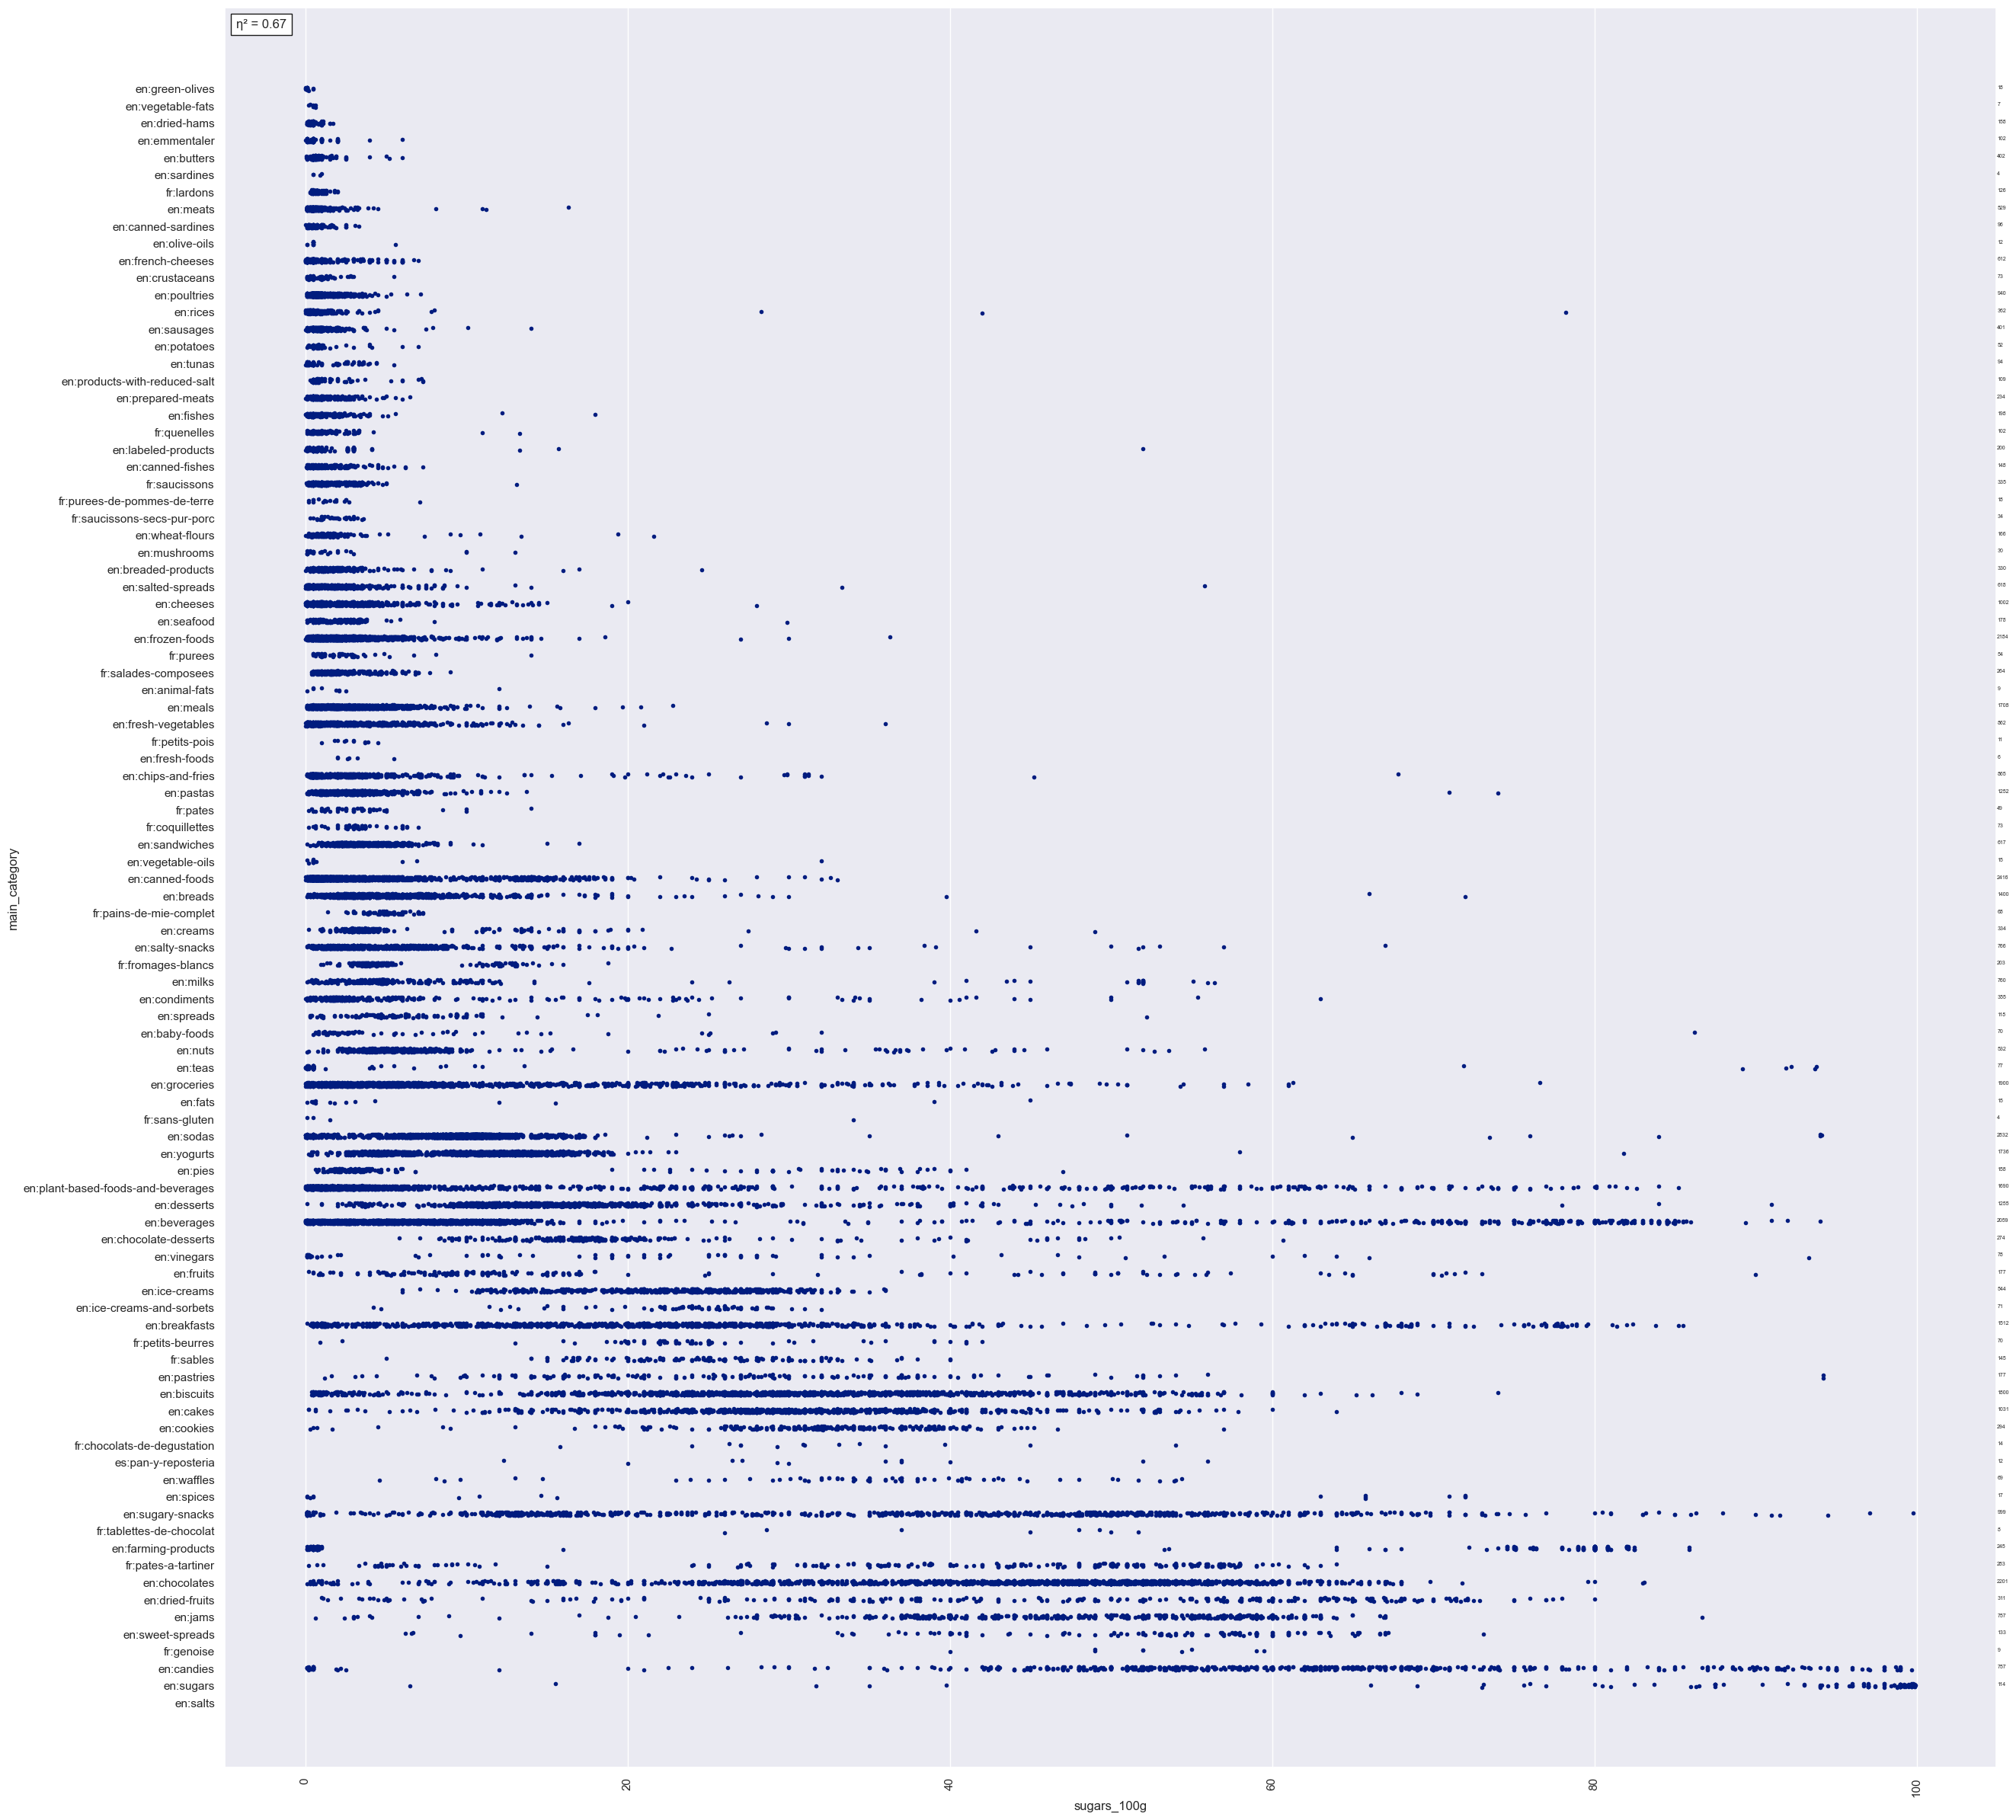

In [232]:
ANOVA(filtered_data, x="sugars_100g", y="main_category", plot_function=sns.stripplot, order=filtered_data["sugars_100g"].groupby(filtered_data["main_category"]).mean().sort_values().index, size=4, legend=None)

C:\Users\HCYF5290\AppData\Local\Temp\1\ipykernel_21136\72218607.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


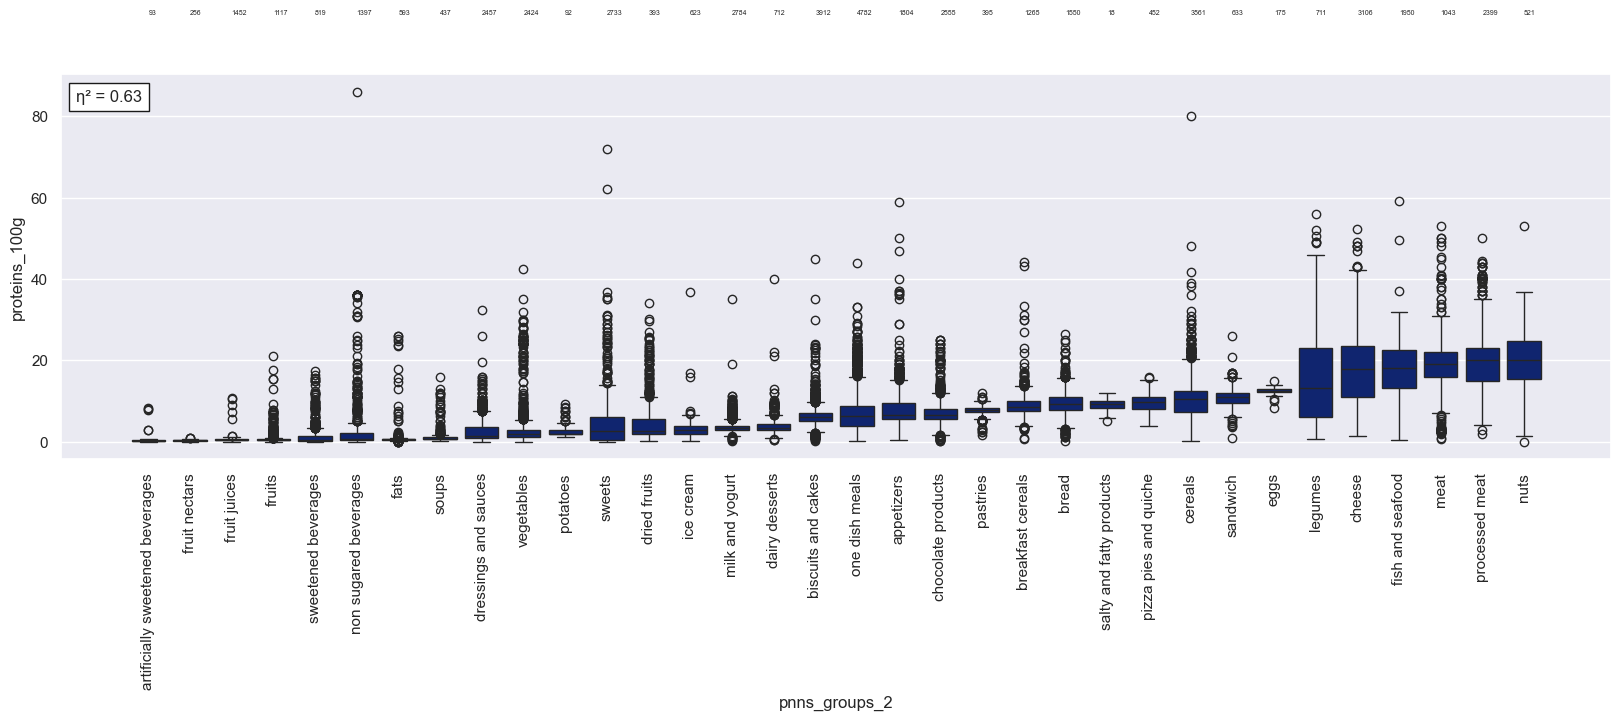

In [123]:
ANOVA(filtered_data, x="main_category", y="proteins_100g", plot_function=sns.boxplot, order=filtered_data["proteins_100g"].groupby(filtered_data["main_category"]).median().sort_values().index)

C:\Users\HCYF5290\AppData\Local\Temp\1\ipykernel_21136\72218607.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


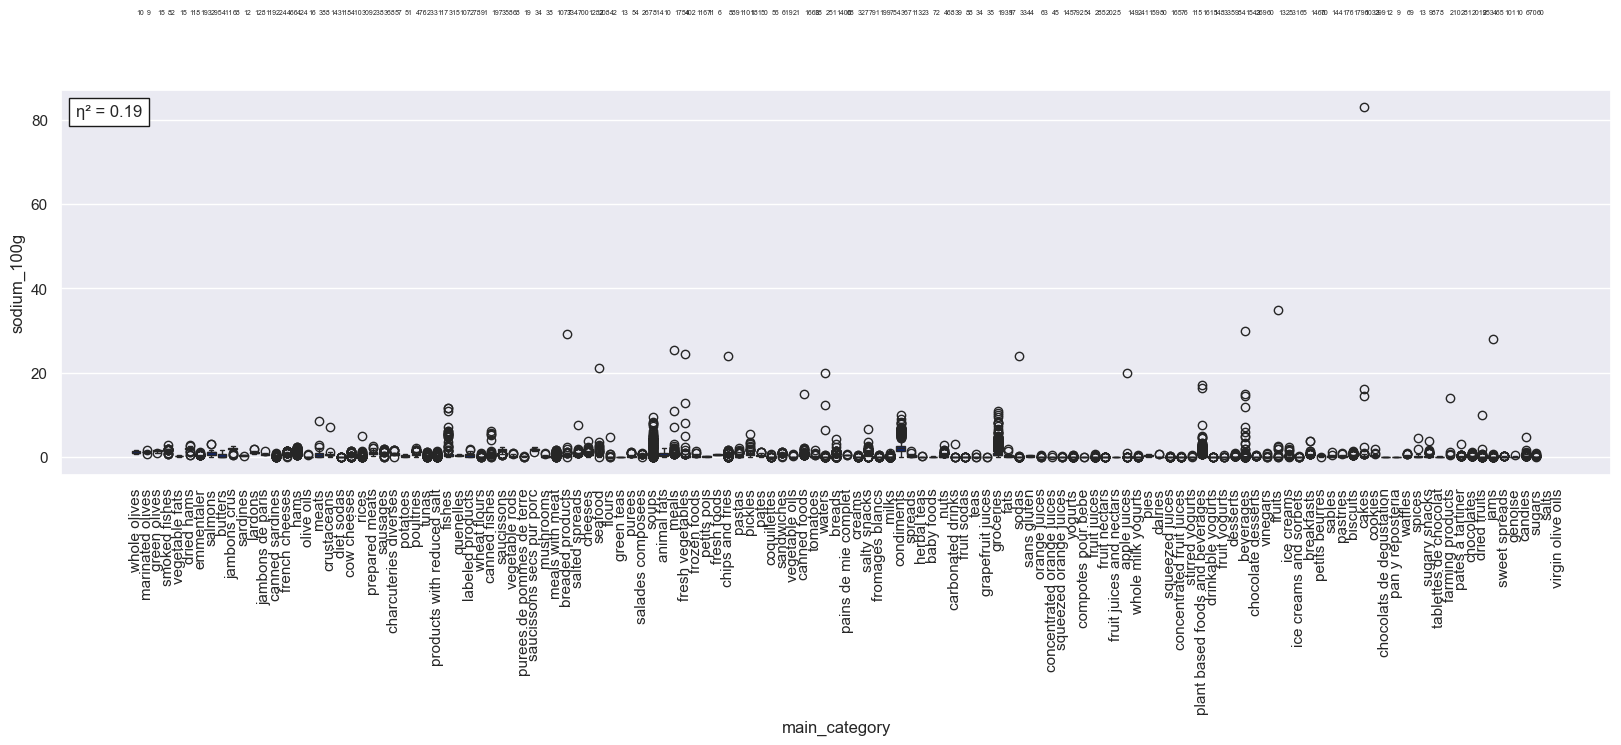

In [81]:
ANOVA(filtered_data, x="main_category", y="sodium_100g", plot_function=sns.boxplot, order=filtered_data["sugars_100g"].groupby(filtered_data["main_category"]).mean().sort_values().index)

C:\Users\HCYF5290\AppData\Local\Temp\1\ipykernel_21136\72218607.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


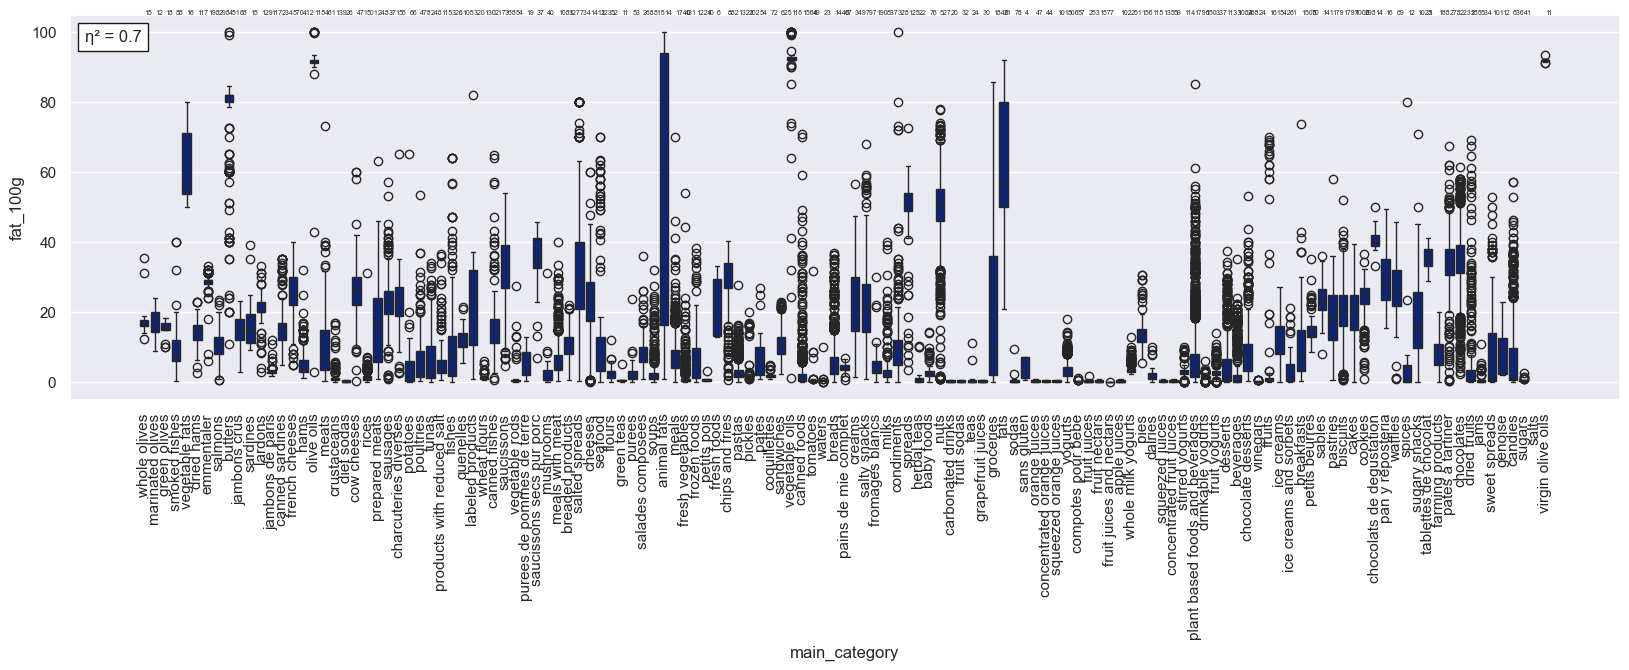

In [83]:
ANOVA(filtered_data, x="main_category", y="fat_100g", plot_function=sns.boxplot, order=filtered_data["sugars_100g"].groupby(filtered_data["main_category"]).mean().sort_values().index)

C:\Users\HCYF5290\AppData\Local\Temp\1\ipykernel_21136\72218607.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


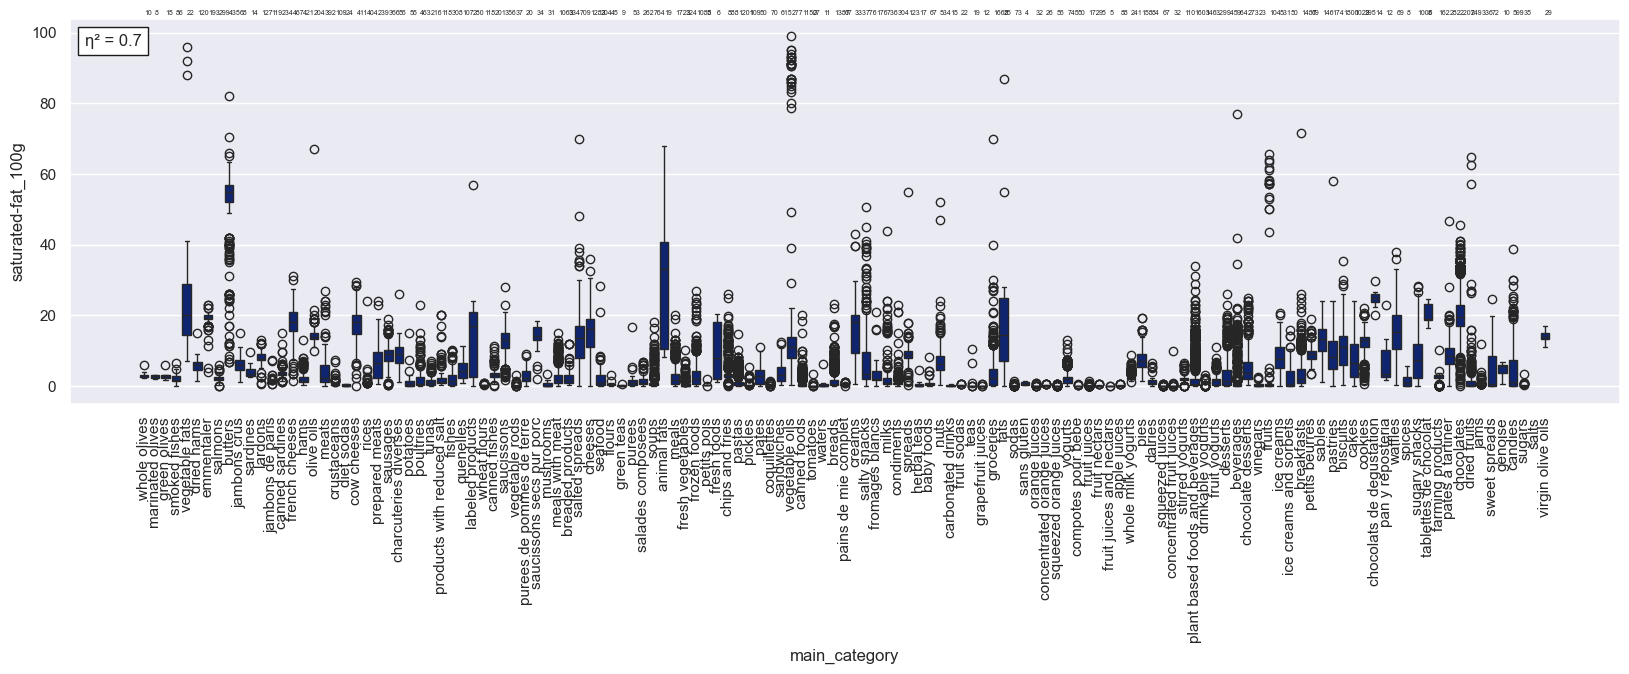

In [85]:
ANOVA(filtered_data, x="main_category", y="saturated-fat_100g", plot_function=sns.boxplot, order=filtered_data["sugars_100g"].groupby(filtered_data["main_category"]).mean().sort_values().index)

### Using linear regression

In [87]:
def impute_using_linreg(df:pd.DataFrame, target:str, threshold:float, visualize:bool=False):
    corr_matrix = df.corr(numeric_only=True)
    corr_series = corr_matrix[target].sort_values(ascending=False)

    # Select correlated features
    correlated_features = corr_series[corr_series > threshold].index.difference([target]).tolist()

    if not correlated_features:
        print(f"No correlated features found for target '{target}'.")
        return

    if visualize:
        fig, axes = plt.subplots(len(correlated_features))
        if not isinstance(axes, np.ndarray): # If there is only 1 correlated feature, therefore only 1 ax
            axes = [axes] # Convert it to a list to make it iterable
        for ax, corr_feature in zip(axes, correlated_features):
            r_square = corr_series[corr_feature]**2
            corr_coef = AnchoredText(f"R² = {round(r_square, 2)}", loc="upper left")
            ax.add_artist(corr_coef)
            ax.set_title(f"Illustration of the correlation between '{corr_feature}' and '{target}'")
            sns.regplot(data=df, x=corr_feature, y=target, ci=None, ax=ax)

    missing_target_data = df.loc[df[target].isna() & df[correlated_features].notna().all(axis=1)]
    train_data = df.loc[df[target].notna() & df[correlated_features].notna().all(axis=1)]

    el_to_predict_cnt = missing_target_data.shape[0]
    if el_to_predict_cnt == 0:
        print(f"""No value of target '{target}' can be predicted using features '{"', '".join(correlated_features)}'.""")
        return
    
    print(f"""{el_to_predict_cnt} values of target '{target}' can be predicted using features '{"', '".join(correlated_features)}'.""")

    # Prepare training data
    X_train = train_data[correlated_features]
    y_train = train_data[target]

    # Train the regression model
    model = LinearRegression(positive=True)
    model.fit(X_train, y_train)

    # Predict missing values
    X_missing = missing_target_data[correlated_features]
    df.loc[df[target].isna() & df[correlated_features].notna().all(axis=1), target] = model.predict(X_missing)

No correlated features found for target 'additives_n'.
No correlated features found for target 'ingredients_from_palm_oil_n'.
No correlated features found for target 'ingredients_that_may_be_from_palm_oil_n'.
No correlated features found for target 'energy_100g'.
No correlated features found for target 'fat_100g'.
No correlated features found for target 'saturated-fat_100g'.
No correlated features found for target 'carbohydrates_100g'.
No correlated features found for target 'sugars_100g'.
No correlated features found for target 'proteins_100g'.
1 values of target 'salt_100g' can be predicted using features 'sodium_100g'.
3 values of target 'sodium_100g' can be predicted using features 'salt_100g'.
11543 values of target 'nutrition-score-fr_100g' can be predicted using features 'nutrition-score-uk_100g'.
No value of target 'nutrition-score-uk_100g' can be predicted using features 'nutrition-score-fr_100g'.


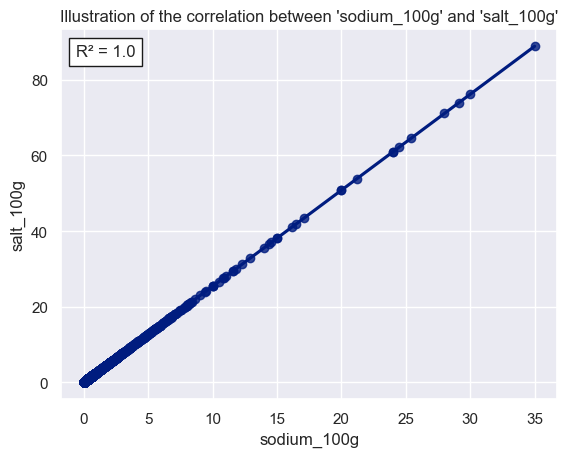

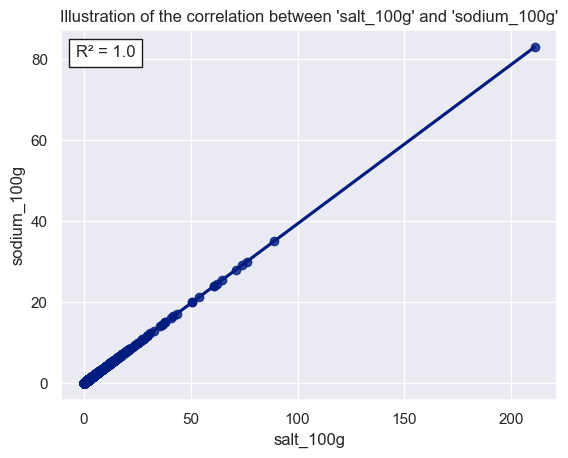

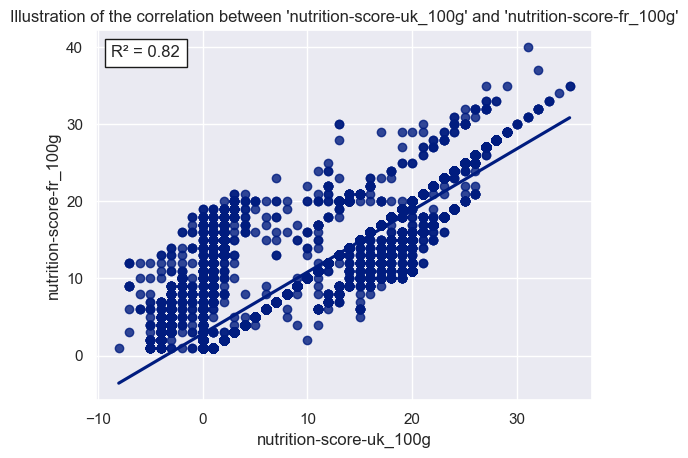

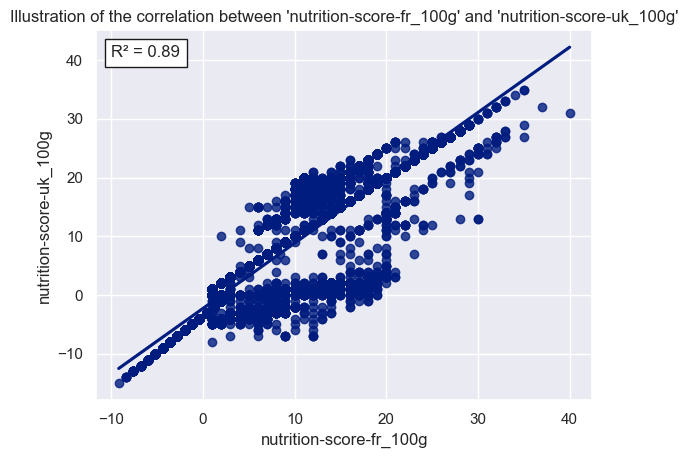

In [88]:
for col in filtered_data.select_dtypes(include=np.number).columns:
    impute_using_linreg(df=filtered_data, target=col, threshold=0.9, visualize=True)

### Remove highly correlated

In [89]:
def remove_outliers(s: pd.Series) -> pd.Series:
    '''
    Removes outliers from a Series based on the IQR method.

    Parameters:
    s (pd.Series): Series from which to remove outliers.

    Returns:
    pd.Series: Series with outliers replaced by NaN.
    '''
    s_copy = s.copy()
    
    q1 = s_copy.quantile(0.25)
    q3 = s_copy.quantile(0.75)
    iqr = q3 - q1

    # Define the bounds for outliers
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    # Remove rows with outliers
    s_copy.loc[(s_copy < lower_bound) | (s_copy > upper_bound)] = np.nan

    return s_copy

In [90]:
# Apply a list of functions to transform the data
def transform_data(df:pd.DataFrame, funcs:list[Callable]) -> pd.DataFrame:
    '''
    Applies a list of functions to transform the DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame to transform.
    funcs (list[Callable]): List of functions to apply to the DataFrame.

    Returns:
    pd.DataFrame: Transformed DataFrame.
    '''
    df_copy = df.copy()
    if funcs is not None and len(funcs) > 0:
        for f in funcs:
            try:
                # Iterate over numeric columns
                for col in df_copy.select_dtypes(include=[np.number]).columns:
                    df_copy[col] = f(df_copy[col])
            except AttributeError:
                df_copy = f(df_copy)

    return df_copy

In [91]:
def draw_heatmap(corr_matrix:pd.DataFrame, **plot_params):
    '''
    Draws a heatmap for the given correlation matrix.

    Parameters:
    corr_matrix (pd.DataFrame): Correlation matrix to visualize.
    '''
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    fig, ax = plt.subplots(figsize=(15, 10))
    ax = sns.heatmap(corr_matrix, ax=ax, mask=mask, center=0, **plot_params)
    ax.set_title("Correlation matrix")
    plt.plot()

In [92]:
def drop_highly_correlated_features(df:pd.DataFrame, threshold:float):
    df_copy = df.copy()

    df_copy.loc["Missing Data Percentage"] = df_copy.select_dtypes(include=np.number).isna().mean()
    df_copy.sort_values(by="Missing Data Percentage", axis=1, inplace=True, ascending=False)
    df_copy.drop(index="Missing Data Percentage", inplace=True)

    transformed_df = transform_data(df_copy, [remove_outliers])
    corr_matrix = transformed_df.corr(min_periods=20, numeric_only=True)**2
    draw_heatmap(corr_matrix=corr_matrix, vmin=-1, vmax=1, cmap="vlag", annot=True, fmt=".2f")
    # mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    # tri = corr_matrix.where(~mask)

    # sns.heatmap(data=tri, vmin=-1, vmax=1, mask=mask, cmap="vlag", annot=True, fmt=".2f")

    to_drop = [column for column in tri.columns if any(tri[column] > threshold)]
    print(f"Dropped columns: {', '.join(to_drop)}")

    return df.drop(columns=to_drop)


Dropped columns: salt_100g, nutrition-score-fr_100g


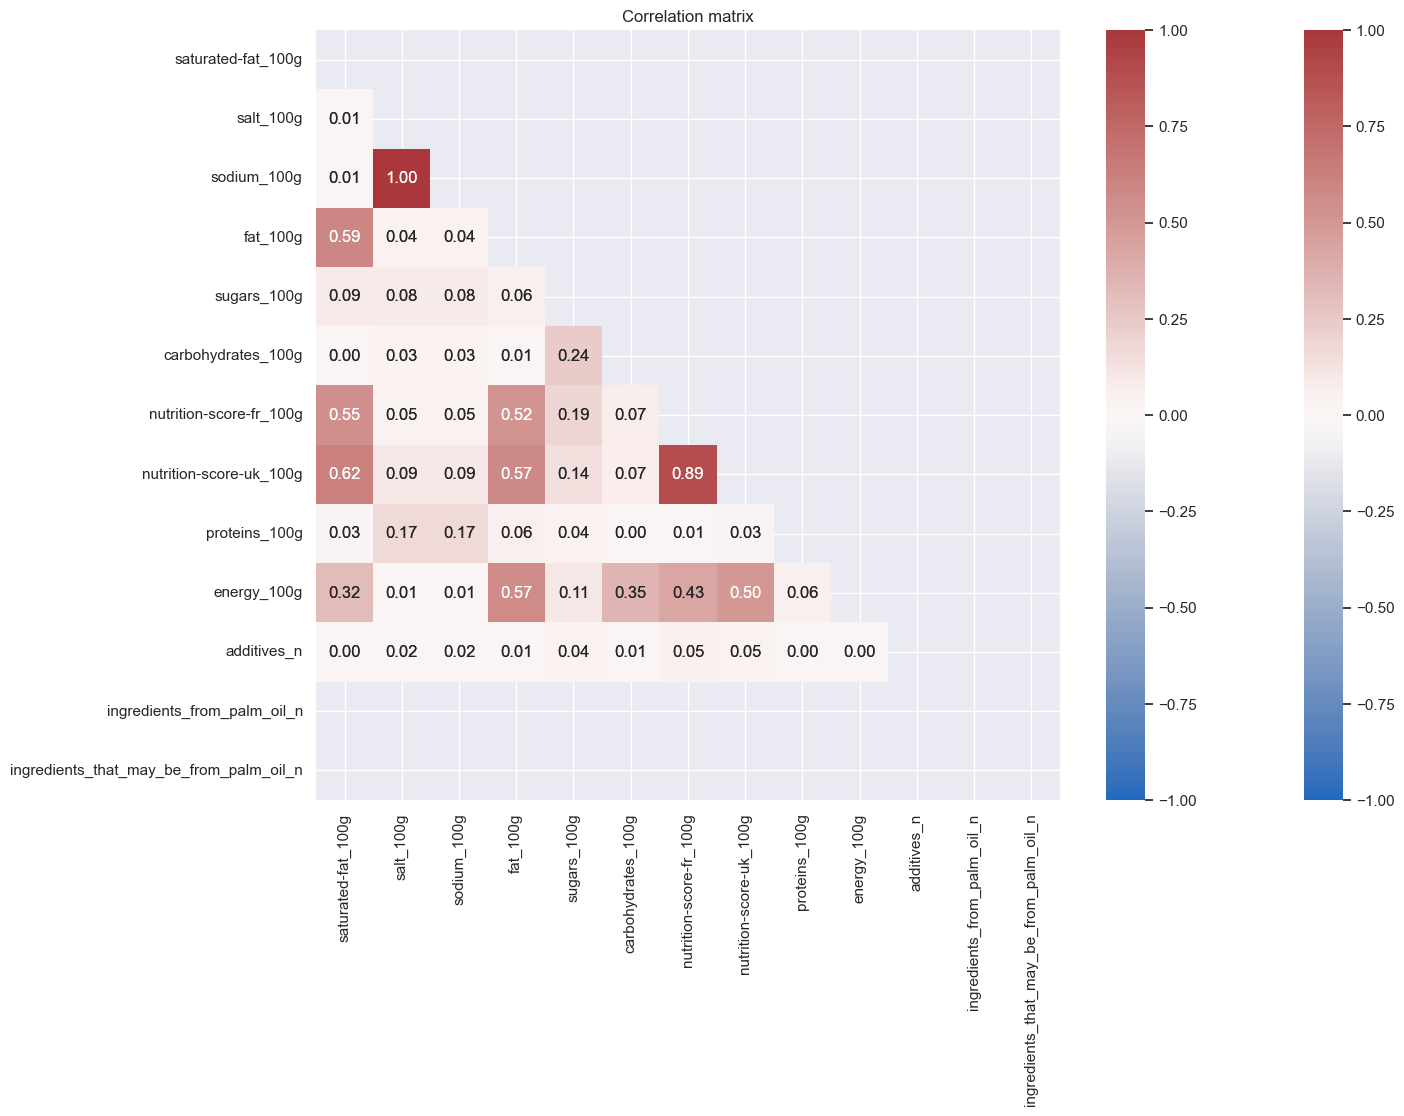

In [93]:
filtered_data = drop_highly_correlated_features(filtered_data, 0.85)

### Characterizing the type of missing data (MCAR, MAR, MNAR)

<Axes: >

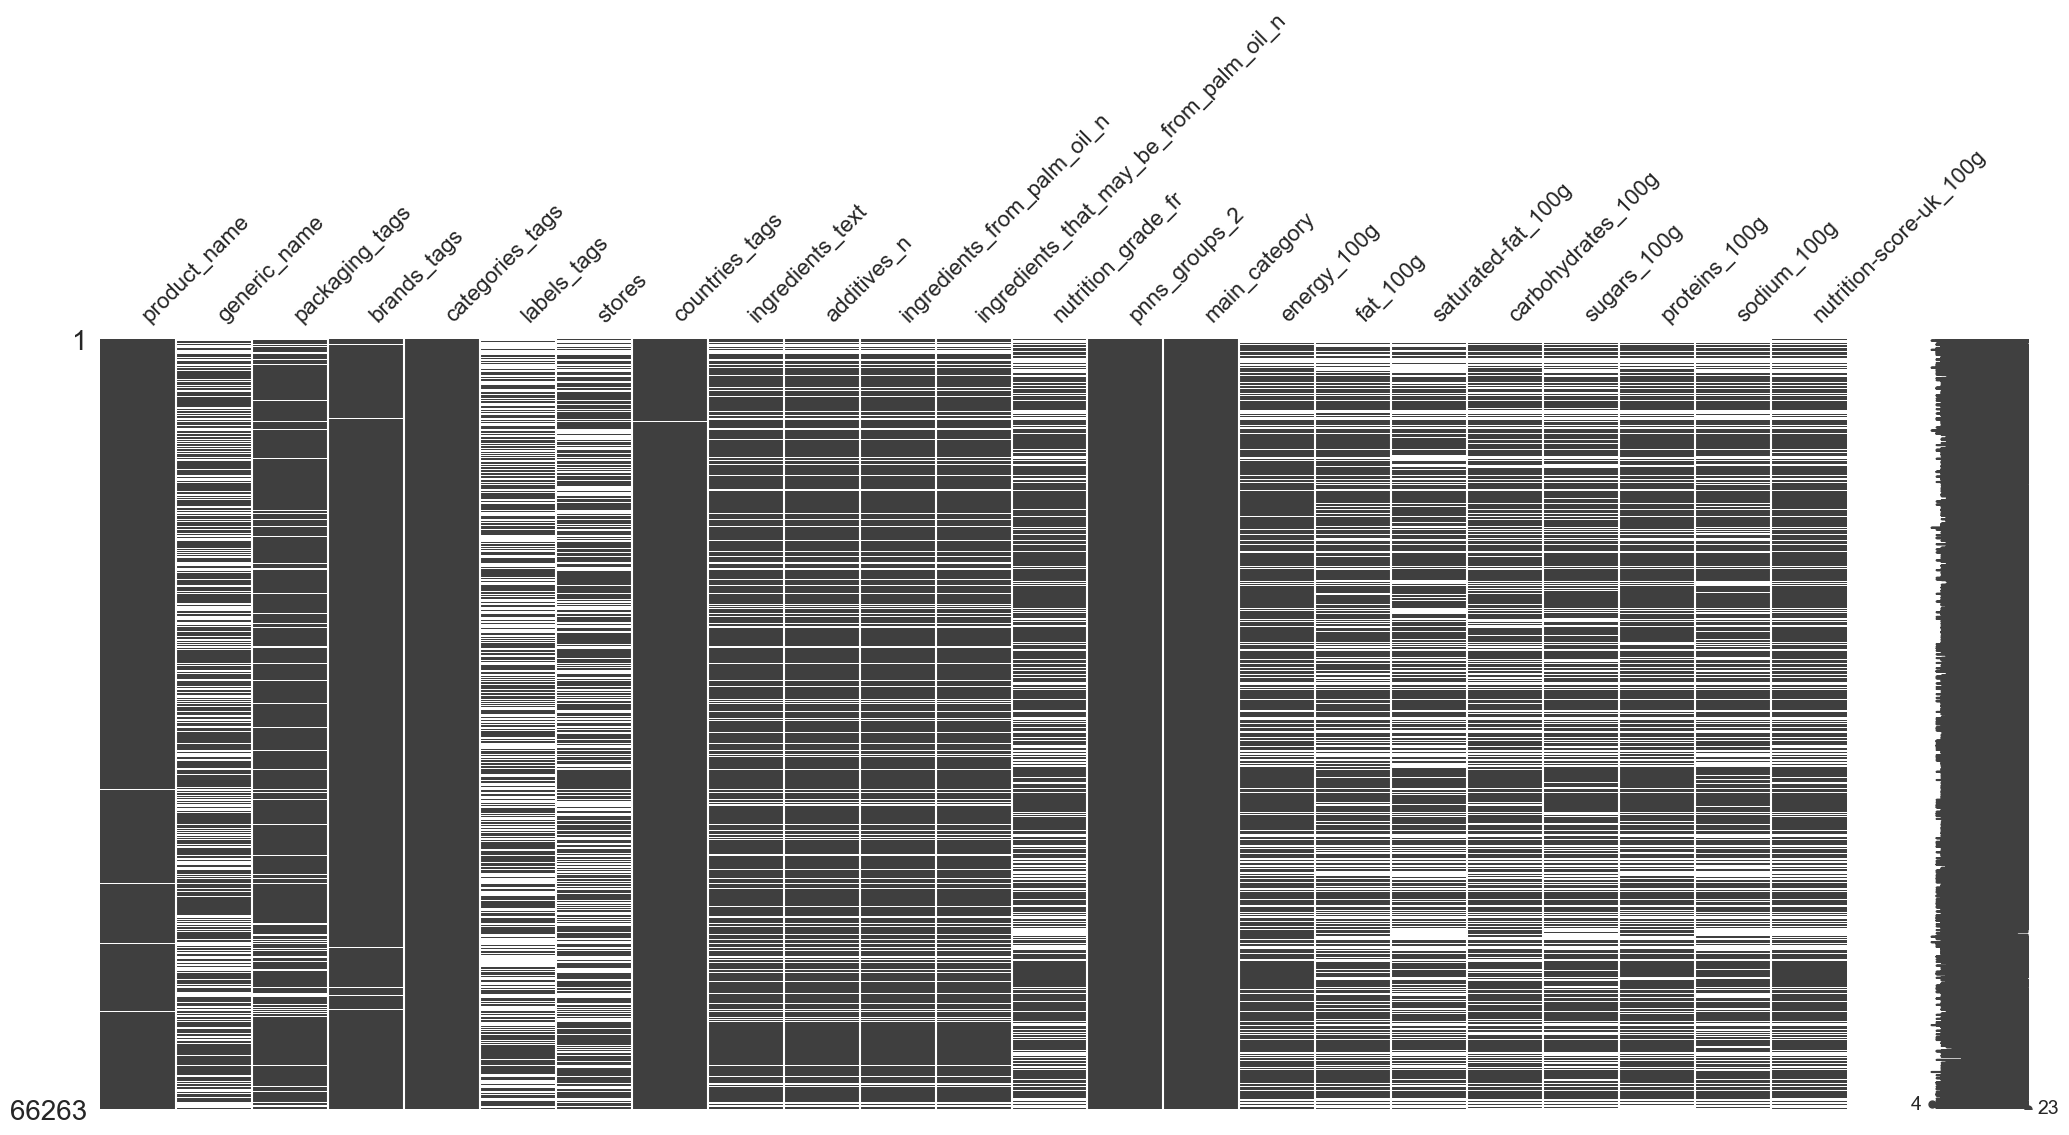

In [94]:
msno.matrix(df=filtered_data)

<Axes: >

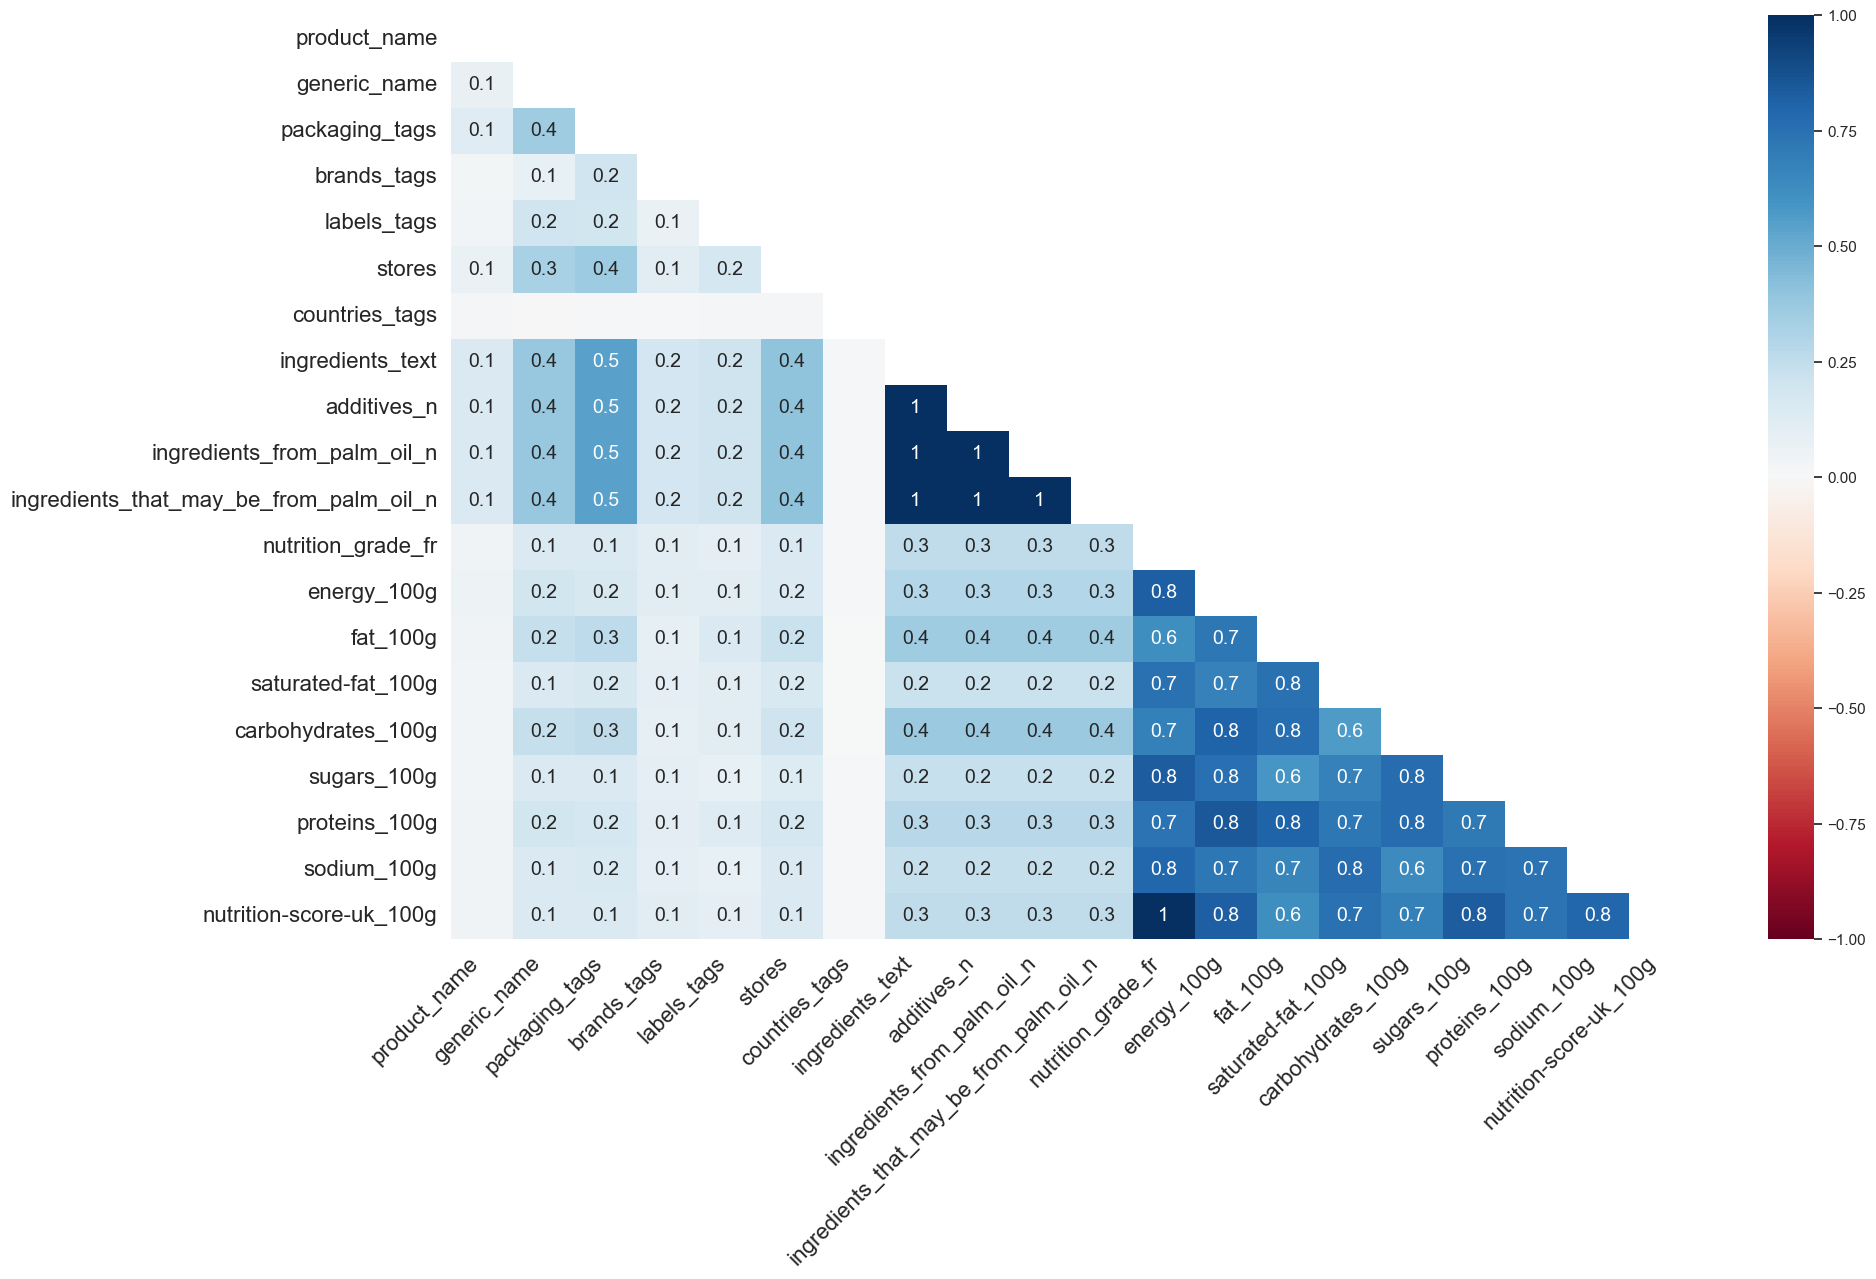

In [96]:
msno.heatmap(df=filtered_data)

<Axes: >

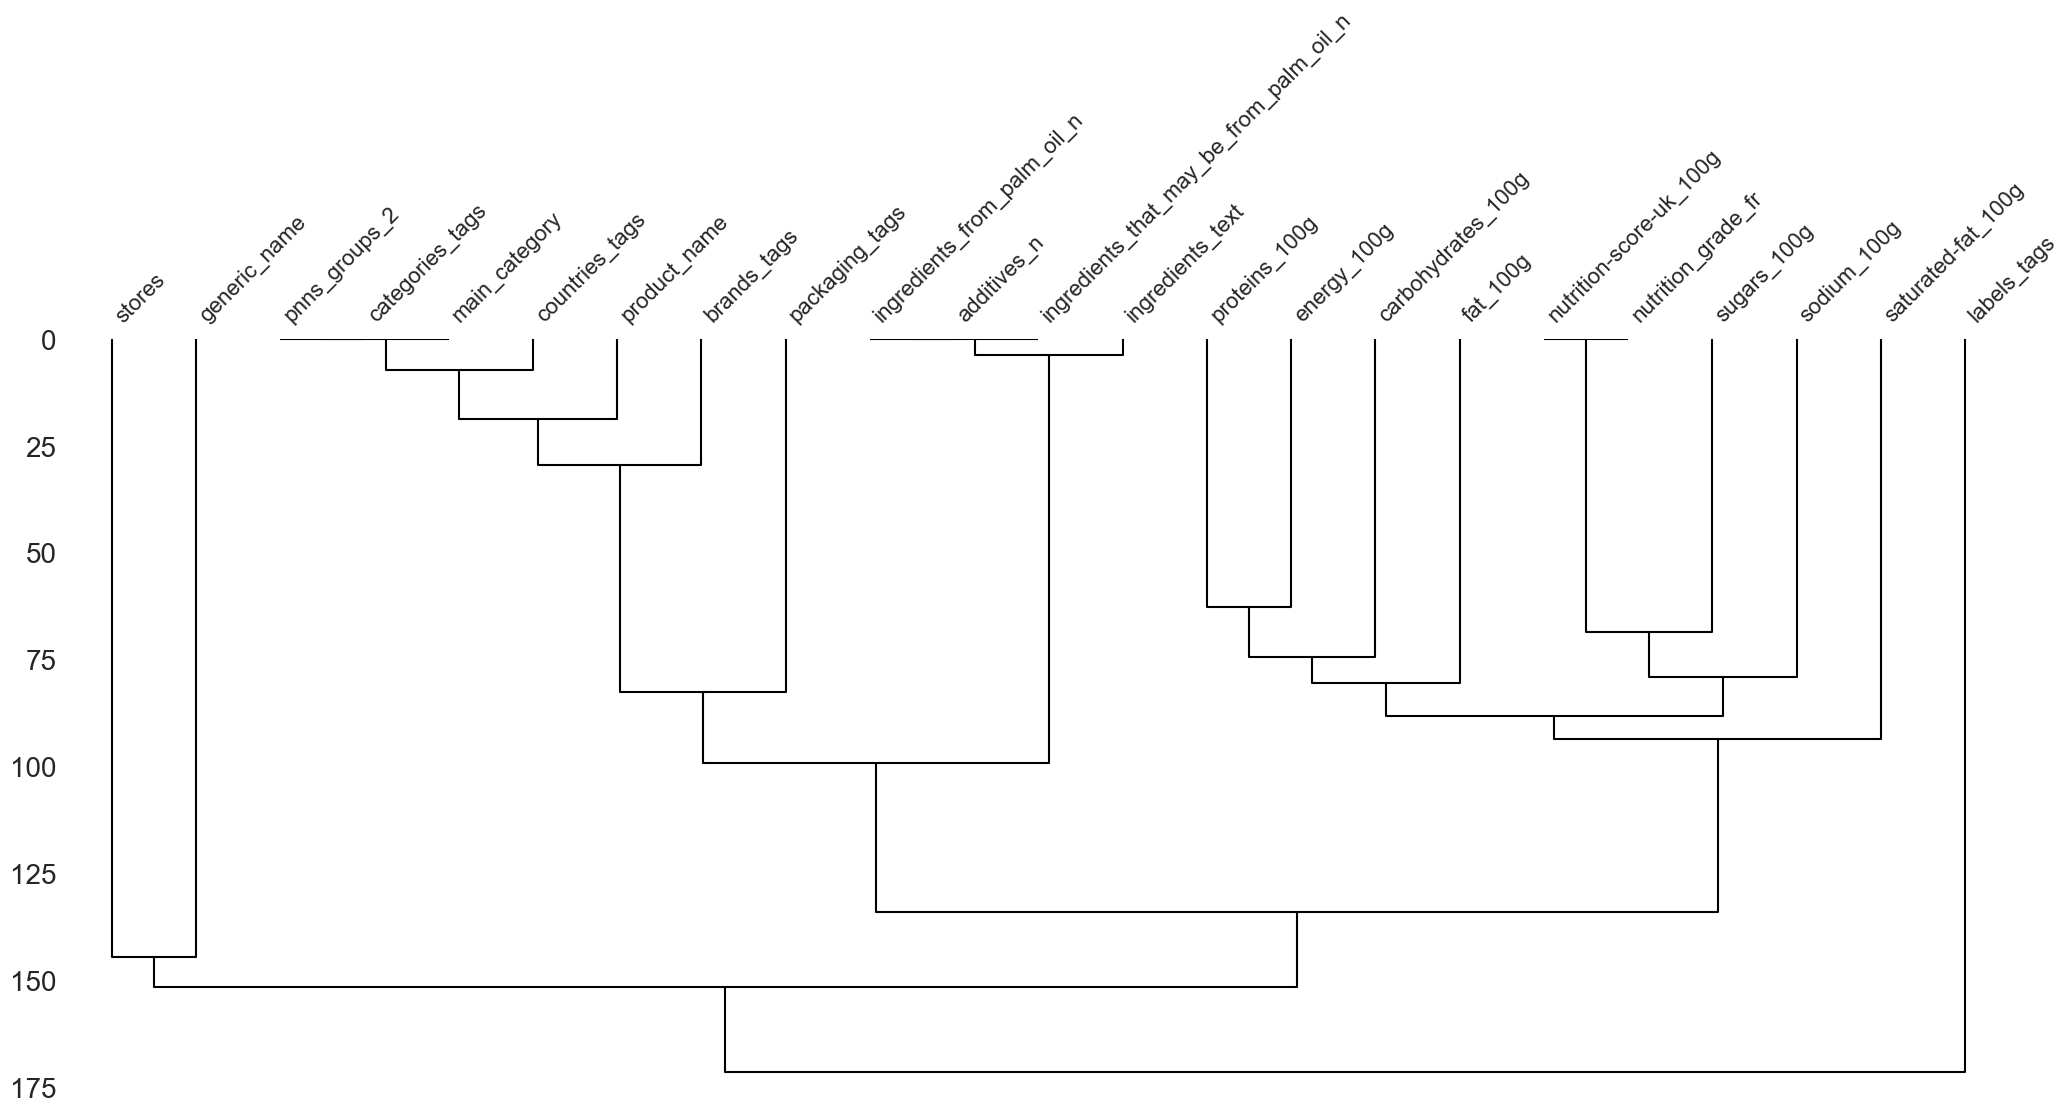

In [97]:
msno.dendrogram(df=filtered_data)

### Using K-Nearest Neighbors

In [98]:
def edit_distance_unordered(list1, list2):
    """Calculate distance between 2 unordered lists based on the number of insertions and deletions."""
    set1, set2 = set(list1), set(list2)
    deletions = len(set1 - set2)  # Elements in list1 but not in list2
    insertions = len(set2 - set1)  # Elements in list2 but not in list1
    return (deletions + insertions) / (len(set1) + len(set2))

In [99]:
isinstance(5.0, list)

False

In [100]:
def distance_nan_and_numeric(x, y):
    """Handle NaN and numeric differences efficiently."""
    if isinstance(x, list) or isinstance(y, list) or pd.isna(x) or pd.isna(y):
        return 1
    return abs(x-y)

def custom_metric(x_missing, y_potential_neighbor):
    """Compute the custom metric efficiently."""
    # Convert to NumPy arrays for efficient processing
    x_missing = np.array(x_missing, dtype=object)
    y_potential_neighbor = np.array(y_potential_neighbor, dtype=object)
    str_dist = [1 - SequenceMatcher(a=x, b=y).ratio() if isinstance(x, str) and isinstance(y, str) else 0 for x, y in zip(x_missing, y_potential_neighbor)]
    numeric_dist = [distance_nan_and_numeric(x, y) if isinstance(x, (int, float, type(pd.NA), type(None))) or isinstance(y, (int, float , type(pd.NA), type(None))) else 0 for x, y in zip(x_missing, y_potential_neighbor)]
    other_dist = [edit_distance_unordered(x, y) if isinstance(x, list) and isinstance(y, list) else 0 for x, y in zip(x_missing, y_potential_neighbor)]
    # Combine numeric and non-numeric differences
    difference = [string + num + non_num for string, num, non_num in zip(str_dist, numeric_dist, other_dist)]
    # Compute the distance
    distance = np.linalg.norm(difference)
    return distance

In [101]:
def build_and_save_model(df: pd.DataFrame, n_neighbors:int, filename: str) -> None:
    """Build and save a model to a file."""
    distance_matrix = compute_parallel_distance_matrix(df, df, metric=custom_metric)
    neigh = NearestNeighbors(n_neighbors=n_neighbors, metric="precomputed")
    neigh.fit(distance_matrix)
    with open(filename, 'wb') as f:
        pickle.dump(neigh, f)
    
    return neigh

def load_model(filename: str) -> NearestNeighbors:
    """Load a model from a file."""
    with open(filename, 'rb') as f:
        return pickle.load(f)
    

In [102]:
def imputation(df:pd.DataFrame, features_to_estimate:list[str], n_neighbors:int=20, method:Literal['build_and_save', 'load']='build_and_save'):
    '''
    Imputes missing values for specified features in a DataFrame using group averages or a specified method.

    Parameters:
    df (pd.DataFrame): Original DataFrame.
    features_to_estimate (str): Features for which missing data needs to be imputed.
    group_columns (str): Possible grouping variables for aggregation. All combinations will be attempted and the one with the lowest variation will be chosen for each missing value.
    method (Literal): Indicates whether the model should be built from scratch and saved ('save'), or rather loaded from a file ('load'). Defaults to 'save'.

    Returns:
    pd.DataFrame: DataFrame with imputed values for the specified indicator.
    '''    
    df_copy = df.copy()

    df_copy.reset_index(inplace=True, drop=True)

    # Transform columns with list-like values with split
    for col in LISTLIKE_COLS:
      if col in df_copy:
        df_copy[col] = df_copy[col].apply(lambda x: x.split(',') if isinstance(x, str) else x)
    
    numeric_columns = df_copy.select_dtypes(include=np.number).columns
    # Scale between 0 and 1
    scaler = MinMaxScaler() # This is sensitive to outliers
    df_scaled = df_copy.copy()
    df_scaled[numeric_columns] = pd.DataFrame(scaler.fit_transform(df_scaled[numeric_columns]), columns=numeric_columns)
    
    missing_data = df_scaled.loc[df_scaled[features_to_estimate].isna().any(axis=1)]

    filename = f'{n_neighbors}_neighbors_{df_copy.shape[0]}.sav'

    if method == "load":
        neigh = load_model(filename)
    elif method == "build_and_save":
        neigh = build_and_save_model(df=df_scaled, n_neighbors=n_neighbors, filename=filename)
    else:
        raise ValueError("Invalid method. Use 'build_and_save' or 'load'.")

    nbrs_indices = neigh.kneighbors(n_neighbors=n_neighbors, return_distance=False)

    def impute_missing(missing_data:pd.DataFrame, complete_data:pd.DataFrame, indices):
        imputed_data = complete_data.copy()
        for col in missing_data.columns:
            for i, row in missing_data.iterrows():
                if not isinstance(row[col], list) and pd.isna(row[col]):
                    neighbors = [complete_data.iloc[j][col] for j in indices[i] if isinstance(complete_data.iloc[j][col], list) or not pd.isna(complete_data.iloc[j][col])]
                    if not neighbors:
                      continue
                    if isinstance(neighbors[0], str):
                        imputed_data.at[i, col] = max(set(neighbors), key=neighbors.count) if neighbors else None
                    elif isinstance(neighbors[0], (float, int)):
                        imputed_data.at[i, col] = np.median(neighbors)
                    elif isinstance(neighbors[0], list):
                        list_union = [item for sublist in neighbors for item in sublist]
                        # max_frequency_item = max(list_union, key=list_union.count)
                        c = Counter(list_union)
                        # print(f"neighbors: {neighbors} // list_union: {list_union} // max_frequency_item: {max_frequency_item}")
                        imputed_data.at[i, col] = [k for k, v in c.items() if v>3] if neighbors else None
                    else:
                        imputed_data.at[i, col] = neighbors[0]
        return imputed_data
    
    imputed_data = impute_missing(missing_data=missing_data, complete_data=df_copy, indices=nbrs_indices)

    for col in LISTLIKE_COLS:
      if col in df_copy:
        imputed_data[col] = imputed_data[col].apply(lambda x: ','.join(x) if isinstance(x, list) else x)

    return imputed_data

In [103]:
def random_imputation(df:pd.DataFrame, features_to_estimate:list[str]):
    '''
    Imputes missing values for specified features in a DataFrame using group averages or a specified method.

    Parameters:
    df (pd.DataFrame): Original DataFrame.
    features_to_estimate (str): Features for which missing data needs to be imputed.
    group_columns (str): Possible grouping variables for aggregation. All combinations will be attempted and the one with the lowest variation will be chosen for each missing value.
    method (Literal): Indicates whether the model should be built from scratch and saved ('save'), or rather loaded from a file ('load'). Defaults to 'save'.

    Returns:
    pd.DataFrame: DataFrame with imputed values for the specified indicator.
    '''    
    df_copy = df.copy()

    df_copy.reset_index(inplace=True, drop=True)

    # Transform columns with list-like values with split
    for col in LISTLIKE_COLS:
      if col in df_copy:
        df_copy[col] = df_copy[col].apply(lambda x: x.split(',') if isinstance(x, str) else x)
    
    numeric_columns = df_copy.select_dtypes(include=np.number).columns
    # Scale between 0 and 1
    scaler = MinMaxScaler() # This is sensitive to outliers
    df_scaled = df_copy.copy()
    df_scaled[numeric_columns] = pd.DataFrame(scaler.fit_transform(df_scaled[numeric_columns]), columns=numeric_columns)
    
    missing_data = df_scaled.loc[df_scaled[features_to_estimate].isna().any(axis=1)]

    def impute_missing(missing_data:pd.DataFrame, complete_data:pd.DataFrame):
        imputed_data = complete_data.copy()
        for col in missing_data.columns:
            for i, row in missing_data.iterrows():
                if not isinstance(row[col], list) and pd.isna(row[col]):
                    if col not in numeric_columns and col not in LISTLIKE_COLS:
                        imputed_data.at[i, col] = complete_data[col].dropna().sample(n=1, ignore_index=True)[0]
                    elif col in numeric_columns:
                        imputed_data.at[i, col] = np.random.random()
                    elif col in LISTLIKE_COLS:
                        random_list = complete_data[col].dropna().sample(n=1, ignore_index=True)[0]
                        imputed_data.at[i, col] = np.random.choice(random_list)
                    else:
                        imputed_data.at[i, col] = complete_data[col].dropna().sample(n=1, ignore_index=True)[0]
        return imputed_data
    
    imputed_data = impute_missing(missing_data=missing_data, complete_data=df_copy)

    for col in LISTLIKE_COLS:
      if col in imputed_data:
        imputed_data[col] = imputed_data[col].apply(lambda x: ','.join(x) if isinstance(x, list) else x)

    return imputed_data

In [104]:
def build_test_data(df:pd.DataFrame, max_samples:int=1000):
    rng = np.random.RandomState(42)
    
    # Only keep samples with no missing values and only keep max_samples rows
    complete_portion = df.loc[df.notna().all(axis=1)][:max_samples]
    complete_portion.reset_index(inplace=True, drop=True)
    n_samples, n_features = complete_portion.shape
    
    # Create mask to insert random missing values
    cov = df.isna().cov()
    mean = df.isna().mean()
    mask = np.abs(rng.multivariate_normal(mean, cov, size=n_samples)).round(0)
    
    # Avoid completely empty rows
    mask[mask.all(1), rng.choice(range(n_features))] = 0

    df_with_missing = complete_portion.mask(mask.astype(bool))

    return complete_portion, df_with_missing

In [105]:
def score_nan_and_numeric(x, y):
    """Handle NaN and numeric differences efficiently."""
    if isinstance(x, list) or isinstance(y, list) or pd.isna(x) or pd.isna(y):
        return 0
    return 1 - abs(x-y)

In [226]:
def getImputationScore(ref:pd.DataFrame, test:pd.DataFrame, imputed:pd.DataFrame):
    
    ref_copy = ref.copy()
    imputed_copy = imputed.copy()

    df_compare = ref_copy.compare(imputed_copy, keep_shape=True, keep_equal=True)
    mask_na_after_multiindex = ref_copy.compare(imputed_copy, keep_shape=True, keep_equal=True).isnull()
    mask_na_after_multiindex = mask_na_after_multiindex * 3

    mask_diff_multiindex = ref_copy.compare(imputed_copy, keep_shape=True).notnull()
    mask_diff_multiindex = mask_diff_multiindex * 2

    mask_na_initial = test.isna()
    mask_na_initial_multiindex = pd.DataFrame(columns=df_compare.columns)
    for col in mask_na_initial.columns:
        mask_na_initial_multiindex[col, 'self'] = mask_na_initial[col]
        mask_na_initial_multiindex[col, 'other'] = mask_na_initial[col]

    mask_color_multiindex = mask_na_initial_multiindex + mask_diff_multiindex + mask_na_after_multiindex
    
    def apply_color(x):
        colors = {0: 'black', 1: 'green', 2:'fuchsia', 3:'maroon', 4:'red'}
        return mask_color_multiindex.map(lambda val: 'background-color: {}'.format(colors.get(val,'')))
    
    numeric_columns = ref_copy.select_dtypes(include=np.number).columns
    # Scale between 0 and 1
    scaler = MinMaxScaler()
    ref_copy[numeric_columns] = pd.DataFrame(scaler.fit_transform(ref_copy[numeric_columns]), columns=numeric_columns)
    imputed_copy[numeric_columns] = pd.DataFrame(scaler.transform(imputed_copy[numeric_columns]), columns=numeric_columns)
    
    # Transform columns with list-like values with split
    for col in LISTLIKE_COLS:
      if col in ref_copy:
        ref_copy[col] = ref_copy[col].apply(lambda x: x.split(',') if isinstance(x, str) else x)
        imputed_copy[col] = imputed_copy[col].apply(lambda x: x.split(',') if isinstance(x, str) else x)

    def wrapper_calc_score(ref:pd.Series, imputed:pd.Series):
      """Compute the custom metric efficiently."""
      return ref.combine(imputed, calc_score)
    
    def calc_score(ref, imputed):
      if isinstance(ref, str) and isinstance(imputed, str):
         return ref == imputed
      if isinstance(ref, (int, float, type(pd.NA), type(None))) or isinstance(imputed, (int, float, type(pd.NA), type(None))):
         return score_nan_and_numeric(ref, imputed)
      return set(imputed) and len(set(imputed).intersection(ref)) / len(set(imputed))
    
    score_df = ref_copy.combine(imputed_copy, wrapper_calc_score)
    score_df = score_df.mask(~mask_na_initial)

    score_df["mean_score"] = score_df.mean(axis=1)
    score_df.sort_values(by="mean_score", ascending=True, inplace=True)

    summarized_score_df = pd.DataFrame(data={"mean": score_df.mean(), "sum":score_df.sum()})

    str_cols = list(set(ref.select_dtypes(include="object").columns) - set(LISTLIKE_COLS))
    num_cols = ref.select_dtypes(include=np.number).columns

    summarized_score_df.loc["num", :] = [summarized_score_df.loc[num_cols, "mean"].mean(), summarized_score_df.loc[num_cols, "sum"].sum()]
    summarized_score_df.loc["str", :] = [summarized_score_df.loc[str_cols, "mean"].mean(), summarized_score_df.loc[str_cols, "sum"].sum()]
    summarized_score_df.loc["listlike", :] = [summarized_score_df.loc[[col for col in LISTLIKE_COLS if col in score_df.columns], "mean"].mean(), summarized_score_df.loc[[col for col in LISTLIKE_COLS if col in score_df.columns], "sum"].sum()]
    summarized_score_df.loc["global", :] = [summarized_score_df["mean"].mean(), summarized_score_df["sum"].sum()]
    
    return score_df, summarized_score_df, df_compare.style.apply(apply_color, axis=None)

In [108]:
ref_test = pd.DataFrame(
    {'num':[0.1, 0.4, 0.5],
     'list':['lettre_a, lettre_b, test_c', 'd_test, e_lettre, f__', 'gest, example, nan'],
     'string': ['category1', 'sweet things', 'category_test']}
)
test_test = pd.DataFrame(
    {'num':[0.1, 0.4, np.nan],
     'list':['lettre_a, lettre_b, test_c', np.nan, 'gest, example, nan'],
     'string': [np.nan, np.nan, np.nan]}
)
imputed_test = pd.DataFrame(
    {'num':[0.1, 0.4, 0.1],
     'list':['lettre_a, lettre_b, test_c', 'd_test', 'gest, example, nan'],
     'string': ['category', np.nan, 'category_test']}
)
getImputationScore(ref_test, test_test, imputed_test)

(   num   list string mean_score
 0  NaN    NaN  False        0.0
 1  NaN  False      0        0.0
 2  0.0    NaN   True        0.5,
                 mean  sum
 num              0.0  0.0
 list             0.0    0
 string      0.333333    1
 mean_score  0.166667  0.5
 str         0.166667    1
 listlike         NaN    0
 global      0.133333  2.5,
 <pandas.io.formats.style.Styler at 0x1fec99e4320>)

Built
Imputed


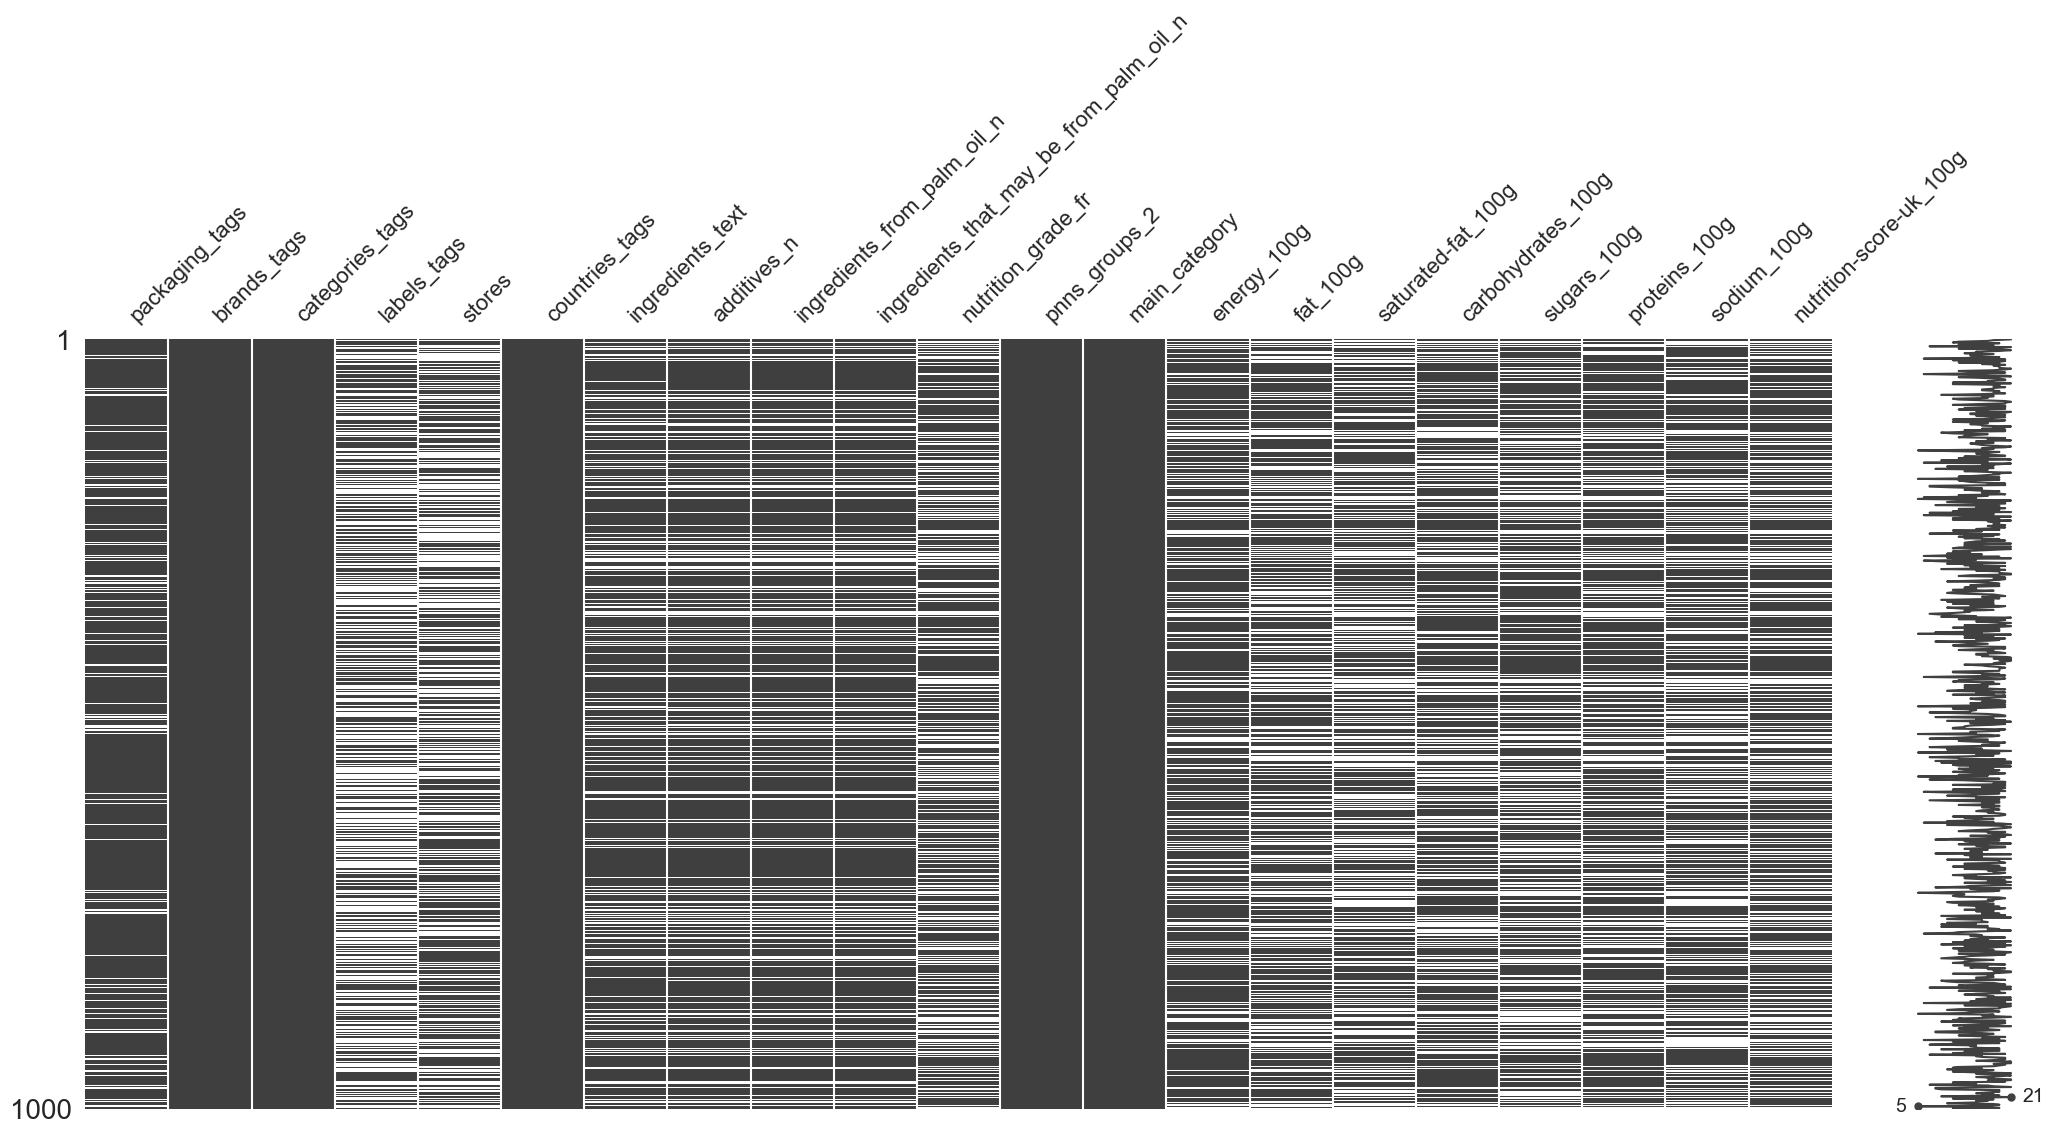

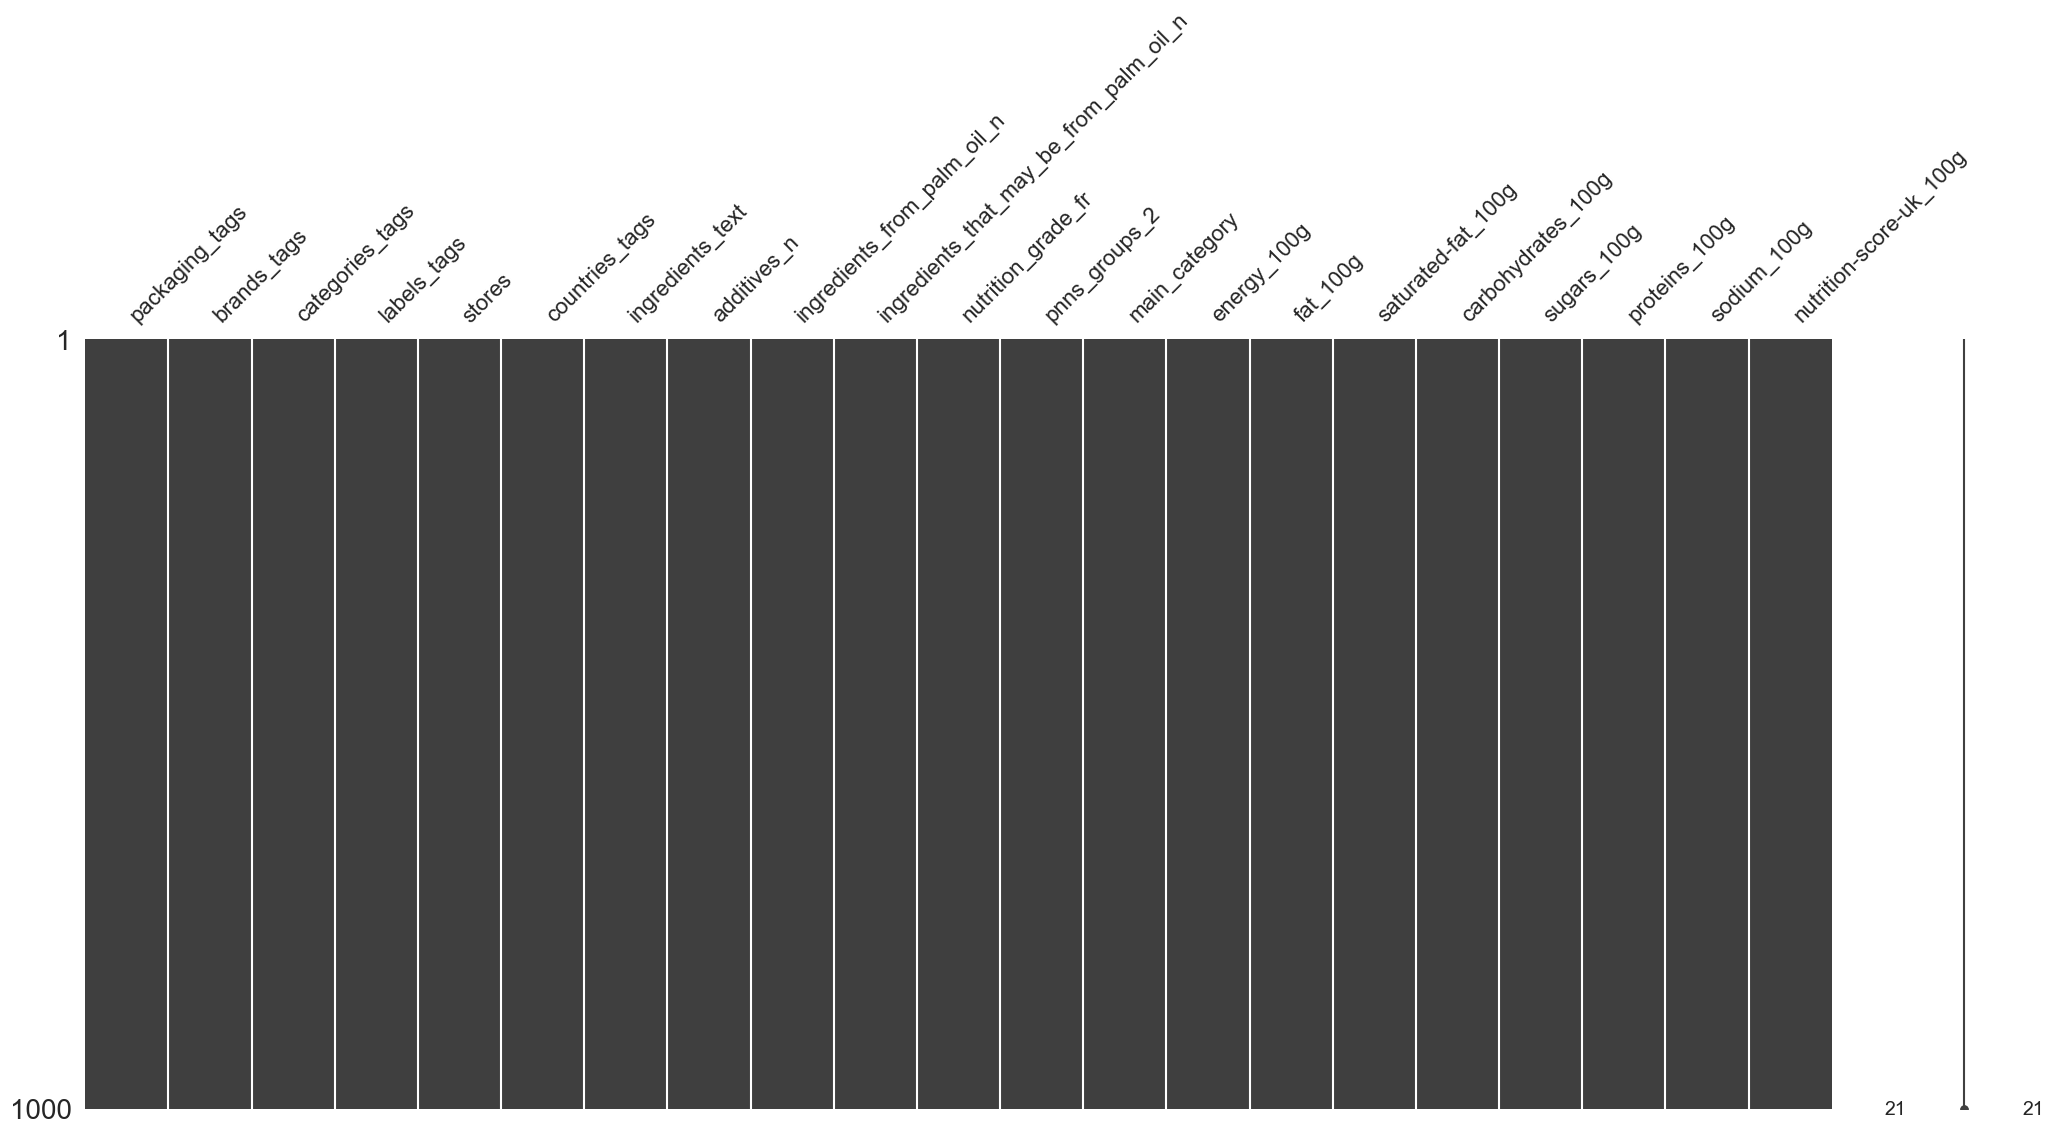

In [109]:
ref, test = build_test_data(filtered_data.drop(columns=["product_name", "generic_name"]), max_samples=1000)
print("Built")
msno.matrix(test)
imputed = pd.DataFrame(random_imputation(df=test, features_to_estimate=test.columns[test.isna().any()]))
print("Imputed")
msno.matrix(imputed)
score_random_imputation, summarized_score_random_imputation, heatmap_random_imputation = getImputationScore(ref, test, imputed)

Built


c:\Git-OpenClassrooms\DS_3\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Imputed


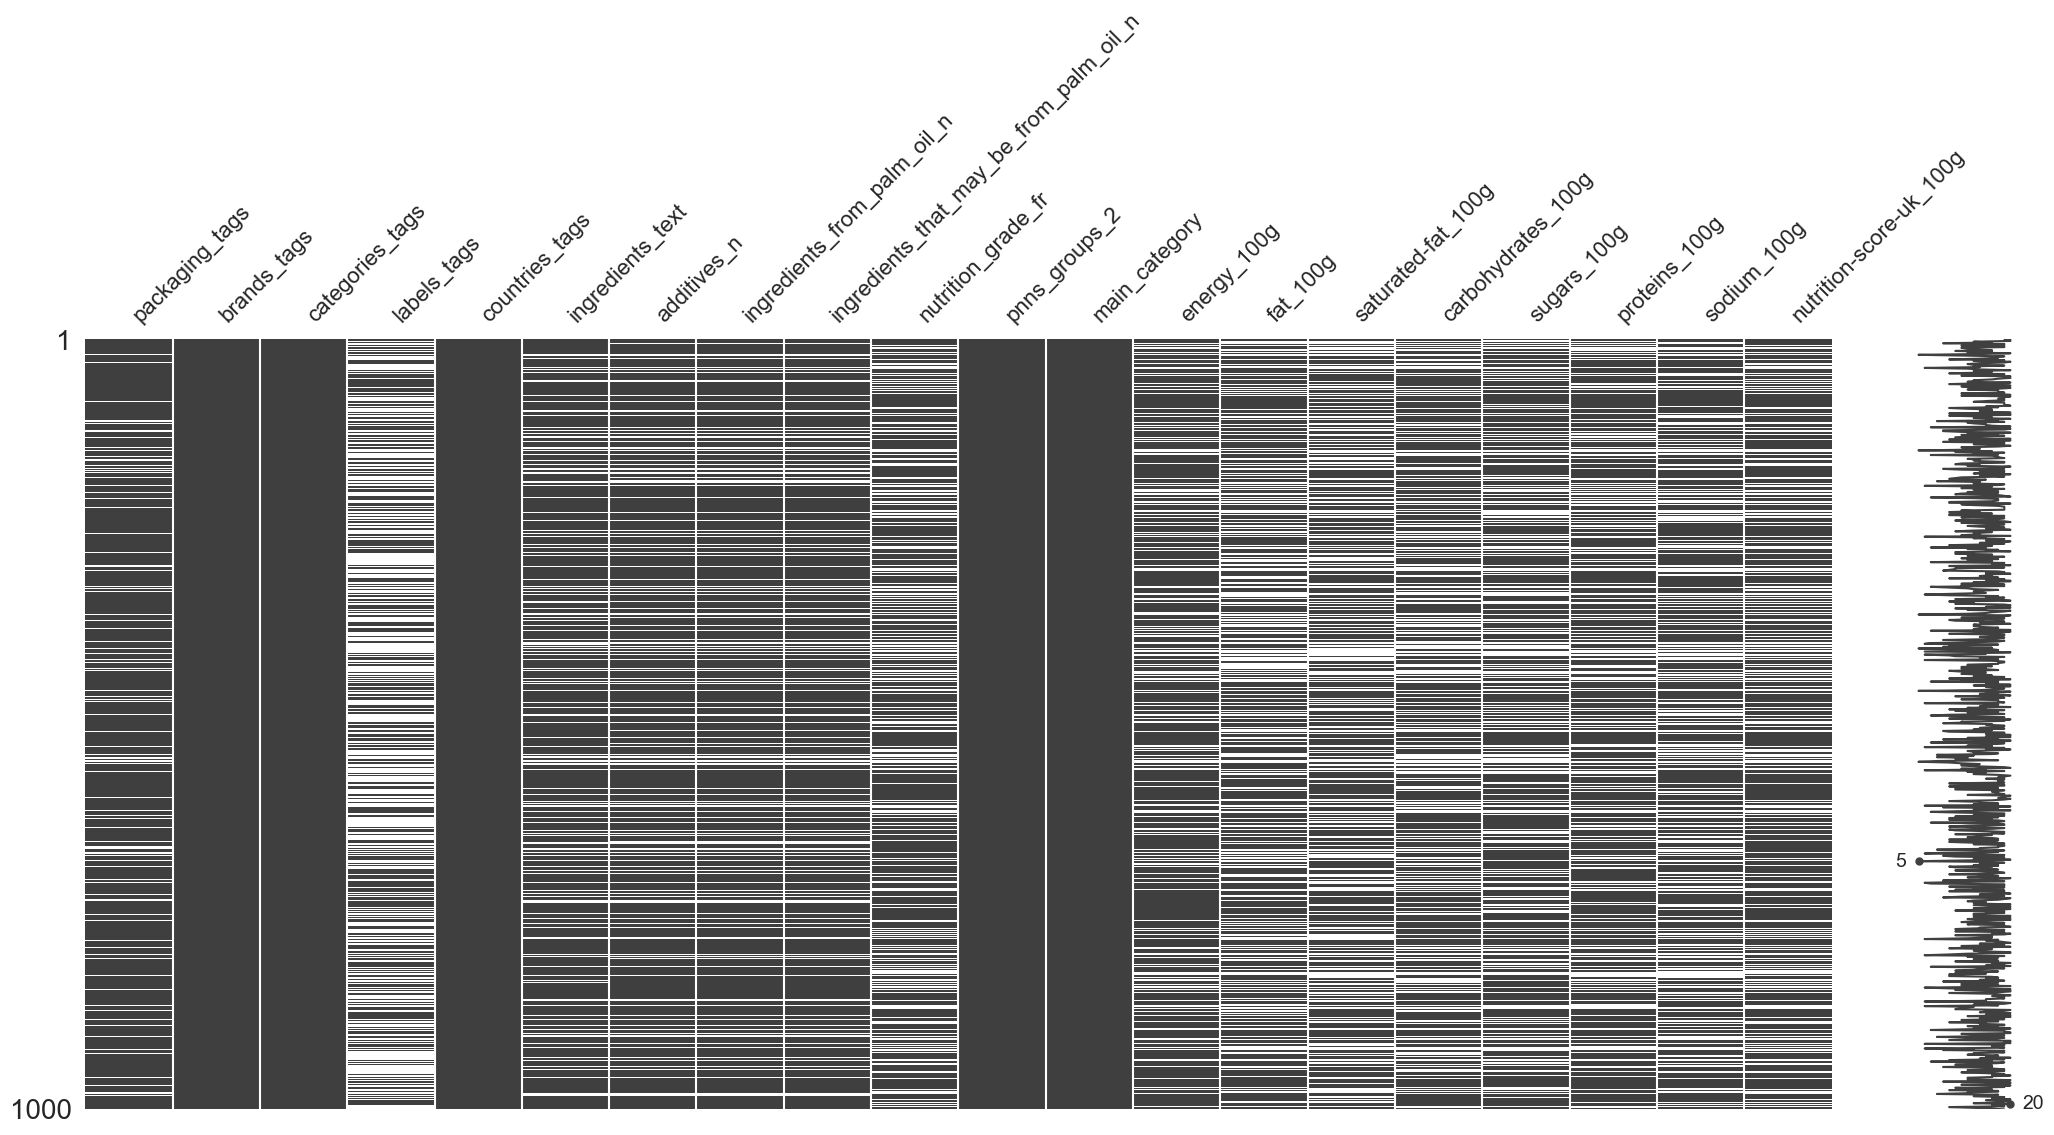

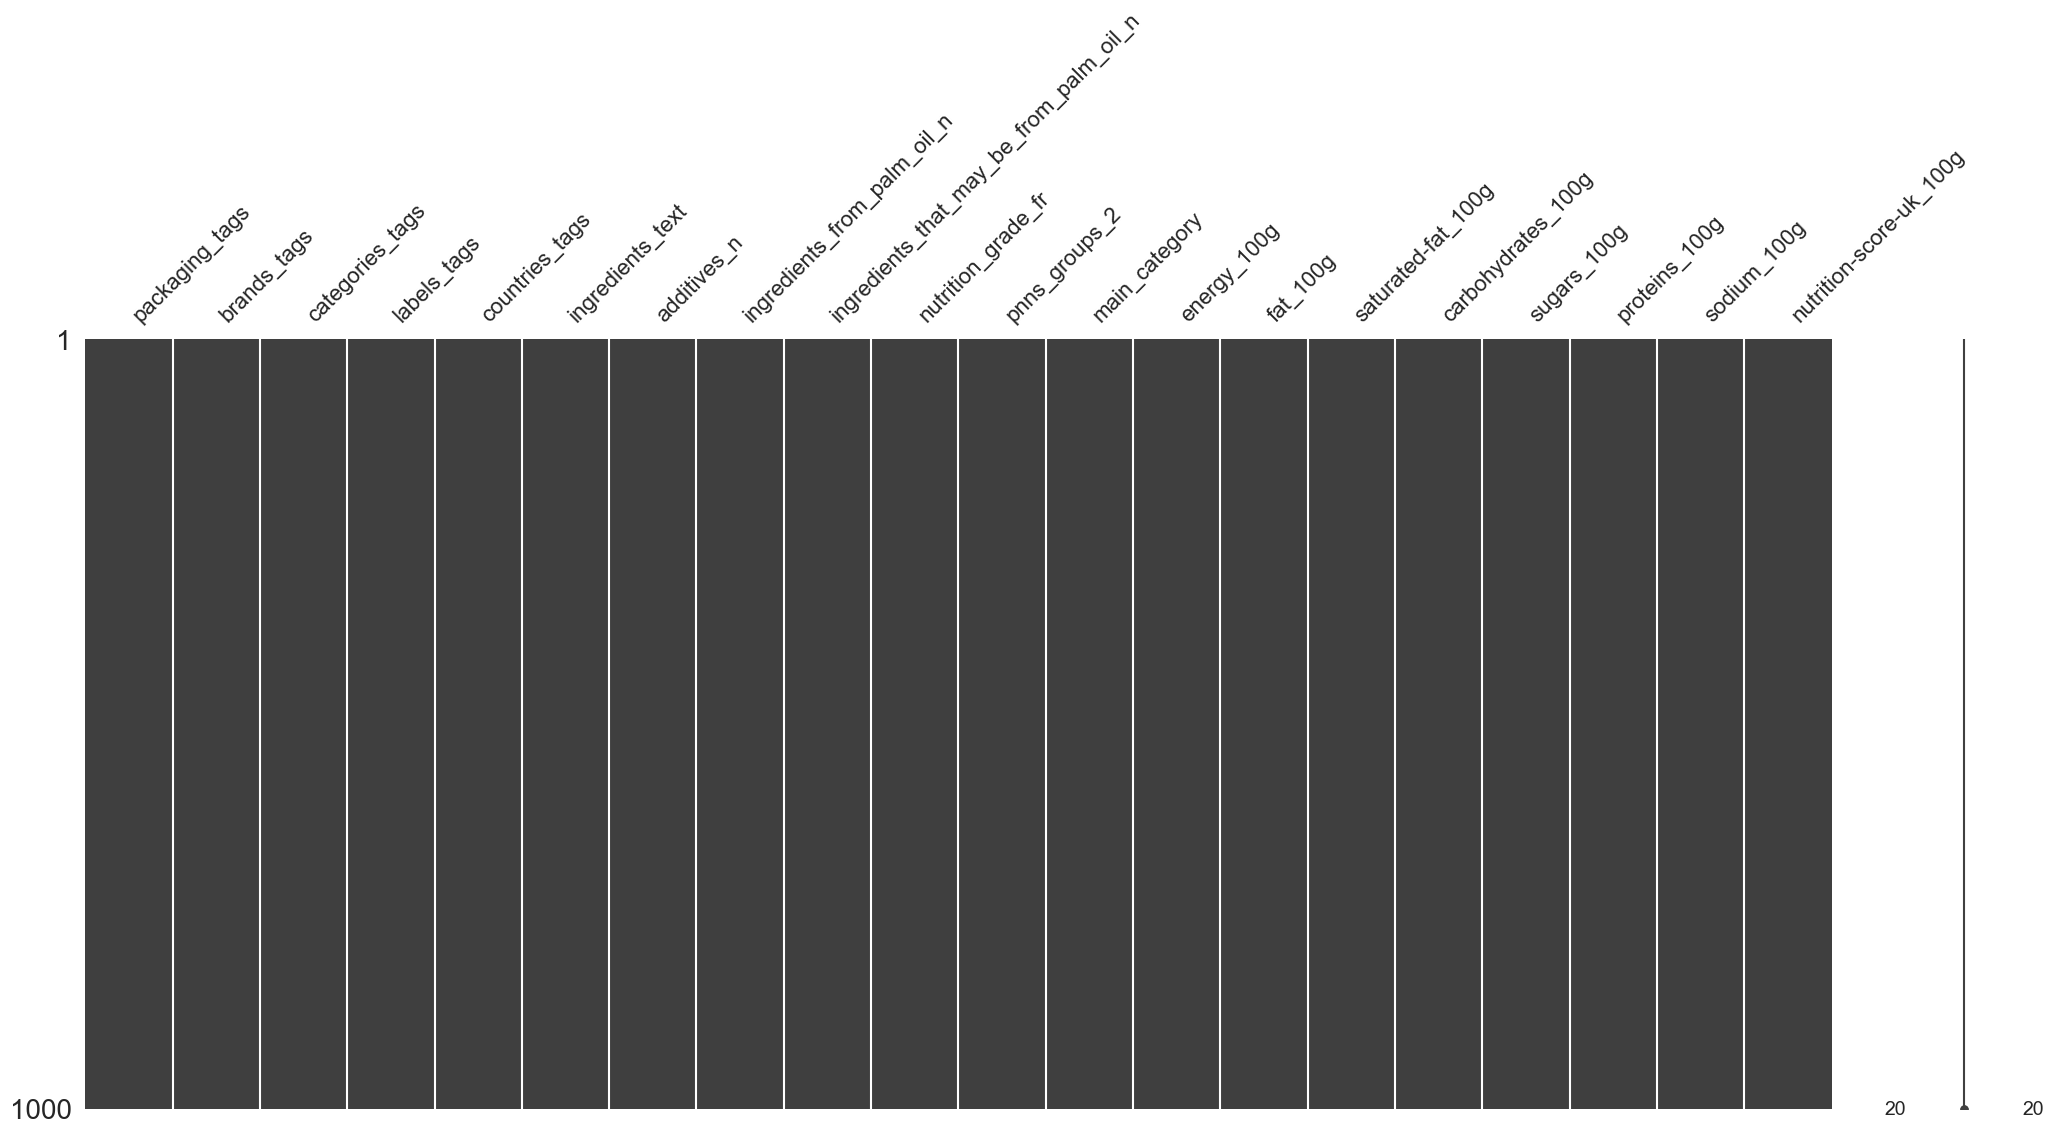

In [110]:
ref, test = build_test_data(filtered_data.drop(columns=["product_name", "generic_name", "stores"]), max_samples=1000)
print("Built")
msno.matrix(test)
imputed = pd.DataFrame(imputation(df=test, features_to_estimate=test.columns[test.isna().any()], n_neighbors=12, method="build_and_save"))
print("Imputed")
msno.matrix(imputed)
score, summarized_score, heatmap = getImputationScore(ref, test, imputed)

In [523]:
# filtered_data["missing_count"] = filtered_data.isna().sum(axis=1)
# test=filtered_data.sort_values("missing_count", ascending=False)
# test.loc[test["missing_count"] > 16]